# Project Overview

> This is an in-depth notebook which explores the King County Housing Dataset through several different models. The notebook includes a thorough EDA and cleaning section, study of different models using different categorical methods (one-hot encoding vs target encoding) with extensive parameter tuning, an exploration of different feature selection methods, an evaluation of the final model, and visualizations.

## Table of Contents

* **Business Objective**


* **Notebook Preparation**
    * Importing our Modules


* **Preprocessing**
    * EDA and Cleaning
        * Scaling Time Series
        * Duplicates
        * Outlier Detection
        * Missing Data
        * Binary Data
        * Visualize Cleaned Data
        * Studying our Target Variable
    * Create Holdout Set
    * Feature Engineering
    * Correlations and Multicollinearity
    * EDA & Process Train Set
        * Categoricals
        * Continuous
            * Find Interactions
            * Transform and Standardize Continuous Data
            * Add Polynomial Features
    * Process Test Set
        * Categoricals
        * Continuous
    * Create Train/Test Split


* **Model Explorations**
    * Picking our Base Features
    * Linear Regressions
        * Basic LR with Top Features One-Hot Encoded
        * Basic LR with Top Features Target Encoded
        * LR with ALL model features
        * Linear Regression with various Feature Selection Methods
            * Forward-Backward Selector
            * Permutation Importance
            * RFECV
    * K-Nearest Neighbors
    * Support Vector Regression
    * XGBoost Model
        * One Hot Encoded
        * Target Encoded


* **Model Selection and Analysis**

* **Additional Visualizations**

* **APPENDIX**

## Objective

* Perform exhaustive and accurate data cleaning
* Explore different categorical handling methods
* Build a model that accurately predicts house prices in King County

## Package Imports

In [1]:
# data processing tools
import pandas as pd
import numpy as np
from numpy import mean
from numpy import std
from numpy import argmax
from math import sqrt
import time
from collections import Counter
import itertools

# preprocessing
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import train_test_split, cross_validate, HalvingGridSearchCV, StratifiedKFold, validation_curve

# scoring and algorithm selection packages
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score 
from sklearn.inspection import permutation_importance

# model tools
import statsmodels.api as sm
from statsmodels.formula.api import ols

import scipy.stats as stats
from scipy.stats import norm

from sklearn.linear_model import LinearRegression, BayesianRidge, ElasticNet, GammaRegressor, HuberRegressor,  Lars, Lasso, SGDRegressor
from sklearn.linear_model import LassoLars, OrthogonalMatchingPursuit, PassiveAggressiveRegressor, PoissonRegressor, RANSACRegressor, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR, LinearSVR, NuSVR
from sklearn.feature_selection import RFECV
from sklearn.model_selection import cross_val_score, RepeatedKFold, GridSearchCV, KFold
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, ExtraTreesRegressor, AdaBoostRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.kernel_ridge import KernelRidge
import xgboost as xgb


# visualization packages
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# ignore warnings (gets rid of Pandas copy warnings)
import warnings
warnings.filterwarnings('ignore')
pd.options.display.max_columns = None


## Notebook Functions

### Cleaning Functions

In [2]:
def iqr_outliers(column):
    """return the lower range and upper range for the data based on IQR*1.6"""
    Q1,Q3 = np.percentile(column , [25,75])
    iqr = Q3 - Q1
    lower_range = Q1 - (1.6 * iqr)
    upper_range = Q3 + (1.6 * iqr)
    return lower_range,upper_range  

### Preprocessing Functions

In [3]:
# this function is by Max Halford at the address noted above
def calc_smooth_mean(df, by, on, m, target_df):
    '''input a pandas.DataFrame, a categorical column name, the name of the target column, and a weight .'''
    # Compute the global mean
    mean = df[on].mean() 

    # Compute the number of values and the mean of each group
    agg = df.groupby(by)[on].agg(['count', 'mean'])  
    counts = agg['count']
    means = agg['mean']

    # Compute the "smoothed" means
    smooth = (counts * means + m * mean) / (counts + m)

    # Replace each value by the according smoothed mean
    return round(target_df[by].map(smooth), 0) 

In [4]:
def test_feature_combinations(price, variables):
    
    """Function takes in target price and a dataframe of independent variables, and 
    tests model improvement for each combination of variables
    ARGUMENTS:
    Y of target values
    X-dataframe of continuous features
    Returns dataframe of score improvements over base score for each interaction combination"""
    
    # select our estimator and our cross validation plan
    regression = LinearRegression()
    cv = RepeatedKFold(n_splits=5, n_repeats=2, random_state=1)
    
    # prepare our scoring dataframe
    scoring_df = pd.DataFrame()
    
    # prepare our lists to store our features and scores as we iterate
    scores = []
    feature1 = []
    feature2 = []
    
    # Get a list of all of our features, and remove our target variable 'price' from the list
    features = list(variables.columns)

    # make a list of all of our possible feature combinations
    feature_combos = itertools.combinations(features, 2)
    feature_combos = list(feature_combos)
    
    # set our y-value as our target variable
    y = price
    
    # prepare our x-value with our independent variables. We do an initial split here in order to run a 
    # linear regression to get a base r^2 on our basic model without interactions
    X = variables
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=randomstate)
    base_score = round(np.mean(cross_val_score(regression, X_train, y_train, scoring='r2', cv=cv)), 4)   
    print("Model base score is ",base_score)
    
    # now we run the regression on each feature combo
    for feature in feature_combos:
        feat1, feat2 = feature[0], feature[1]
        
        # create the test interaction on our data set
        variables['test_interaction'] = variables[feat1] * variables[feat2]
        # create a new X which includes the test interaction and drops our target value
        X = variables
        # make a new split so that our x-splits include the test interaction
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=randomstate)
        
        # Run a linear regression with cross-val just like our base model, and append the score to our scores list
        new_score = round(np.mean(cross_val_score(regression, X_train, y_train, scoring='r2', cv=cv)), 4)
        scores.append(new_score)
        # put feature 1 on a list
        feature1.append(feat1)
        # put feature 2 on a list
        feature2.append(feat2)
        print(feat1, feat2, new_score)
        
        
    
    # load all of our lists into the scoring dataframe
    scoring_df['feature1'] = feature1
    scoring_df['feature2'] = feature2
    scoring_df['scores'] = scores
    scoring_df['improvement'] = scoring_df['scores'] - base_score
    variables.drop('test_interaction', axis=1, inplace=True)
    
    # return our scoring dataframe to the function
    return scoring_df

### Tuning Functions

In [5]:
def stepwise_selection(X, y, 
                       initial_list=[], 
                       threshold_in=0.01, 
                       threshold_out = 0.05, 
                       verbose=True):
    """ 
    Perform a forward-backward feature selection 
    based on p-value from statsmodels.api.OLS
    Arguments:
        X - pandas.DataFrame with candidate features
        y - list-like with the target
        initial_list - list of features to start with (column names of X)
        threshold_in - include a feature if its p-value < threshold_in
        threshold_out - exclude a feature if its p-value > threshold_out
        verbose - whether to print the sequence of inclusions and exclusions
    Returns: list of selected features 
    Always set threshold_in < threshold_out to avoid infinite looping.
    See https://en.wikipedia.org/wiki/Stepwise_regression for the details
    """
    included = list(initial_list)
    while True:
        changed=False
        # forward step
        excluded = list(set(X.columns)-set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            modelols = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit()
            new_pval[new_column] = modelols.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed=True
            if verbose:
                print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))

        # backward step
        modelols = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = modelols.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > threshold_out:
            changed=True
            worst_feature = included[pvalues.argmax()]
            included.remove(worst_feature)
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval))
        if not changed:
            break
    return included



In [6]:
def grid_optimizer(model, grid, x, y):
    
    '''Takes in a model and a grid of hyperparameters, and runs a HalvingGridSearch
    arguments: model, parameter grid, x and y to check parameter grid
    returns: best parameters'''
    
    start=time.time()
    
    print("Making Search")
    grid_search = HalvingGridSearchCV(model, grid, verbose=10, scoring='neg_mean_absolute_error', cv=5, min_resources='exhaust')

    print("Running Grid")
    grid_search.fit(x, y)

    grid_search.best_estimator_
    
    # Best f1
    print('Best mae: %.3f' % grid_search.best_score_)

    print("Best parameters set found on train set: \n")
    print(grid_search.best_params_)
    print("\nGrid scores on train set:\n")
    means = grid_search.cv_results_['mean_test_score']
    stds = grid_search.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, grid_search.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))
    
    print(f'Elapsed Time: {time.time() - start}')
    
    return grid_search.best_params_

### Scoring Functions

In [7]:
def score_model(model, x, y, model_type, method, score_list):
    
    # get accuracy cross val score for cv 5
    scores = cross_validate(model, x, y, cv=5, n_jobs=-1,
        scoring=('r2', 'neg_mean_absolute_error', 'neg_root_mean_squared_error'),
        return_train_score=True)
    r2 = round(scores['test_r2'].mean()*100,2)
    mae = round(scores['test_neg_mean_absolute_error'].mean(), 3)
    mrse = round(scores['test_neg_root_mean_squared_error'].mean(), 3)
    
    print("\n\n",model_type,method)
    print("CV 5 R2 Train Score: {}".format(r2))
    print("CV 5 MAE Train Score: {}".format(mae))
    print("CV 5 RMSE Train Score: {}".format(mrse))

    # append our scores to our lists
    score_list['model'].append(model_type)
    score_list['method'].append(method)
    score_list['r2'].append(r2)
    score_list['mae'].append(mae)
    score_list['rmse'].append(mrse)
    
    return score_list

In [8]:
def ValidationCurve(estimator, predictors, target, param_name, hyperparam, options):
    
    train_score, test_score = validation_curve(estimator, predictors, target, 
                                               param_name, options, 
                                               cv=5, scoring='neg_mean_absolute_error', n_jobs=-4)
    Rsqaured_train = train_score.mean(axis=1)
    Rsquared_test= test_score.mean(axis=1)
    
    plt.figure(figsize=(10,5))
    plt.plot(options, Rsqaured_train, color='r', linestyle='-', marker='o', label='Training CV')
    plt.legend(labels='Training CV')
    plt.xlabel(hyperparam)
    plt.ylabel('MAE')
    plt.title("Mean Absolute Error for {} on Train".format(hyperparam))

### Visualization Functions

In [9]:
def plot_polys(y, xlabel, title):
    '''Takes in a y-axis, x-axis label, and title and plots with various polynomial levels
    ARGUMENTS:
    y axis variable values
    x-axis label
    visualization title'''
    x = y.index
    
    # express numbers as arrays and reshape
    y = np.array(y)
    x = np.array(x)
    x = x.reshape(-1, 1)
    
    # make sure indices match up
    y = y[x[:,0].argsort()]
    x = x[x.argsort()]

    # plot figure
    plt.figure(figsize=(16, 8))

    # standard linear regression
    linreg = LinearRegression()
    linreg.fit(x, y)

    # 2nd degree polynomial regression
    poly2 = PolynomialFeatures(degree=2)
    x_poly2 = poly2.fit_transform(x)
    poly_reg2 = LinearRegression()
    poly_reg2.fit(x_poly2, y)

    # third degree polynomial regression 
    poly3 = PolynomialFeatures(degree=3)
    x_poly3 = poly3.fit_transform(x)
    poly_reg3 = LinearRegression()
    poly_reg3.fit(x_poly3, y)

    # predict on x values
    pred = linreg.predict(x)
    pred2 = poly_reg2.predict(x_poly2)
    pred3 = poly_reg3.predict(x_poly3)

    # plot regression lines
    plt.scatter(x, y)
    plt.yscale('log')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel('Average')
    plt.plot(x, pred, c='red', label='Linear regression line')
    plt.plot(x, pred2, c='yellow', label='Polynomial regression line 2')
    plt.plot(x, pred3, c='#a3cfa3', label='Polynomial regression line 3');

### Modeling Functions

### Stacking Functions

In [10]:
# create a meta dataset with each column comprised of the predictions from level 1, as well as a column with the original data
def create_meta_dataset(data_x, *args):
    
    #meta_x = np.empty([len(args[0]),1])
    #print(meta_x.shape)
    meta_x = data_x
    
    for z in args:
        z = np.array(z).reshape((len(z), 1))
        meta_x = np.hstack((meta_x, z))
        
    return meta_x

#data_x, 

In [209]:
def stack_prediction(X_test_encoded, X_test_refined, X_test_onehot, X_test_onehot_nostand,
                              linreg, lasso): 

    #xgbc_yhat = xgbc.predict(X_test_encoded).reshape(-1,1)
    #print(xgbc_yhat.shape)
    
    #gradient_boost_yhat = gradient_boost.predict(X_test_encoded).reshape(-1,1)
    #print(gradient_boost_yhat.shape)
    
    #extra_trees_yhat = extra_trees.predict(X_test_encoded).reshape(-1,1)
    #print(extra_trees_yhat.shape)
    
    #ransac_yhat = ransac.predict(X_test_encoded).reshape(-1,1)
    #print(ransac_yhat.shape)
    
    #neighbor_yhat = neighbor.predict(X_test_encoded).reshape(-1,1)
    #print(neighbor_yhat.shape)
    
    #gauss_yhat = gauss.predict(X_test_encoded).reshape(-1,1)
    #print(gauss_yhat.shape)
    
    #sgd_yhat = sgd.predict(X_test_encoded).reshape(-1,1)
    #print(sgd_yhat.shape)
    
    #svr_yhat = svr.predict(X_test_onehot).reshape(-1,1)
    #print(svr_yhat.shape)
    
    #nu_svr_yhat = nu_svr.predict(X_test_onehot).reshape(-1,1)
    #print(nu_svr_yhat.shape)
    
    #orth_yhat = orth.predict(X_test_refined).reshape(-1,1)
    #print(orth_yhat.shape)
    
    linreg_yhat = linreg.predict(X_test_onehot).reshape(-1,1)
    print(linreg_yhat.shape)
    
    #ridge_yhat = ridge.predict(X_test_onehot).reshape(-1,1)
    #print(ridge_yhat.shape)
    
    #bay_ridge_yhat = bay_ridge.predict(X_test_onehot).reshape(-1,1)
    #print(bay_ridge_yhat.shape)
    
    #mlp_yhat = mlp.predict(X_test_onehot).reshape(-1,1)
    #print(mlp_yhat.shape)
    
    #lasso_lars_yhat = np.log(lasso_lars.predict(X_test_onehot_nostand)).reshape(-1,1)
    #print(lasso_lars_yhat.shape)
    
    lasso_yhat = np.log(lasso.predict(X_test_onehot_nostand)).reshape(-1,1)
    print(lasso_yhat.shape)
    
    meta_X = create_meta_dataset(X_test_encoded, 
                                 #xgbc_yhat, 
                                 #gradient_boost_yhat, 
                                 #extra_trees_yhat,
                                 #ransac_yhat,
                                 #neighbor_yhat,
                                 #gauss_yhat,
                                 #sgd_yhat,
                                 #svr_yhat,
                                 #nu_svr_yhat, 
                                 #orth_yhat,
                                 linreg_yhat,
                                 #ridge_yhat,                               
                                 #bay_ridge_yhat,
                                 #mlp_yhat,
                                 #lasso_lars_yhat,
                                 lasso_yhat
                                )
    print(meta_X.shape)
        
    return meta_X


# Obtaining Our Data

In [12]:
# load and look at our king county housing data
df = pd.read_csv('kc_house_data.csv')
df

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21608,263000018,20140521T000000,360000.0,3,2.50,1530,1131,3.0,0,0,3,8,1530,0,2009,0,98103,47.6993,-122.346,1530,1509
21609,6600060120,20150223T000000,400000.0,4,2.50,2310,5813,2.0,0,0,3,8,2310,0,2014,0,98146,47.5107,-122.362,1830,7200
21610,1523300141,20140623T000000,402101.0,2,0.75,1020,1350,2.0,0,0,3,7,1020,0,2009,0,98144,47.5944,-122.299,1020,2007
21611,291310100,20150116T000000,400000.0,3,2.50,1600,2388,2.0,0,0,3,8,1600,0,2004,0,98027,47.5345,-122.069,1410,1287


In [13]:
df.dtypes

id                 int64
date              object
price            float64
bedrooms           int64
bathrooms        float64
sqft_living        int64
sqft_lot           int64
floors           float64
waterfront         int64
view               int64
condition          int64
grade              int64
sqft_above         int64
sqft_basement      int64
yr_built           int64
yr_renovated       int64
zipcode            int64
lat              float64
long             float64
sqft_living15      int64
sqft_lot15         int64
dtype: object

In [14]:
df.describe()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,2.161300e+04,2.161300e+04,21613.000000,21613.000000,21613.000000,2.161300e+04,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000
mean,4.580302e+09,5.400881e+05,3.370842,2.114757,2079.899736,1.510697e+04,1.494309,0.007542,0.234303,3.409430,7.656873,1788.390691,291.509045,1971.005136,84.402258,98077.939805,47.560053,-122.213896,1986.552492,12768.455652
std,2.876566e+09,3.671272e+05,0.930062,0.770163,918.440897,4.142051e+04,0.539989,0.086517,0.766318,0.650743,1.175459,828.090978,442.575043,29.373411,401.679240,53.505026,0.138564,0.140828,685.391304,27304.179631
min,1.000102e+06,7.500000e+04,0.000000,0.000000,290.000000,5.200000e+02,1.000000,0.000000,0.000000,1.000000,1.000000,290.000000,0.000000,1900.000000,0.000000,98001.000000,47.155900,-122.519000,399.000000,651.000000
25%,2.123049e+09,3.219500e+05,3.000000,1.750000,1427.000000,5.040000e+03,1.000000,0.000000,0.000000,3.000000,7.000000,1190.000000,0.000000,1951.000000,0.000000,98033.000000,47.471000,-122.328000,1490.000000,5100.000000
50%,3.904930e+09,4.500000e+05,3.000000,2.250000,1910.000000,7.618000e+03,1.500000,0.000000,0.000000,3.000000,7.000000,1560.000000,0.000000,1975.000000,0.000000,98065.000000,47.571800,-122.230000,1840.000000,7620.000000
75%,7.308900e+09,6.450000e+05,4.000000,2.500000,2550.000000,1.068800e+04,2.000000,0.000000,0.000000,4.000000,8.000000,2210.000000,560.000000,1997.000000,0.000000,98118.000000,47.678000,-122.125000,2360.000000,10083.000000
max,9.900000e+09,7.700000e+06,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,1.000000,4.000000,5.000000,13.000000,9410.000000,4820.000000,2015.000000,2015.000000,98199.000000,47.777600,-121.315000,6210.000000,871200.000000


In [15]:
df.isna().sum()

id               0
date             0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
dtype: int64

# Scrubbing/Cleaning Data

### Scale Time Series

In [16]:
# converting our date to a proper datetime
df['date'] = pd.to_datetime(df['date'])

# print earliest and latest dates
print(df['date'].min())
print(df['date'].max())

2014-05-02 00:00:00
2015-05-27 00:00:00


This data includes a TIME SERIES, and we need to bring our target prices to the same time scale. It's easy to ignore that these homes were sold over the space of a year, but a year is a long time for real estate. King County median prices increased 9.05% from May 2014 to May 2015, and we need to account for this kind of change in our model. We'll do this by appreciating all sale prices into May 2015 using an appreciation rate over the year of 9.05%, and dividing into months (more granularity is possible of course)

In [17]:
# We're applying a time series multiplier to our rows based on date sold. Our data spans from
# May 2014-May 2015 so we divide it into a 12 month time series.
df.loc[(df['date']>'2014-05-01') & (df['date']<'2014-06-01'), 'time_series'] = 12
df.loc[(df['date']>='2014-06-01') & (df['date']<'2014-07-01'), 'time_series'] = 11
df.loc[(df['date']>='2014-07-01') & (df['date']<'2014-08-01'), 'time_series'] = 10
df.loc[(df['date']>='2014-08-01') & (df['date']<'2014-09-01'), 'time_series'] = 9
df.loc[(df['date']>='2014-09-01') & (df['date']<'2014-10-01'), 'time_series'] = 8
df.loc[(df['date']>='2014-10-01') & (df['date']<'2014-11-01'), 'time_series'] = 7
df.loc[(df['date']>='2014-11-01') & (df['date']<'2014-12-01'), 'time_series'] = 6
df.loc[(df['date']>='2014-12-01') & (df['date']<'2015-01-01'), 'time_series'] = 5
df.loc[(df['date']>='2015-01-01') & (df['date']<'2015-02-01'), 'time_series'] = 4
df.loc[(df['date']>='2015-02-01') & (df['date']<'2015-03-01'), 'time_series'] = 3
df.loc[(df['date']>='2015-03-01') & (df['date']<'2015-04-01'), 'time_series'] = 2
df.loc[(df['date']>='2015-04-01') & (df['date']<'2015-05-01'), 'time_series'] = 1
df.loc[(df['date']>='2015-05-01') & (df['date']<'2015-06-01'), 'time_series'] = 0

# adjusting up our sale prices to account for appreciation using the yearly appreciation for home sales in King County
# from May 2014 to May 2015
monthly_appreciation = .0905/12
df['adj_price'] = round(df['price']*(1+((monthly_appreciation)*df['time_series'])), 0)

# we're renaming our adjusted price column to be price
df.rename(columns={'price': 'orig_price', "adj_price": "price"}, inplace=True)

# renumber our data
df.set_index('price', inplace=True)
df.reset_index(inplace=True)

# we're now going to extract just the month from our datetime, and store that in a new column
# we won't be using our entire date - we're interested in the month that houses are sold
df['month_sold'] = pd.DatetimeIndex(df['date']).month
df.drop('date', axis=1, inplace=True)

### Duplicate Data

In [18]:
# Look for duplicate data on lat/long

df[df.duplicated(subset=['lat','long'], keep=False)].sort_values('lat')

,price,id,orig_price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,time_series,month_sold
20925,267437.0,8141310040,246950.0,3,3.00,1670,4440,1.0,0,0,3,7,1670,0,2014,0,98022,47.1948,-121.975,1670,4622,11.0,6
20686,276063.0,8141310030,256703.0,3,2.00,1670,4441,1.0,0,0,3,7,1670,0,2014,0,98022,47.1948,-121.975,1670,4622,10.0,7
16535,473877.0,5595900345,460000.0,4,2.75,3460,13168,2.0,0,0,4,8,3460,0,1932,1986,98022,47.2046,-121.996,1500,7670,4.0,1
5147,238545.0,5595900280,235000.0,3,1.00,1050,7670,1.5,0,0,5,7,1050,0,1955,0,98022,47.2046,-121.996,1220,7670,2.0,3
8429,331227.0,9432900180,307999.0,4,2.75,2420,8438,2.0,0,0,3,8,2420,0,1996,0,98022,47.2091,-122.009,2420,8580,10.0,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16320,326060.0,7418700050,299000.0,3,1.00,1390,9624,1.5,0,0,4,7,1390,0,1954,0,98155,47.7758,-122.301,1440,9624,12.0,5
10538,419788.0,253600160,384950.0,3,2.50,1860,3690,2.0,0,0,3,7,1860,0,2000,0,98028,47.7760,-122.239,1870,4394,12.0,5
7532,405792.0,253600150,380000.0,2,2.50,1860,3504,2.0,0,0,3,7,1860,0,2000,0,98028,47.7760,-122.239,1860,4246,9.0,8
747,487277.0,293720140,449950.0,3,2.50,2170,4912,2.0,0,0,3,7,2170,0,2003,0,98028,47.7767,-122.239,2010,4395,11.0,6


In [19]:
# We have a lot of duplicate entries. We're going to keep the later of these entries and hope that if it's an outlier,
# it's caught in our outlier processing later.

df.drop_duplicates(['lat','long'], keep='last', inplace=True)

### Outlier Detection

In [20]:
'''# plotting latitude and longitude as a visual scatter plot to look for location outliers

plt.figure(figsize=(25,25))

sns.scatterplot(data=df, x="long", y="lat", hue="price", palette="magma_r");'''

'# plotting latitude and longitude as a visual scatter plot to look for location outliers\n\nplt.figure(figsize=(25,25))\n\nsns.scatterplot(data=df, x="long", y="lat", hue="price", palette="magma_r");'

Using latitude and longitude, we make a visual map of the King County area that lets us see the map outliers. We can see that there are a few sales in locations that are outliers in some way - still in King County but very far away from the metro area on which we are focusing. Sales that are too far outside of our comparison area geographically may add noise to our model. So I'm going to drop the longitude outliers as well. 

This visualization suggests that location is very important to home price. We're going to check that out more directly.

In [21]:
# drop the properties east of the metropolitan area
df.drop(df[df['long'] > -121.7].index, inplace=True)

# looking for outliers in the percentiles
df.describe()

,price,id,orig_price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,time_series,month_sold
count,2.080900e+04,2.080900e+04,2.080900e+04,20809.000000,20809.000000,20809.000000,2.080900e+04,20809.000000,20809.000000,20809.000000,20809.000000,20809.000000,20809.000000,20809.000000,20809.000000,20809.000000,20809.000000,20809.000000,20809.000000,20809.000000,20809.000000,20809.000000,20809.000000
mean,5.703036e+05,4.577438e+09,5.434746e+05,3.380556,2.118482,2092.673651,1.540826e+04,1.487097,0.007737,0.238839,3.413715,7.665097,1796.978183,295.695468,1970.862944,85.459561,98077.644433,47.559213,-122.213780,1995.607285,12983.825652,6.533711,6.562209
std,3.884515e+05,2.875639e+09,3.696620e+05,0.929549,0.771670,922.394989,4.209881e+04,0.533516,0.087622,0.773236,0.651549,1.180244,832.229017,445.657536,29.223085,404.081343,53.598262,0.138948,0.138697,687.649367,27690.839852,3.724901,3.117275
min,7.669700e+04,1.000102e+06,7.500000e+04,0.000000,0.000000,290.000000,5.200000e+02,1.000000,0.000000,0.000000,1.000000,1.000000,290.000000,0.000000,1900.000000,0.000000,98001.000000,47.159300,-122.519000,399.000000,659.000000,0.000000,1.000000
25%,3.375260e+05,2.123049e+09,3.240000e+05,3.000000,1.750000,1430.000000,5.102000e+03,1.000000,0.000000,0.000000,3.000000,7.000000,1200.000000,0.000000,1951.000000,0.000000,98033.000000,47.468600,-122.327000,1490.000000,5160.000000,3.000000,4.000000
50%,4.765020e+05,3.904960e+09,4.520000e+05,3.000000,2.250000,1930.000000,7.680000e+03,1.500000,0.000000,0.000000,3.000000,7.000000,1570.000000,0.000000,1975.000000,0.000000,98065.000000,47.570900,-122.228000,1850.000000,7670.000000,7.000000,6.000000
75%,6.794120e+05,7.305301e+09,6.500000e+05,4.000000,2.500000,2560.000000,1.080000e+04,2.000000,0.000000,0.000000,4.000000,8.000000,2230.000000,580.000000,1996.000000,0.000000,98117.000000,47.677600,-122.124000,2376.000000,10133.000000,10.000000,9.000000
max,8.106496e+06,9.900000e+09,7.700000e+06,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,1.000000,4.000000,5.000000,13.000000,9410.000000,4820.000000,2015.000000,2015.000000,98199.000000,47.777600,-121.701000,6210.000000,871200.000000,12.000000,12.000000


We see potential outliers in price, sqft_lot, sqft_living, and bedrooms.

In [22]:
# check how our histograms are looking

# df.hist(figsize=(18,15), bins='auto');

We should never remove outliers indiscriminately, especially if they contain real data. Ultimately I opt to remove via IQR on sqft_living and sqft_lot, with reservations. A lot of our variables are not normally shaped, so we can't reliably remove outliers via standard deviation.

For the square footage variables, I ultimately concluded that extremely large houses and lots are so seriously under-represented in the dataset that we won't be able to reliably predict on them anyway and they are better left off.

In order to prevent a lot of data loss in this way, I kept IQR range of 1.6 instead of the standard 1.5

In [23]:
# determing our IQR ranges for lot size, sq footage
lotlower,lotupper = iqr_outliers(df.sqft_lot)
sqftlower, sqftupper = iqr_outliers(df.sqft_living)

# dropping the things outside of our lower and upper range
df.drop(df[ (df.sqft_lot > lotupper) | (df.sqft_lot < lotlower) ].index , inplace=True)
df.drop(df[ (df.sqft_living > sqftupper) | (df.sqft_living < sqftlower) ].index , inplace=True)

In [24]:
# we're using the median house value for a zip code to determine the zip code's sort, so we can visualize the zip code importance

# group our dataframe by zipcode on median home price, sorted ascending. 
zipsorted = pd.DataFrame(df.groupby('zipcode')['price'].median().sort_values(ascending=True))

# rank each zip code and assign rank to new column
zipsorted['rank'] = np.divmod(np.arange(len(zipsorted)), 1)[0]+1

# function that looks up a segment that a data entry belongs to
def make_group(x, frame, column):
    '''Takes in a line, a lookup table, and a target column
    returns value of target column
    ARGUMENTS:
    line from dataframe x
    lookup table frame
    column to return rank'''
    y = frame.loc[(frame.index == x)][column]
    z = np.array(y)
    z[0]
    return z[0]

# make a new column on our dataframe. Look up each zip entry's group, and append to the column.
df['zip_rank'] = df['zipcode'].apply(lambda x: make_group(x, zipsorted, 'rank'))

# apply the median home price per zip code to the data frame
df['median_zip'] = df['zipcode'].apply(lambda x: round(df.loc[df['zipcode']==x]['price'].median(), 0))

In [25]:
'''# visualize zip code as a color function, on a plot of price per square footage

fig, ax = plt.subplots(figsize=(20, 15))

ax.scatter(df['sqft_living'], df['price'] /100000, c=df['zip_rank'], cmap='magma_r')

ax.set_xlabel('Square Feet of Living Space', fontsize=12)
ax.set_ylabel('Price in $100,000', fontsize=12)
ax.set_title('Price per Total Square Feet, by Zip Code Median Rank', fontsize=20)
;'''

"# visualize zip code as a color function, on a plot of price per square footage\n\nfig, ax = plt.subplots(figsize=(20, 15))\n\nax.scatter(df['sqft_living'], df['price'] /100000, c=df['zip_rank'], cmap='magma_r')\n\nax.set_xlabel('Square Feet of Living Space', fontsize=12)\nax.set_ylabel('Price in $100,000', fontsize=12)\nax.set_title('Price per Total Square Feet, by Zip Code Median Rank', fontsize=20)\n;"

This plot of price per total square feet of living space, colored by the zip code median rank, visually shows the importance of location. Let's look at that closer.

In [26]:
'''# visualize zip code as a color function

fig, ax = plt.subplots(figsize=(20, 15))

ax.scatter(df['median_zip'], df['price'] /100000, c=df['zip_rank'], cmap='magma_r')

ax.set_xlabel('Median Home Price per Zip', fontsize=12)
ax.set_ylabel('Price in $100,000', fontsize=12)
ax.set_title('Price per Zip Code Median, by Zip Code Median Rank', fontsize=20)
;'''

"# visualize zip code as a color function\n\nfig, ax = plt.subplots(figsize=(20, 15))\n\nax.scatter(df['median_zip'], df['price'] /100000, c=df['zip_rank'], cmap='magma_r')\n\nax.set_xlabel('Median Home Price per Zip', fontsize=12)\nax.set_ylabel('Price in $100,000', fontsize=12)\nax.set_title('Price per Zip Code Median, by Zip Code Median Rank', fontsize=20)\n;"

Looking at our price per zip code in a different way, we can see a potential issue with our data. Most of our data set is fairly normal and expected. Then we have three zip codes giving us very strong right tails. Then we have ONE zip code way off yonder which may cause problems with our model. 

I'll be eliminating price outliers on a per-zipcode basis using the same IQR range. My goal here is not to strip usable data, but to identify and excise any rogue non-standard sales. If I were to do this dataset-wide, many zipcodes would retain their own outliers. We can see in the visualizations just above that zipcodes each have their own price distribution. So we keep our price outlier detection within zipcode.

In [27]:
# Eliminating outliers on a per-zipcode basis

zipcodes = df['zipcode'].unique()

for i in zipcodes:
    lower, upper = iqr_outliers(df[df['zipcode'] == i]['price'])
    df.drop(df[ ( (df.price > upper) & (df['zipcode'] == i) ) | ( (df.price < lower)  & (df['zipcode'] == i) ) ].index , inplace=True)


#### Manually locating zip/price outliers

One thing this data set lacks is *type of sale*. We want a model that properly describes the open market, but this dataset definitely includes sales that are outside the market, such as inter-family sales or other sales that don't properly reflect market value. The best way I can think of to find these outliers is to find suspiciously low sales based on location, because we can see in the lat/long scatter that location makes a difference. We will hunt these down manually even though that takes some time.

In [28]:
# check price stats by zip code and displaying top 30 zip codes by mean
# I'm looking for suspiciously low "min" values

find_zip_outliers = df.groupby('zipcode')['price'].describe()
find_zip_outliers.sort_values('mean', ascending=False).head(35)

# very suspicious values in many zip codes for min
# 98112, 98109, 98033, 98115, 98027, 98116, 98122, 98117, 98136, 98065, 98144, 98072, 98028

,count,mean,std,min,25%,50%,75%,max
zipcode,,,,,,,,
98039,31.0,1.696580e+06,527135.064658,840952.0,1331322.00,1631827.0,2014776.00,2863593.0
98004,228.0,1.179899e+06,444203.069610,450642.0,833869.50,1034311.5,1471871.00,2490804.0
98040,219.0,1.062392e+06,313783.466602,541479.0,831267.50,989706.0,1279455.00,1999232.0
98112,231.0,9.866290e+05,383385.730693,173148.0,695586.00,886977.0,1251888.50,1954035.0
98109,97.0,8.299721e+05,304542.249557,228087.0,626700.00,752837.0,962498.00,1561690.0
98105,203.0,8.150396e+05,325079.639034,395000.0,574075.00,695265.0,1006013.50,1722990.0
98119,163.0,8.117765e+05,269093.045311,309589.0,624424.00,761312.0,942897.00,1543079.0
98102,90.0,8.063466e+05,268892.500266,357376.0,620403.75,739164.0,988545.50,1559460.0
98075,244.0,7.776592e+05,144090.967601,430951.0,693140.75,776258.5,866396.75,1176019.0


In [29]:
df.loc[(df['price'] <= 250000) & (df['zipcode'] == 98109)]
# There are two listings in this zip code selling for under 250k. We're going to consider this an outlier sale.
# worth noting these are both the exact same property. These are both bad listings.

# It looks like we missed a dupe due to a slight mismatch in lat. Since this is a dupe AND an anomalous price, we are going to dump it.

,price,id,orig_price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,time_series,month_sold,zip_rank,median_zip
3844,228087.0,2734100734,216650.0,3,3.5,1540,1427,2.0,0,0,3,7,1360,180,2007,0,98109,47.5420,-122.322,1220,4000,7.0,10,64,767264.0
11436,228087.0,2734100732,216650.0,3,3.5,1480,1077,2.0,0,0,3,7,1300,180,2007,0,98109,47.5421,-122.322,1140,2003,7.0,10,64,767264.0


In [30]:
df.loc[(df['price'] <= 250000) & (df['zipcode'] == 98033)]
#We're going to consider these outlier sales.

,price,id,orig_price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,time_series,month_sold,zip_rank,median_zip
1222,132941.0,1238500451,130000.0,3,1.0,1110,7520,1.0,0,0,4,7,1110,0,1960,0,98033,47.6830,-122.176,1440,8400,3.0,2,58,677512.0
12823,151561.0,2870000040,145000.0,2,1.0,800,8125,1.0,0,0,3,6,800,0,1964,0,98033,47.6836,-122.174,2390,8125,6.0,11,58,677512.0


In [31]:
df.loc[(df['price'] <= 250000) & (df['zipcode'] == 98115)]
#We're going to consider these outlier sales.

,price,id,orig_price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,time_series,month_sold,zip_rank,median_zip
1975,209050.0,5101404170,200000.0,1,0.75,680,9600,1.0,0,0,3,5,680,0,1947,0,98115,47.6964,-122.306,1580,6624,6.0,11,53,597497.0


In [32]:
df.loc[(df['price'] <= 250000) & (df['zipcode'] == 98027)]
# listings under 250k in this zip. We'll drop them.

,price,id,orig_price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,time_series,month_sold,zip_rank,median_zip
3885,249870.0,5279100625,248000.0,2,1.0,770,8600,1.0,0,0,4,4,770,0,1914,0,98027,47.5325,-122.031,1420,6960,1.0,4,55,614993.0
14001,131961.0,2354300456,130000.0,2,1.0,600,1500,1.0,0,0,4,4,600,0,1900,0,98027,47.5289,-122.033,1130,6000,2.0,3,55,614993.0
18897,224254.0,2354300845,210000.0,3,1.0,1020,6000,1.0,0,0,3,5,1020,0,1900,0,98027,47.5281,-122.031,2070,7200,9.0,8,55,614993.0


In [33]:
df.loc[(df['price'] <= 250000) & (df['zipcode'] == 98116)]
# suspicious but in bad condition. We will drop though.

,price,id,orig_price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,time_series,month_sold,zip_rank,median_zip
3975,210000.0,6324000090,210000.0,2,1.0,990,8140,1.0,0,0,1,6,990,0,1910,0,98116,47.5828,-122.382,2150,5000,0.0,5,51,584888.0
18332,137843.0,9272202260,130000.0,3,1.0,1200,7000,2.0,0,0,1,7,1200,0,1908,0,98116,47.5883,-122.384,3290,6000,8.0,9,51,584888.0


In [34]:
df.loc[(df['price'] <= 250000) & (df['zipcode'] == 98122)]
# suspicious but VERY tiny. We will leave.

,price,id,orig_price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,time_series,month_sold,zip_rank,median_zip
3987,217234.0,6840700165,202000.0,1,1.0,590,833,1.0,0,0,4,7,590,0,1926,0,98122,47.6082,-122.299,780,1617,10.0,7,52,595627.0


In [35]:
df.loc[(df['price'] <= 250000) & (df['zipcode'] == 98136)]
# Drop

,price,id,orig_price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,time_series,month_sold,zip_rank,median_zip
881,204525.0,2349300060,200000.0,4,2.0,1920,4822,1.0,0,0,2,6,920,1000,1914,0,98136,47.5507,-122.381,1120,4822,3.0,2,42,513846.0
11500,232505.0,4322200105,229050.0,1,1.0,420,3298,1.0,0,0,4,4,420,0,1949,0,98136,47.5375,-122.391,1460,4975,2.0,3,42,513846.0
17578,228910.0,7625702616,219000.0,2,2.5,809,940,2.0,0,0,3,7,809,0,2003,0,98136,47.5499,-122.384,1260,4240,6.0,11,42,513846.0


In [36]:
df.loc[(df['price'] <= 250000) & (df['zipcode'] == 98065)]
# Drop

,price,id,orig_price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,time_series,month_sold,zip_rank,median_zip
8133,180257.0,7849202585,170000.0,1,1.0,480,4560,1.0,0,0,3,5,480,0,1922,0,98065,47.5253,-121.826,890,4803,8.0,9,43,521835.0
9854,243861.0,7849202190,235000.0,0,0.0,1470,4800,2.0,0,0,3,7,1470,0,1996,0,98065,47.5265,-121.828,1060,7200,5.0,12,43,521835.0
18338,211137.0,7606200090,208000.0,2,1.0,1160,5750,1.0,0,0,4,6,1160,0,1924,0,98065,47.5322,-121.829,1160,8250,2.0,3,43,521835.0


In [37]:
df.loc[(df['price'] <= 250000) & (df['zipcode'] == 98144)]
# Dropping most

,price,id,orig_price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,time_series,month_sold,zip_rank,median_zip
1457,250000.0,1596600060,250000.0,1,1.0,660,2600,1.0,0,0,3,6,660,0,1919,0,98144,47.5723,-122.304,1560,5445,0.0,5,39,475647.0
5573,182365.0,3080000005,181000.0,2,1.0,1310,4000,1.0,0,0,3,7,950,360,1942,0,98144,47.5798,-122.306,1310,4000,1.0,4,39,475647.0
5885,242142.0,1250200345,230000.0,3,1.0,680,2400,1.0,0,0,4,6,680,0,1903,0,98144,47.5982,-122.299,1470,3600,7.0,10,39,475647.0
8911,193373.0,8728100775,190500.0,3,1.5,1110,1150,2.0,0,0,3,8,940,170,2007,0,98144,47.5929,-122.306,1380,1751,2.0,3,39,475647.0
20963,247346.0,6058600220,230000.0,3,1.5,1040,1264,2.0,0,0,3,9,900,140,2015,0,98144,47.5951,-122.301,1350,3000,10.0,7,39,475647.0


In [38]:
df.loc[(df['price'] <= 250000) & (df['zipcode'] == 98072)]
# Dropping

,price,id,orig_price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,time_series,month_sold,zip_rank,median_zip
11298,217526.0,9518100059,203700.0,2,1.0,770,2500,1.0,0,0,3,6,770,0,1913,1960,98072,47.7534,-122.172,1500,8286,9.0,8,38,469865.0


In [39]:
df.loc[(df['price'] <= 250000) & (df['zipcode'] == 98028)]
# Dropping

,price,id,orig_price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,time_series,month_sold,zip_rank,median_zip
2,184072.0,5631500400,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062,3.0,2,36,456982.0
1922,247346.0,4027701275,230000.0,3,1.00,1240,6195,1.0,0,0,3,6,1240,0,1948,0,98028,47.7681,-122.266,1760,11080,10.0,7,36,456982.0
9231,247346.0,114100763,230000.0,3,0.75,1040,15000,1.0,0,0,3,6,1040,0,1941,0,98028,47.7639,-122.234,1410,19000,10.0,7,36,456982.0
12306,201913.0,2570600140,196000.0,3,2.25,1510,9600,1.0,0,0,1,7,1090,420,1966,0,98028,47.7758,-122.238,1870,10681,4.0,1,36,456982.0
17644,245379.0,9406500600,239950.0,2,1.50,1068,1452,2.0,0,0,3,7,1068,0,1990,0,98028,47.7530,-122.244,1078,1357,3.0,2,36,456982.0


In [40]:
df.drop(index=[3844, 11436, 1222, 12823, 1975, 3885, 14001, 18897, 3975, 18332, 3987, 881, 11500, 17578, 8133, 9854, 18338, 5573, 5885, 8911, 11298, 2, 1922, 9231, 12306], inplace=True) #16879, 7088,  

Why should we spend the time excising just a few outliers from thousands of rows of data? Because it's the right thing to do to clean well and improve our data quality.

#### Other outlier detection

Now we'll look for bad data in other categories. This is easy to do using describe.

In [41]:
# looking again at our percentile outliers

df.describe()

,price,id,orig_price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,time_series,month_sold,zip_rank,median_zip
count,1.756800e+04,1.756800e+04,1.756800e+04,17568.000000,17568.000000,17568.000000,17568.000000,17568.000000,17568.000000,17568.000000,17568.000000,17568.000000,17568.000000,17568.000000,17568.000000,17568.000000,17568.000000,17568.000000,17568.000000,17568.000000,17568.000000,17568.000000,17568.000000,17568.000000,1.756800e+04
mean,5.079862e+05,4.728592e+09,4.842303e+05,3.325820,2.030353,1921.126594,7379.642020,1.465762,0.001195,0.149419,3.419911,7.484062,1653.808288,267.318306,1969.615551,73.967953,98080.591701,47.561069,-122.227168,1878.609973,7378.794968,6.502448,6.555612,36.301969,4.908972e+05
std,2.599409e+05,2.871563e+09,2.473917e+05,0.909743,0.702194,719.635542,3601.421497,0.535428,0.034554,0.584850,0.650843,0.989025,676.471640,398.820535,29.696046,377.087488,54.109656,0.137186,0.131024,586.557490,4429.078596,3.720189,3.125883,18.930785,1.859707e+05
min,8.222200e+04,1.000102e+06,7.800000e+04,0.000000,0.000000,370.000000,520.000000,1.000000,0.000000,0.000000,1.000000,3.000000,370.000000,0.000000,1900.000000,0.000000,98001.000000,47.177500,-122.512000,460.000000,659.000000,0.000000,1.000000,1.000000,2.456340e+05
25%,3.251660e+05,2.287550e+09,3.100000e+05,3.000000,1.500000,1380.000000,4945.000000,1.000000,0.000000,0.000000,3.000000,7.000000,1160.000000,0.000000,1950.000000,0.000000,98033.000000,47.476000,-122.334000,1450.000000,5000.000000,3.000000,4.000000,21.000000,3.425300e+05
50%,4.494280e+05,4.051150e+09,4.290000e+05,3.000000,2.000000,1820.000000,7200.000000,1.000000,0.000000,0.000000,3.000000,7.000000,1480.000000,0.000000,1970.000000,0.000000,98074.000000,47.572000,-122.261000,1760.000000,7245.000000,7.000000,6.000000,36.000000,4.569820e+05
75%,6.256185e+05,7.504011e+09,5.985000e+05,4.000000,2.500000,2360.000000,9353.250000,2.000000,0.000000,0.000000,4.000000,8.000000,2020.000000,520.000000,1996.000000,0.000000,98118.000000,47.678600,-122.150000,2200.000000,9003.500000,10.000000,9.000000,53.000000,5.974970e+05
max,2.863593e+06,9.900000e+09,2.720000e+06,33.000000,7.500000,4360.000000,19901.000000,3.500000,1.000000,4.000000,5.000000,12.000000,4360.000000,2170.000000,2015.000000,2015.000000,98199.000000,47.777600,-121.730000,4950.000000,196591.000000,12.000000,12.000000,70.000000,1.631827e+06


In [42]:
#check what is going on with the sqft_lot15 outliers by sorting descending
df.sort_values('sqft_lot15', ascending=False).head(5)

,price,id,orig_price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,time_series,month_sold,zip_rank,median_zip
9445,312679.0,3523029077,297000.0,3,1.0,1340,18000,1.0,0,0,4,7,1340,0,1924,0,98070,47.4443,-122.509,1660,196591,7.0,10,28,389000.0
4611,194650.0,3523029059,181000.0,2,1.5,1560,10807,1.0,0,0,2,7,1560,0,1949,0,98070,47.4444,-122.509,1660,196591,10.0,7,28,389000.0
8119,308643.0,1923039089,285000.0,2,2.0,1651,18200,1.0,0,0,3,6,1651,0,1946,0,98070,47.4621,-122.461,1510,89595,11.0,6,28,389000.0
7093,315991.0,8656800020,309000.0,3,2.5,1450,11480,2.0,0,0,3,7,1450,0,1990,0,98014,47.6720,-121.864,2080,87991,3.0,2,20,342157.0
13166,414259.0,1523069197,379880.0,3,2.5,1650,14054,1.0,0,0,4,7,1130,520,1986,0,98027,47.4821,-122.017,1940,87555,12.0,5,55,614993.0


In [43]:
# there is something off about these two large and nearly identical entries at the top of the list. We are going to drop these two rows.

df.drop(index=[4611, 9445], inplace=True)

In [44]:
#check what is going on with the weird bedroom value by sorting descending

df.loc[df['floors']==3.5]

,price,id,orig_price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,time_series,month_sold,zip_rank,median_zip
875,1185839.0,6306400140,1095000.0,0,0.0,3064,4764,3.5,0,2,3,7,3064,0,1990,0,98102,47.6362,-122.322,2360,4000,11.0,6,61,742038.0
10077,464526.0,1972202010,435000.0,3,3.0,1440,1350,3.5,0,2,3,8,1440,0,2005,0,98103,47.6525,-122.345,1440,1350,9.0,8,50,584374.0
11594,560411.0,3180100023,544000.0,3,2.5,1760,1755,3.5,0,0,3,8,1760,0,1998,0,98105,47.6688,-122.279,1700,1721,4.0,1,59,701069.0
14885,528959.0,8673400177,525000.0,3,3.0,1730,1074,3.5,0,0,3,8,1730,0,2006,0,98107,47.6692,-122.392,1370,1185,1.0,4,46,565974.0
15424,482612.0,1702900664,479000.0,2,2.5,1730,1037,3.5,0,0,3,8,1730,0,2008,0,98118,47.5594,-122.285,1280,1026,1.0,4,27,387527.0
20772,610247.0,1972200428,563500.0,3,2.5,1400,1312,3.5,0,0,3,8,1400,0,2007,0,98103,47.6534,-122.355,1350,1312,11.0,6,50,584374.0


In [45]:
df.loc[df['floors']==3.5, 'floors'] = 3.0

In [46]:
#check what is going on with the weird bedroom value by sorting descending

df.sort_values('bedrooms', ascending=False).head(5)

,price,id,orig_price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,time_series,month_sold,zip_rank,median_zip
15870,693093.0,2402100895,640000.0,33,1.75,1620,6000,1.0,0,0,5,7,1040,580,1947,0,98103,47.6878,-122.331,1330,4700,11.0,6,50,584374.0
19254,684887.0,8812401450,660000.0,10,3.00,2920,3745,2.0,0,0,4,7,1860,1060,1913,0,98105,47.6635,-122.320,1810,3745,5.0,12,59,701069.0
15161,684315.0,5566100170,650000.0,10,2.00,3610,11914,2.0,0,0,4,7,3010,600,1958,0,98006,47.5705,-122.175,2040,11914,7.0,10,62,744009.0
4235,721117.0,2902200015,700000.0,9,3.00,3680,4400,2.0,0,0,3,7,2830,850,1908,0,98102,47.6374,-122.324,1960,2450,4.0,1,61,742038.0
4096,654299.0,1997200215,599999.0,9,4.50,3830,6988,2.5,0,0,3,7,2450,1380,1938,0,98103,47.6927,-122.338,1460,6291,12.0,5,50,584374.0


In [47]:
# this value of 33 in 1620 square feet is obviously a mistake. We're going to impute the mean into this field.

# 11 bedrooms in 3000sf, 10 bedrooms in 2920sf, 10 bedrooms in 3610sf are also obviously mistakes
# We're going to impute the mean into the fields for 10 and 11 bedrooms as well.

# we'll also impute the mean into the few bedroom listings with 0 bedrooms

bedroom_mean = round(df['bedrooms'].mean(), 0)
bedroom_mean
df.loc[df['bedrooms'] == 33.0, 'bedrooms'] = bedroom_mean
df.loc[df['bedrooms'] == 11.0, 'bedrooms'] = bedroom_mean
df.loc[df['bedrooms'] == 10.0, 'bedrooms'] = bedroom_mean
df.loc[df['bedrooms'] == 0, 'bedrooms'] = bedroom_mean
df.loc[df['bathrooms'] == 0, 'bathrooms'] = 2

# I remain suspicious of the 9-bedroom entries, but we'll decline from manipulating them further

In [48]:
# check how our histograms are looking

# df.hist(figsize=(18,15), bins='auto');

#Our histograms have improved a lot.

### Binary data

There are a few columns that I might want to be binary flags. I need to see what value choices are in these columns.

In [49]:
df['yr_renovated'].value_counts(normalize=True).head(10)
# 96% of houses have not been renovated, so we will turn this into a binary flag

0       0.962940
2014    0.004611
2013    0.001708
2007    0.001480
2000    0.001366
2005    0.001309
2003    0.001252
2004    0.001139
2006    0.000968
2009    0.000968
Name: yr_renovated, dtype: float64

In [50]:
df['waterfront'].value_counts(normalize=True).head(10)
# Hardly any homes on the waterfront, and it's already a binary flag

0    0.998805
1    0.001195
Name: waterfront, dtype: float64

In [51]:
df['view'].value_counts(normalize=True).head(10)
# most houses don't have a view, but we have a few distinct choices, so we will KEEP this categorical 

0    0.930149
2    0.037117
3    0.014574
1    0.013720
4    0.004440
Name: view, dtype: float64

In [52]:
df['sqft_basement'].value_counts(normalize=True).head(10)
#Many properties don't have basements, but enough do to keep this as a continuous

0       0.610839
500     0.010816
700     0.010759
600     0.010475
800     0.009905
400     0.009222
300     0.007230
900     0.006376
1000    0.005921
720     0.005408
Name: sqft_basement, dtype: float64

In [53]:
#So, will change all values > 0 in those columns to 1
# this will turn renovated into dichotomous choice flags
df.loc[df['yr_renovated'] > 0, 'yr_renovated'] = 1

# now anything that is not a 1 becomes a 0, just in case we missed something weird
df.loc[df['yr_renovated'] != 1, 'yr_renovated'] = 0

# since we're making it a binary flag, we'll rename yr_renovated to renovated
df.rename(columns={'yr_renovated' : 'renovated'}, inplace=True)

In [54]:
# We're trying out engineering a feature that penalizes or rewards being the smallest or biggest
# property in the neighborhood, as generally you don't want to be either. This is attempting 
# to impose a categorical relationship on how the property relates to its neighbors

df['comparative_sf'] = 0
df.loc[df['sqft_living'] <= (df['sqft_living15']*.75), 'comparative_sf'] = '1'
df.loc[(df['sqft_living'] > (df['sqft_living15']*.75)) & (df['sqft_living'] < (df['sqft_living15']*1.25)), 'comparative_sf'] = '2'
df.loc[df['sqft_living'] >= (df['sqft_living15']*1.25), 'comparative_sf'] = '3'

In [55]:
# We're making all 0 basement values 1, and 0 view values .01, so that we can log transform this column ( cannot log 0)
df.loc[df['sqft_basement'] == 0, 'sqft_basement'] = 1
df.loc[df['view'] == 0, 'view'] = .01

### Reset Indices

In [56]:
# Now that we are done cleaning, we will reset our indices
df.reset_index(inplace=True, drop=True)

# Exploring/Visualizing Data

In [57]:
# redo our zip code medians and rankings after data cleaning for visualizations
# this is a repeat of the task we did further up

# apply the median home price per zip code to the data frame again after outlier removal
df['median_zip'] = df['zipcode'].apply(lambda x: round(df.loc[df['zipcode']==x]['price'].median(), 0))

# group our dataframe by zipcode on median home price, sorted ascending. We want to bin like-medians together.
zipsorted = pd.DataFrame(df.groupby('zipcode')['price'].median().sort_values(ascending=True))

# divide our dataframe into groups with entries per group as specified above,
# and assign this number to a new column
zipsorted['rank'] = np.divmod(np.arange(len(zipsorted)), 1)[0]+1

# make a new column on our dataframe. Look up each zip entry's group, and append to the column.
df['zip_rank'] = df['zipcode'].apply(lambda x: make_group(x, zipsorted, 'rank'))

In [58]:
'''# re-visualize zip code as a color function, using the median zip after outlier removal. 

fig, ax = plt.subplots(figsize=(20, 15))

ax.scatter(df['median_zip'], df['price'] /100000, c=df['zip_rank'], cmap='magma_r')

ax.set_xlabel('Zip Code by Median Rank', fontsize=12)
ax.set_ylabel('Price in $100,000', fontsize=12)
ax.set_title('Price per Zip Code Median, by Zip Code Median Rank', fontsize=20);

# save visualization to png
#plt.savefig('images/zip_prices.png')'''

"# re-visualize zip code as a color function, using the median zip after outlier removal. \n\nfig, ax = plt.subplots(figsize=(20, 15))\n\nax.scatter(df['median_zip'], df['price'] /100000, c=df['zip_rank'], cmap='magma_r')\n\nax.set_xlabel('Zip Code by Median Rank', fontsize=12)\nax.set_ylabel('Price in $100,000', fontsize=12)\nax.set_title('Price per Zip Code Median, by Zip Code Median Rank', fontsize=20);\n\n# save visualization to png\n#plt.savefig('images/zip_prices.png')"

In [59]:
'''# visualize zip code as a color function, on a plot of price per square footage

fig, ax = plt.subplots(figsize=(20, 15))

ax.scatter(df['sqft_living'], df['price'] /100000, c=df['zip_rank'], cmap='magma_r')

ax.set_xlabel('Square Feet of Living Space', fontsize=12)
ax.set_ylabel('Price in $100,000', fontsize=12)
ax.set_title('Price per Total Square Footage, by Zip Code Median Rank', fontsize=20)
;'''

"# visualize zip code as a color function, on a plot of price per square footage\n\nfig, ax = plt.subplots(figsize=(20, 15))\n\nax.scatter(df['sqft_living'], df['price'] /100000, c=df['zip_rank'], cmap='magma_r')\n\nax.set_xlabel('Square Feet of Living Space', fontsize=12)\nax.set_ylabel('Price in $100,000', fontsize=12)\nax.set_title('Price per Total Square Footage, by Zip Code Median Rank', fontsize=20)\n;"

Here's a fun way to see the improvements to our data quality after we clean outliers! A much deeper color map.

In [60]:
'''# plotting latitude and longitude as a visual scatter plot to look for location outliers

plt.figure(figsize=(25,25))

ax = sns.scatterplot(data=df, x="long", y="lat", hue='price', palette="magma_r");

# save visualization to png
plt.savefig("images/colored_map.png")
plt.show()'''

'# plotting latitude and longitude as a visual scatter plot to look for location outliers\n\nplt.figure(figsize=(25,25))\n\nax = sns.scatterplot(data=df, x="long", y="lat", hue=\'price\', palette="magma_r");\n\n# save visualization to png\nplt.savefig("images/colored_map.png")\nplt.show()'

In [61]:
# We can also use our scatter to see the zip codes by rank! Pretty cool.

#plt.figure(figsize=(25,25))

#sns.scatterplot(data=df, x="long", y="lat", hue="zip_rank", palette="magma_r");

## Study Target Variable

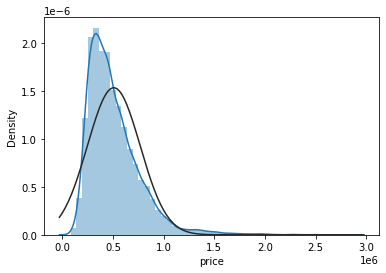

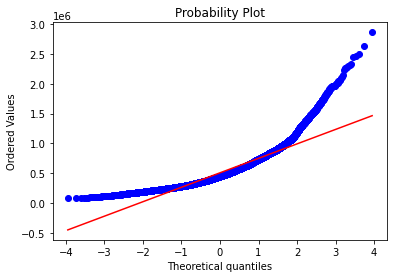

In [62]:
#histogram and normal probability plot
sns.distplot(df['price'], fit=norm);
fig = plt.figure()

res = stats.probplot(df['price'], plot=plt)

# our sales price histogram is positively skewed and has a high peak
# Our QQ-plot shows that we have heavy tails with right skew

In [63]:
#skewness and kurtosis
print("Skewness: %f" % df['price'].skew())
print("Kurtosis: %f" % df['price'].kurt())

# price is highly right skewed
# very positive kurtosis, indicating lots in the tails. We can see those tails in the right skew.

Skewness: 1.825966
Kurtosis: 5.926294


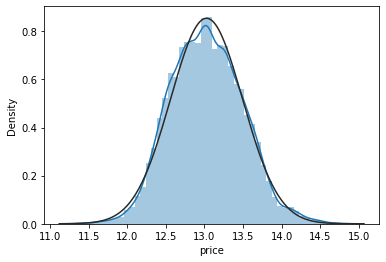

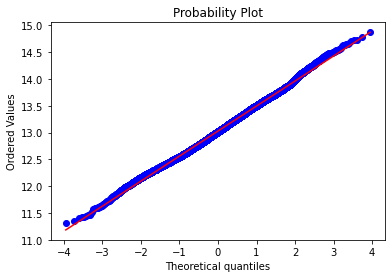

In [64]:
# log transform our target price to improve normality of distribution
df_target_log = np.log(df['price'])

#histogram and normal probability plot
sns.distplot(df_target_log, fit=norm);
fig = plt.figure()
res = stats.probplot(df_target_log, plot=plt)

# Our target price is more normally distributed when log transformed, so we'll be doing that


## Create Holdout Set

We need to separate our holdout data before any further processing.

The reasons for this are:

    * We will standardize our continuous variables, and you should standardize only on your train set and apply that to your test set.
    * We will be feature engineering on our train set, and applying that later to our test set. We cannot have our test set data leak into our engineered features.

Bin items as in here: https://michaeljsanders.com/2017/03/24/stratify-continuous-variable.html

In [65]:
y = pd.DataFrame(np.log(df['price']))
# get min and max for binning
y.describe()

,price
count,17566.000000
mean,13.026610
std,0.467210
min,11.317178
25%,12.692271
50%,13.015731
75%,13.346565
max,14.867588


In [66]:
# I enter the min price, max price, and how many bins I want
bins = np.linspace(11.317178, 14.867588, 5)

# numpy sorts the indices into the proper bins based on value of y
y_binned = np.digitize(y, bins)

In [67]:
# set our random seed for the notebook. We could randomize this each time the notebook is run,
# but ultimately we want all of our train/test splits to use the same data
randomstate = 30785

# creating our train/validation sets and our test sets
train_data, holdout, y_train, y_test = train_test_split(df, y, test_size=0.15, random_state=randomstate, stratify=y_binned)

# reset indices to prevent any index mismatches
train_data.reset_index(inplace=True)
train_data.drop('index', axis=1, inplace=True)

holdout.reset_index(inplace=True)
holdout.drop('index', axis=1, inplace=True)

y_train.reset_index(inplace=True, drop=True)
y_test.reset_index(inplace=True, drop=True)

## Feature Engineering

We're going to do some target-encoded feature engineering on our data set, using additive smoothing based on this article by Max Halford https://maxhalford.github.io/blog/target-encoding/

Using this method we'll add features for:
   * smoothed zip code
   * smoothed year
   * smoothed month sold
   * smoothed latitude
   * smoothed longitude
   * lat/long zone as function of smoothed lat and smoothed long

This feature engineering is the primary reason that we chose to separate our holdout set before any other processing. We cannot, under any circumstances, use the test data to inform our train set features!

In [68]:
# Adding target encoding, which we will opt to try instead of one-hot with a few models

# get size of training data
num_of_samples = train_data.shape[0]

# determining minimum number of samples for zip and month to use their
# own mean rather than expanding into the full data set mean 
zip_samples = num_of_samples/train_data['zipcode'].unique().shape[0]
month_samples = num_of_samples/train_data['month_sold'].unique().shape[0]

# create smooth additive encoded variables for zipcode, year built, and monthsold
train_data['zip_smooth'] = calc_smooth_mean(train_data, 'zipcode', 'price', zip_samples, train_data)
train_data['year_smooth'] = calc_smooth_mean(train_data, 'yr_built', 'price', 300, train_data)
train_data['month_smooth'] = calc_smooth_mean(train_data, 'month_sold', 'price', month_samples, train_data)

# Create a wider lat and long zone to calculate an area mean
train_data['lat_zone'] = round(train_data['lat'], 2)
train_data['long_zone'] = round(train_data['long'], 2)

# determing min number samples for lat and long mean
lat_samples = num_of_samples/train_data['lat_zone'].unique().shape[0]
long_samples = num_of_samples/train_data['long_zone'].unique().shape[0]

# calculate smooth mean variables for lat and long, then create an interactive variable describing both together
train_data['lat_smooth'] = calc_smooth_mean(train_data, 'lat_zone', 'price', lat_samples, train_data)
train_data['long_smooth'] = calc_smooth_mean(train_data, 'long_zone', 'price', long_samples, train_data)
train_data['lat_long'] = (np.sqrt(train_data['lat_smooth']) + np.sqrt(train_data['long_smooth']))

## Correlations/Multicollinearity

Time to check and remove any features with high collinearity.

In [69]:
'''# look for multicollinearity of features
fig, ax = plt.subplots(figsize=(20, 20))

sns.heatmap(train_data.corr(), center=0, annot=True, fmt=".2f", 
           vmin=-1, vmax=1, cbar_kws={"shrink": .8}, square=True)

# title
plt.title('PEARSON CORRELATION MATRIX', fontsize=18)

plt.show()'''

'# look for multicollinearity of features\nfig, ax = plt.subplots(figsize=(20, 20))\n\nsns.heatmap(train_data.corr(), center=0, annot=True, fmt=".2f", \n           vmin=-1, vmax=1, cbar_kws={"shrink": .8}, square=True)\n\n# title\nplt.title(\'PEARSON CORRELATION MATRIX\', fontsize=18)\n\nplt.show()'

In [70]:
train_data.corr()

,price,id,orig_price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,renovated,zipcode,lat,long,sqft_living15,sqft_lot15,time_series,month_sold,zip_rank,median_zip,zip_smooth,year_smooth,month_smooth,lat_zone,long_zone,lat_smooth,long_smooth,lat_long
price,1.000000,0.006914,0.998227,0.289198,0.435552,0.613020,0.043558,0.252225,0.041082,0.248481,0.061749,0.620641,0.509028,0.242965,0.006495,0.106841,-0.033761,0.412263,0.020574,0.546501,0.035022,0.048362,-0.002566,0.722707,0.774564,0.751311,0.239593,0.065375,0.412240,0.020651,0.638126,0.237166,0.644821
id,0.006914,1.000000,0.007366,0.011865,0.031574,0.030971,-0.047526,0.019469,-0.006417,0.023269,-0.032402,0.040693,0.035974,-0.005182,0.041233,-0.015191,-0.039323,-0.008837,0.085748,0.037087,-0.053271,-0.009174,-0.022434,0.029200,0.011799,0.012478,0.025047,0.001698,-0.008591,0.085724,0.007905,-0.001343,0.008277
orig_price,0.998227,0.007366,1.000000,0.289118,0.434540,0.612087,0.043319,0.251017,0.042259,0.249259,0.058154,0.619130,0.508110,0.242839,0.006925,0.105455,-0.033914,0.411325,0.020076,0.545991,0.034587,-0.004683,-0.021081,0.721310,0.773665,0.749867,0.239033,0.036174,0.411286,0.020162,0.636927,0.236846,0.643646
bedrooms,0.289198,0.011865,0.289118,1.000000,0.506777,0.619500,0.198269,0.162439,-0.030254,0.036361,0.025757,0.325328,0.491849,0.283997,0.158989,0.015861,-0.165242,-0.032901,0.159496,0.390580,0.144155,0.008545,-0.007241,0.060318,0.084460,0.071409,0.024766,0.004830,-0.032777,0.159335,0.006991,0.074426,0.032193
bathrooms,0.435552,0.031574,0.434540,0.506777,1.000000,0.713108,-0.007654,0.510068,-0.008216,0.087129,-0.135639,0.602864,0.633649,0.212006,0.529698,0.041154,-0.212401,-0.002066,0.254072,0.529139,-0.011394,0.028350,0.007852,0.187982,0.198092,0.175354,0.287008,0.022635,-0.002170,0.254235,0.111798,0.147109,0.151429
sqft_living,0.613020,0.030971,0.612087,0.619500,0.713108,1.000000,0.219363,0.349265,-0.011465,0.160931,-0.060787,0.689319,0.839454,0.380960,0.328644,0.037696,-0.203592,0.038651,0.263062,0.734109,0.167289,0.023092,0.008136,0.253545,0.280238,0.260115,0.206619,0.016874,0.038596,0.263128,0.146176,0.183658,0.194421
sqft_lot,0.043558,-0.047526,0.043319,0.198269,-0.007654,0.219363,1.000000,-0.326714,0.045221,0.060040,0.119905,0.075171,0.176351,0.096925,-0.033404,-0.004140,-0.270597,-0.125177,0.255618,0.267611,0.772073,0.005917,-0.003533,-0.118303,-0.036585,-0.048706,-0.388987,-0.007051,-0.124874,0.255692,-0.216790,0.068778,-0.166452
floors,0.252225,0.019469,0.251017,0.162439,0.510068,0.349265,-0.326714,1.000000,0.009354,-0.009405,-0.271712,0.464534,0.549087,-0.302376,0.498549,0.000525,-0.066232,0.021744,0.150446,0.278542,-0.273691,0.021175,0.010255,0.170046,0.146065,0.134075,0.497715,0.023145,0.021305,0.150162,0.140599,0.059098,0.144958
waterfront,0.041082,-0.006417,0.042259,-0.030254,-0.008216,-0.011465,0.045221,0.009354,1.000000,0.226963,0.012956,-0.012380,-0.010368,-0.003100,-0.027570,0.051635,0.005840,-0.022381,-0.035384,0.008335,0.099766,-0.006472,-0.002409,0.006346,0.008725,0.016051,0.000498,-0.003223,-0.022152,-0.035532,-0.016444,0.011180,-0.010481
view,0.248481,0.023269,0.249259,0.036361,0.087129,0.160931,0.060040,-0.009405,0.226963,1.000000,0.038161,0.143404,0.053034,0.200937,-0.082977,0.060798,0.102399,0.028690,-0.088683,0.202295,0.071912,-0.007924,-0.011091,0.090025,0.094153,0.105096,-0.010065,-0.008828,0.028806,-0.088785,0.088346,0.083383,0.107788


In [71]:
#Get our list of highly correlated feature pairs with following steps:

# save correlation matrix as a new data frame
# converts all values to absolute value
# stacks the row:column pairs into a multindex
# reset the index to set the multindex to seperate columns
# sort values. 0 is the column automatically generated by the stacking
df_correlations = train_data.corr().abs().stack().reset_index().sort_values(0, ascending=False)

# zip the variable name columns in a new column named "pairs"
df_correlations['pairs'] = list(zip(df_correlations.level_0, df_correlations.level_1))

# set index to pairs
df_correlations.set_index(['pairs'], inplace = True)

# rename our results column to correlation
df_correlations.rename(columns={0: "correlation"}, inplace=True)

# Drop 1:1 correlations to get rid of self pairs
df_correlations.drop(df_correlations[df_correlations['correlation'] == 1.000000].index, inplace=True)

# view pairs above 70% correlation and below 90% correlation (engineered features will correlate with each other above 95%)
df_correlations[(df_correlations.correlation>.75) & (df_correlations.correlation<.95)]


,level_0,level_1,correlation
pairs,,,
"(zip_rank, median_zip)",zip_rank,median_zip,0.941620
"(median_zip, zip_rank)",median_zip,zip_rank,0.941620
"(zip_smooth, zip_rank)",zip_smooth,zip_rank,0.934034
"(zip_rank, zip_smooth)",zip_rank,zip_smooth,0.934034
"(lat_smooth, lat_long)",lat_smooth,lat_long,0.931188
"(lat_long, lat_smooth)",lat_long,lat_smooth,0.931188
"(sqft_above, sqft_living)",sqft_above,sqft_living,0.839454
"(sqft_living, sqft_above)",sqft_living,sqft_above,0.839454
"(lat_smooth, zip_rank)",lat_smooth,zip_rank,0.818402


median_zip, zip_rank and orig_price are dummy variables that we won't be using, so we can ignore correlations using those for now.

We drop sqft_above and sqft_lot15

In [72]:
# drop multicollinear features and unneeded features
train_data.drop(['id', 'zip_rank', 'median_zip', 'sqft_above', 'sqft_lot15'], axis=1, inplace=True)

In [73]:
# Check out our variables correlationg with price
df_correlations = train_data.corr().abs().stack().reset_index().sort_values(0, ascending=False)
df_correlations.loc[df_correlations['level_0'] == 'price'].sort_values(0, ascending=False)

,level_0,level_1,0
0,price,price,1.000000
1,price,orig_price,0.998227
20,price,zip_smooth,0.751311
27,price,lat_long,0.644821
25,price,lat_smooth,0.638126
10,price,grade,0.620641
4,price,sqft_living,0.613020
17,price,sqft_living15,0.546501
3,price,bathrooms,0.435552
15,price,lat,0.412263


It looks like zip code works better than the lat/long zones I made. We should also note here that zip and lat/long descriptors are all highly correlated, so we should consider if we need to include all of them in our model or just the best one (zipcode)

We can get a sense of the most important features to our price from our correlation table. Zipcode as a plain variable does not correlate, which makes sense, because without some sort of transformation it is an arbitrary unordered number. We can see how transformed as zip_smooth, median_zip, or zip_rank it becomes the MOST important contributor to price. We can see here that big contributors to price include:
    
    * zip code (in some altered form, not as arbitrary number)
    * grade
    * sqft_living
    * bathrooms

## Categoricals

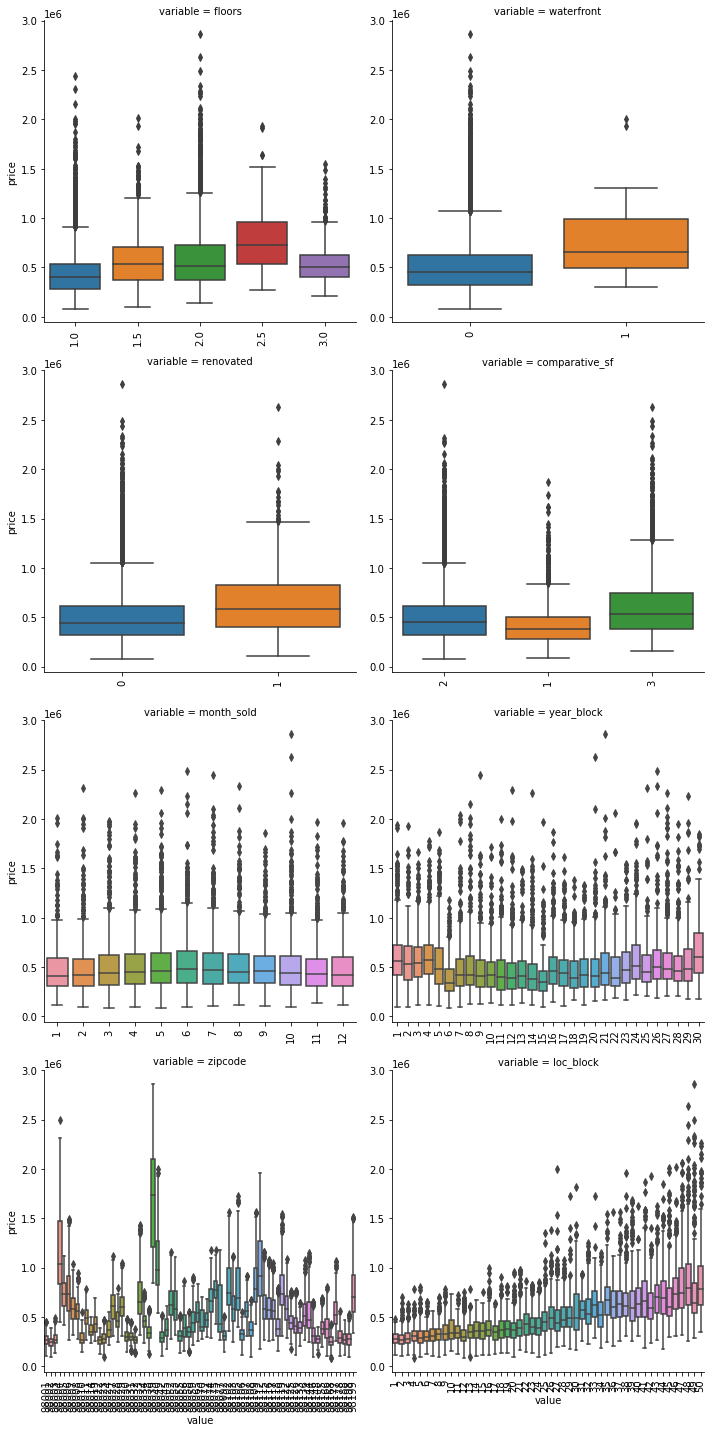

In [74]:
categoricals = ['floors', 'waterfront', 'renovated', 'comparative_sf', 'month_sold', 'yr_built', 'zipcode', 'lat_long'] #

# make our categorical data frame to work with
df_categoricals = train_data[categoricals]

# binning our year built bins
df_categoricals["year_block"] = pd.qcut(df_categoricals['yr_built'], q=30, labels=np.array(range(1,30+1)))

# binning our latitude bins
df_categoricals["loc_block"] = pd.qcut(df_categoricals['lat_long'], q=50, labels=np.array(range(1,50+1)))

# dropping the original categories we just binned
df_categoricals.drop(['yr_built', 'lat_long'], axis=1, inplace=True)

# telling Pandas that these columns are categoricals
for item in df_categoricals.columns:
    df_categoricals[item] = df_categoricals[item].astype('category')

# temporarily adding price to our dataframe so that we can do some visualizations    
df_categoricals['price'] = train_data['price']

# plot our categoricals as box plots vs price
def boxplot(x, y, **kwargs):
    sns.boxplot(x=x, y=y)
    x=plt.xticks(rotation=90)

#visualization categories
categorical=['floors', 'waterfront', 'renovated', 'comparative_sf', 'month_sold', 'year_block', 'zipcode', 'loc_block']
f = pd.melt(df_categoricals, id_vars=['price'], value_vars=categorical)
g = sns.FacetGrid(f, col="variable",  col_wrap=2, sharex=False, sharey=False, size=5)
g = g.map(boxplot, "value", "price")

df_categoricals.drop('price', axis=1, inplace=True)

In [75]:
# make a processed bins file for use with linear regression
# We're making TWO categorical sets. One is high one hot encoding. One is low one hot encoding, and the 
# categoricals in that one will be target encoded as continuous instead

high_one_hot_cat =  ['floors', 'waterfront', 'renovated','comparative_sf', 'zipcode', 'month_sold', 'year_block', 'loc_block']
low_one_hot_cat =  ['floors', 'waterfront', 'renovated','comparative_sf']

df_cats_high_one_hot = pd.get_dummies(df_categoricals[high_one_hot_cat], prefix=high_one_hot_cat, drop_first=True)
df_cats_low_one_hot = pd.get_dummies(df_categoricals[low_one_hot_cat], prefix=low_one_hot_cat, drop_first=True)

## Continuous

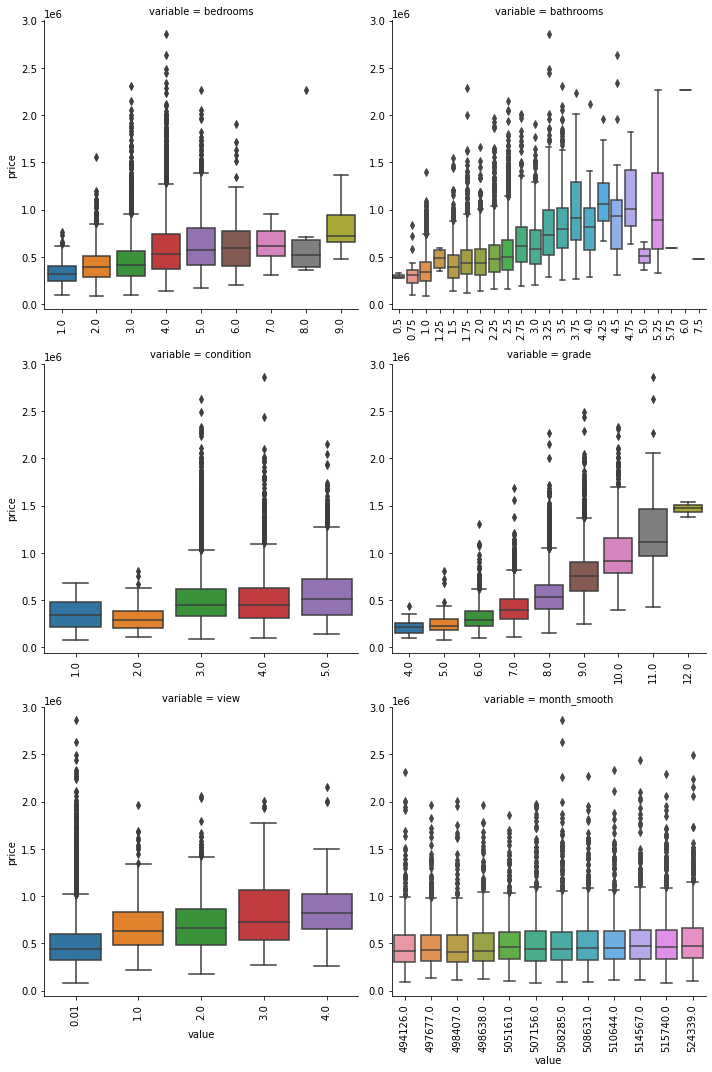

In [76]:
continuous = ['sqft_living', 'sqft_living15', 'sqft_lot', 'sqft_basement', 'view', 'bedrooms', 'bathrooms', 'condition', 'grade', 'zip_smooth', 'year_smooth', 'month_smooth', 'lat_long'] #'floors',  

# make our continuous frame to work with
x_continuous = train_data[continuous]
x_continuous['price'] = train_data['price']

# plot our smaller choice continuous as box plots vs price
small_cont = ['bedrooms', 'bathrooms', 'condition', 'grade', 'view', 'month_smooth'] 

def boxplot(x, y, **kwargs):
    sns.boxplot(x=x, y=y)
    x=plt.xticks(rotation=90)

f = pd.melt(x_continuous, id_vars=['price'], value_vars=small_cont)
g = sns.FacetGrid(f, col="variable",  col_wrap=2, sharex=False, sharey=False, size=5)
g = g.map(boxplot, "value", "price")

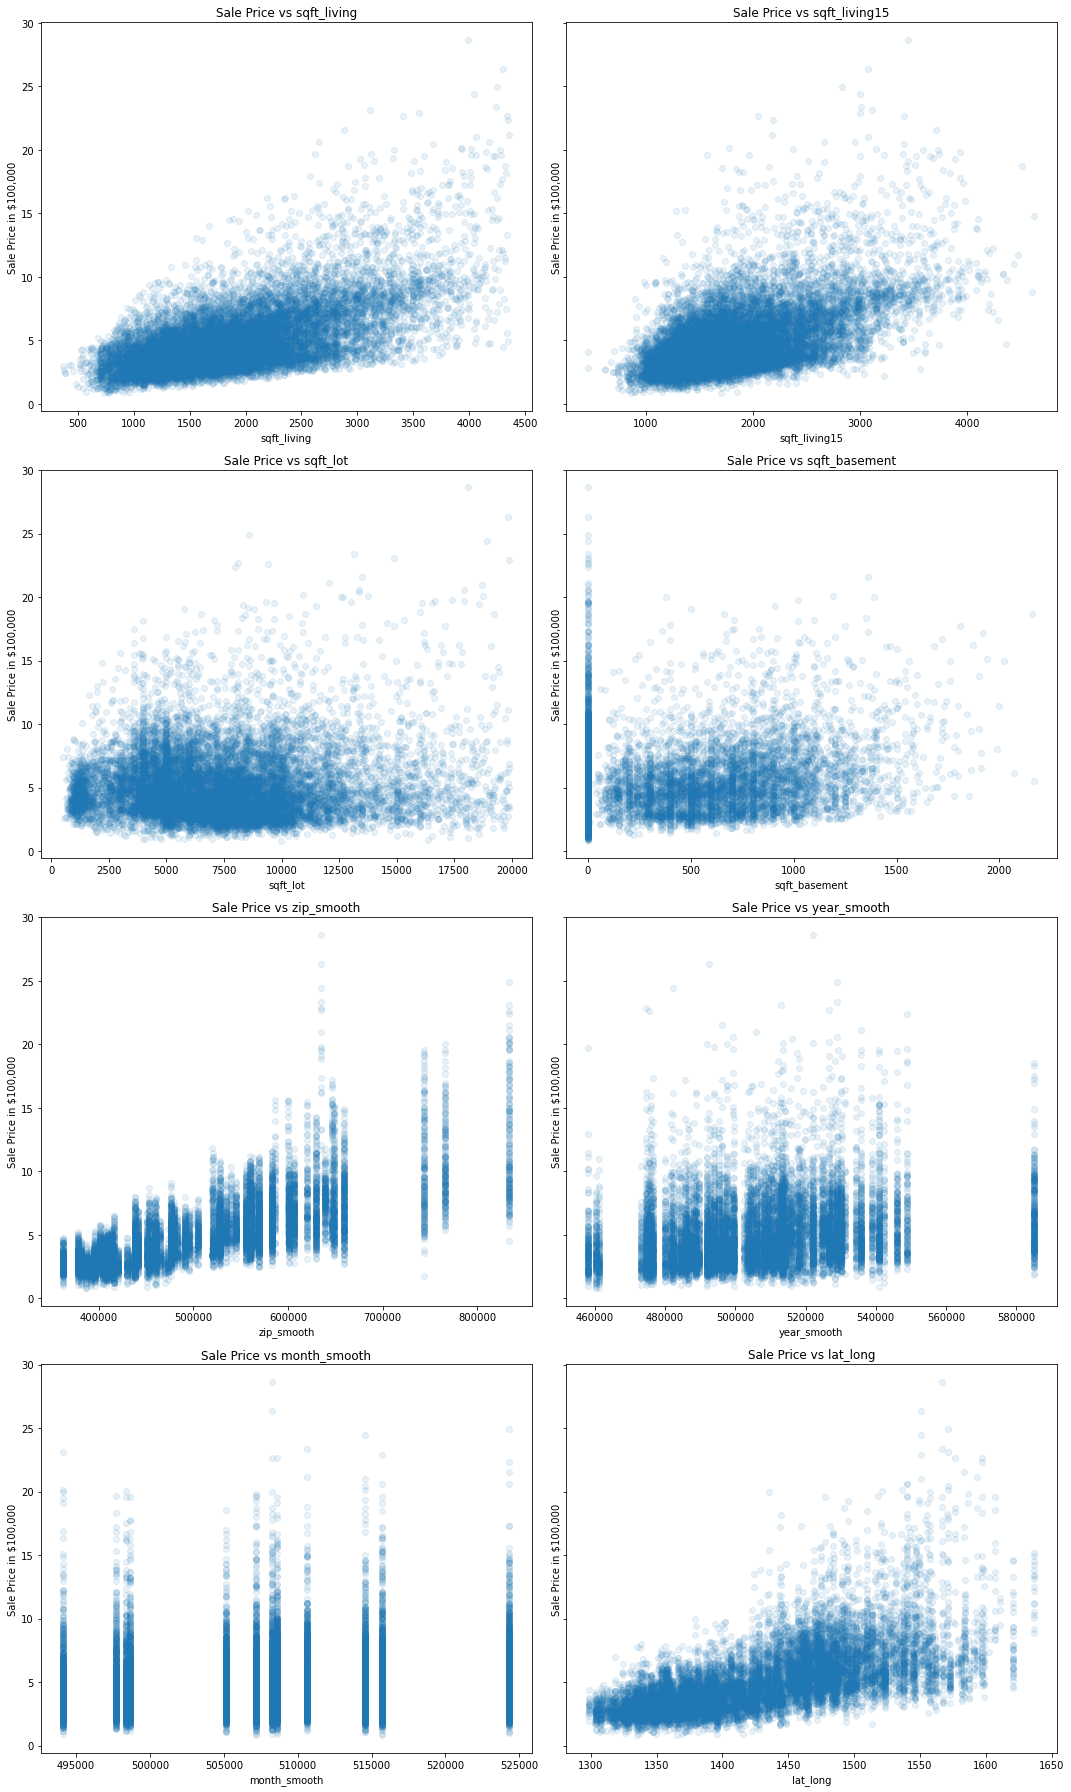

In [77]:
# plot our larger continuous as scatter plots vs price
large_cont = ['sqft_living', 'sqft_living15', 'sqft_lot', 'sqft_basement', 'zip_smooth', 'year_smooth', 'month_smooth', 'lat_long']

fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(15,25), sharey=True)

for ax, column in zip(axes.flatten(), large_cont):
    ax.scatter(x_continuous[column], x_continuous['price']/100000, label=column, alpha=.1)
    ax.set_title(f'Sale Price vs {column}')
    ax.set_xlabel(column)
    ax.set_ylabel('Sale Price in $100,000')

fig.tight_layout()

x_continuous.drop('price', axis=1, inplace=True)

    * sqft_living, sqft_living15, zip_smooth, lat_long, sqft_basement(when present) have a very strong visual relationship with price
    * sqft_lot do not appear to have a strong relationship with price
    * year_smooth and month_smooth are unclear, we will investigate further

Fun fact - "grade" was not well defined in the features list. I looked it up and found that grade is "	Classification by construction quality which refers to the types of materials used and the quality of workmanship. Buildings of better quality (higher grade) cost more to build per unit of measure and command higher value." So, it's the quality of building materials, and DEFINITELY worth keeping in our model.

## Looking for polynomial relationships

In [78]:
'''# Checking out our mean sales price for year built scattered versus price shows a polynomial relationship

yearly_prices = train_data.groupby('yr_built')['price'].mean()

plt.scatter(yearly_prices.index, yearly_prices)
plt.title("Linearity check")
plt.xlabel('year built')
plt.ylabel('sales price')
plt.show()'''

'# Checking out our mean sales price for year built scattered versus price shows a polynomial relationship\n\nyearly_prices = train_data.groupby(\'yr_built\')[\'price\'].mean()\n\nplt.scatter(yearly_prices.index, yearly_prices)\nplt.title("Linearity check")\nplt.xlabel(\'year built\')\nplt.ylabel(\'sales price\')\nplt.show()'

Seems like year built might have a polynomial relationship with price

In [79]:
'''# Checking out our mean sales price for month sold scattered versus price shows a polynomial relationship
monthly_prices = train_data.groupby('month_sold')['price'].mean()

plt.scatter(monthly_prices.index, monthly_prices)
plt.title("Linearity check")
plt.xlabel('month sold')
plt.ylabel('sales price')
plt.show()'''

'# Checking out our mean sales price for month sold scattered versus price shows a polynomial relationship\nmonthly_prices = train_data.groupby(\'month_sold\')[\'price\'].mean()\n\nplt.scatter(monthly_prices.index, monthly_prices)\nplt.title("Linearity check")\nplt.xlabel(\'month sold\')\nplt.ylabel(\'sales price\')\nplt.show()'

Month sold may also have a polynomial relationship

In [80]:
'''# Checking out our mean sales price for longitude does not show a polynomial relationship
long_prices = train_data.groupby('lat_long')['price'].mean()

plt.scatter(long_prices.index, long_prices)
plt.title("Linearity check")
plt.xlabel('long')
plt.ylabel('sales price')
plt.show()'''

'# Checking out our mean sales price for longitude does not show a polynomial relationship\nlong_prices = train_data.groupby(\'lat_long\')[\'price\'].mean()\n\nplt.scatter(long_prices.index, long_prices)\nplt.title("Linearity check")\nplt.xlabel(\'long\')\nplt.ylabel(\'sales price\')\nplt.show()'

There does not appear to be a polynomial relationship

In [81]:
'''# Checking out our mean sales price for grade shows a polynomial relationship
grade_prices = train_data.groupby('grade')['price'].mean()

plt.scatter(grade_prices.index, grade_prices)
plt.title("Linearity check")
plt.xlabel('long')
plt.ylabel('sales price')
plt.show()'''

'# Checking out our mean sales price for grade shows a polynomial relationship\ngrade_prices = train_data.groupby(\'grade\')[\'price\'].mean()\n\nplt.scatter(grade_prices.index, grade_prices)\nplt.title("Linearity check")\nplt.xlabel(\'long\')\nplt.ylabel(\'sales price\')\nplt.show()'

Grade appears to have a polynomial relationship

In [82]:
'''# Checking out our mean sales price for grade shows a polynomial relationship
grade_prices = train_data.groupby('sqft_living')['price'].mean()

plt.scatter(grade_prices.index, grade_prices)
plt.title("Linearity check")
plt.xlabel('square footage')
plt.ylabel('sales price')
plt.show()'''

'# Checking out our mean sales price for grade shows a polynomial relationship\ngrade_prices = train_data.groupby(\'sqft_living\')[\'price\'].mean()\n\nplt.scatter(grade_prices.index, grade_prices)\nplt.title("Linearity check")\nplt.xlabel(\'square footage\')\nplt.ylabel(\'sales price\')\nplt.show()'

Square foot living may have a polynomial relationship

## Finding Interactions

I wrote a function which finds all of the feature combinations possible in our dataset. Then for each combination, the function runs a linear regression with cross validation on 5 folds and gets the r^2 score for the regression including that feature combination. All scores are recorded and r^2 score improvement is assessed, with the resulting table giving the increase in model improvement from a feature combo. 

In [83]:
# running our function on our continuous variables to look for improvement
# our R2 is much lower for model base score because we aren't including our categorical variables in this improvement assessment

scoring_df = test_feature_combinations(y_train, x_continuous)

Model base score is  0.8223
sqft_living sqft_living15 0.8264
sqft_living sqft_lot 0.8228
sqft_living sqft_basement 0.8233
sqft_living view 0.8239
sqft_living bedrooms 0.8234
sqft_living bathrooms 0.8229
sqft_living condition 0.8223
sqft_living grade 0.8239
sqft_living zip_smooth 0.8244
sqft_living year_smooth 0.8223
sqft_living month_smooth 0.8223
sqft_living lat_long 0.8242
sqft_living15 sqft_lot 0.8225
sqft_living15 sqft_basement 0.8231
sqft_living15 view 0.8229
sqft_living15 bedrooms 0.824
sqft_living15 bathrooms 0.824
sqft_living15 condition 0.8225
sqft_living15 grade 0.8248
sqft_living15 zip_smooth 0.8252
sqft_living15 year_smooth 0.8226
sqft_living15 month_smooth 0.8223
sqft_living15 lat_long 0.8249
sqft_lot sqft_basement 0.8232
sqft_lot view 0.8225
sqft_lot bedrooms 0.823
sqft_lot bathrooms 0.8224
sqft_lot condition 0.8229
sqft_lot grade 0.8223
sqft_lot zip_smooth 0.8232
sqft_lot year_smooth 0.8226
sqft_lot month_smooth 0.8224
sqft_lot lat_long 0.8233
sqft_basement view 0.8227
s

In [84]:
# showing our improvement scores for our interactions

scoring_df.sort_values('improvement', ascending=False)

,feature1,feature2,scores,improvement
74,zip_smooth,lat_long,0.8311,0.0088
0,sqft_living,sqft_living15,0.8264,0.0041
68,grade,zip_smooth,0.8255,0.0032
71,grade,lat_long,0.8253,0.0030
19,sqft_living15,zip_smooth,0.8252,0.0029
...,...,...,...,...
47,view,year_smooth,0.8223,0.0000
48,view,month_smooth,0.8223,0.0000
55,bedrooms,month_smooth,0.8223,0.0000
77,month_smooth,lat_long,0.8223,0.0000


We see there might be a relationship between square footage and our zip code. This makes sense because the size of the house is differently priced depending on location, as we saw in our visualizations earlier.

In [85]:
x_continuous['sqft-zip'] = np.sqrt(x_continuous['sqft_living'] * x_continuous['zip_smooth'])

# Cleaning Final Data

## Standardize and Transform

In [86]:
# check out our histograms to see if we should transform our data before scaling

# x_continuous.hist(figsize=(18,15), bins='auto');

We will log transform our data, and standardize our continuous inputs.

In [87]:
# log transform
log_continuous = np.log(x_continuous)

# standardize all of our values with scikit-learn StandardScaler
scaler = StandardScaler()

scaled_continuous = pd.DataFrame(scaler.fit_transform(log_continuous),columns = log_continuous.columns)
scaled_continuous.head(5)

# Our scaled and transformed continuous features

# scaled_continuous.hist(figsize=(18,15), bins='auto');

,sqft_living,sqft_living15,sqft_lot,sqft_basement,view,bedrooms,bathrooms,condition,grade,zip_smooth,year_smooth,month_smooth,lat_long,sqft-zip
0,-0.338332,-0.337570,0.107560,1.110815,-0.272062,-0.236364,0.443810,-0.63824,0.576041,1.040459,0.518379,-0.165046,1.272325,0.145417
1,-1.563715,-0.704973,-1.241742,-0.793738,-0.272062,-1.687787,-1.690049,-0.63824,-0.446595,0.709533,0.669393,-0.165046,0.449269,-1.001542
2,1.647742,1.918381,-0.960468,1.258800,-0.272062,0.793437,1.606436,-0.63824,1.478070,0.631898,1.232827,0.737335,0.231924,1.618596
3,0.367942,0.458728,-1.562196,0.826393,-0.272062,-0.236364,0.721053,-0.63824,0.576041,0.838738,1.644180,-1.218650,0.902829,0.646259
4,-0.692638,-0.893054,-2.931895,1.016239,-0.272062,-1.687787,0.971849,-0.63824,0.576041,-0.657489,-0.347972,0.878970,-0.422877,-0.840375


We're ready to make our final continuous data set. At this point we will make TWO continuous sets, because one of the objectives of this notebook is to study *one-hot encoding* versus *mean target encoding*. So we have one data set for our high one-hot encoding features, and one data set for our mean target encoding features. Later in the notebook we will compare these two features sets in models.

In [88]:
# make a processed bins file for use with linear regression

# our categories for high one-hot encoding and low one-hot encoding
high_one_hot_cont =  ['sqft_living', 'sqft_living15', 'sqft_lot', 'sqft_basement', 'view', 'bedrooms', 'bathrooms', 'grade', 'condition', 'sqft-zip']
low_one_hot_cont =  ['sqft_living', 'sqft_living15', 'sqft_lot', 'sqft_basement', 'view', 'bedrooms', 'bathrooms', 'grade', 'condition', 'zip_smooth', 'year_smooth', 'month_smooth', 'lat_long', 'sqft-zip']  

df_cont_high_one_hot = scaled_continuous[high_one_hot_cont]
df_cont_low_one_hot = scaled_continuous[low_one_hot_cont]

## Add polynomial features

Now we will add our polynomial features on our low-one-hot set (in the high-one-hot set, these are categoricals)

In [89]:
'''# group by average month sold mean to see relationship
y = train_data.groupby('month_sold')['price'].mean()
plot_polys(y, "Month", "Month Sold Mean")'''

'# group by average month sold mean to see relationship\ny = train_data.groupby(\'month_sold\')[\'price\'].mean()\nplot_polys(y, "Month", "Month Sold Mean")'

We'll add month sold as a second degree polynomial.

In [90]:
'''# group by average year built mean to see relationship
y = train_data.groupby('yr_built')['price'].mean()
plot_polys(y, "Year Sold", "Year Sold Mean")'''

'# group by average year built mean to see relationship\ny = train_data.groupby(\'yr_built\')[\'price\'].mean()\nplot_polys(y, "Year Sold", "Year Sold Mean")'

We'll add year built as a second degree polynomial.

In [91]:
'''# group by grade mean to see relationship
y = train_data.groupby('grade')['price'].mean()
plot_polys(y,'Grade', "Grade Mean")'''

'# group by grade mean to see relationship\ny = train_data.groupby(\'grade\')[\'price\'].mean()\nplot_polys(y,\'Grade\', "Grade Mean")'

We will express this as a second degree polynomial.

In [92]:
'''# group by grade mean to see relationship
y = train_data.groupby('sqft_living')['price'].mean()
plot_polys(y,'Square Footage', "Square Footage Mean")'''

'# group by grade mean to see relationship\ny = train_data.groupby(\'sqft_living\')[\'price\'].mean()\nplot_polys(y,\'Square Footage\', "Square Footage Mean")'

This looks better expressed with a third degree polynomial

In [93]:
'''# group by grade mean to see relationship
y = train_data.groupby('sqft_lot')['price'].mean()
plot_polys(y,'Lot Square Footage', "Lot Square Footage Mean")'''

'# group by grade mean to see relationship\ny = train_data.groupby(\'sqft_lot\')[\'price\'].mean()\nplot_polys(y,\'Lot Square Footage\', "Lot Square Footage Mean")'

No clear relationship

In [94]:
# adding our chosen polynomial features

def create_polynomial_array(data, column, num_features):
    values = data[column]
    poly_array = np.array(values)
    poly_array = poly_array.reshape(-1,1)
    poly_fit = PolynomialFeatures(degree=num_features, include_bias=False)
    fit_features = poly_fit.fit_transform(poly_array)
    poly_df = pd.DataFrame(fit_features)
    return poly_df

month_poly = create_polynomial_array(df_cont_low_one_hot, 'month_smooth',2)
year_poly = create_polynomial_array(df_cont_low_one_hot, 'year_smooth', 2)
grade_poly = create_polynomial_array(df_cont_low_one_hot, 'grade', 2)
sq_ft_poly = create_polynomial_array(df_cont_low_one_hot, 'sqft_living', 3)

df_cont_low_one_hot['month1'] = month_poly[1]
df_cont_low_one_hot['grade1'] = grade_poly[1]
df_cont_high_one_hot['grade1'] = grade_poly[1]
df_cont_low_one_hot['year1'] = year_poly[1]

df_cont_low_one_hot['sqft_living3'] = sq_ft_poly[2]
df_cont_high_one_hot['sqft_living3'] = sq_ft_poly[2]

df_cont_low_one_hot['sqft_living2'] = sq_ft_poly[1]
df_cont_high_one_hot['sqft_living2'] = sq_ft_poly[1]

## Process Test Set

We now need to process our holdout in the same way we processed our training set.

In [95]:
# apply target encoding to test data, using train data to map

# create smooth additive encoded variables for zipcode, year built, and monthsold
holdout['zip_smooth'] = calc_smooth_mean(train_data, 'zipcode', 'price', zip_samples, holdout)
holdout['year_smooth'] = calc_smooth_mean(train_data, 'yr_built', 'price', 300, holdout)
holdout['month_smooth'] = calc_smooth_mean(train_data, 'month_sold', 'price', month_samples, holdout)

# Create a wider lat and long zone to calculate an area mean
holdout['lat_zone'] = round(holdout['lat'], 2)
holdout['long_zone'] = round(holdout['long'], 2)

# calculate smooth mean variables for lat and long, then create an interactive variable describing both together
holdout['lat_smooth'] = calc_smooth_mean(train_data, 'lat_zone', 'price', lat_samples, holdout)
holdout['long_smooth'] = calc_smooth_mean(train_data, 'long_zone', 'price', long_samples, holdout)
holdout['lat_long'] = (np.sqrt(holdout['lat_smooth']) + np.sqrt(holdout['long_smooth']))
holdout.fillna(holdout.mean(), inplace=True)

### Process Categoricals

In [96]:
# Process Holdout Categoricals

holdout_categoricals = holdout[categoricals]

# binning our year built bins
holdout_categoricals["year_block"] = pd.qcut(holdout_categoricals['yr_built'], q=30, labels=np.array(range(1,30+1)))

# binning our latitude bins
holdout_categoricals["loc_block"] = pd.qcut(holdout_categoricals['lat_long'], q=50, labels=np.array(range(1,50+1)))

holdout_categoricals.drop(['yr_built'], axis=1, inplace=True)

# telling Pandas that these columns are categoricals
for item in holdout_categoricals.columns:
    holdout_categoricals[item] = holdout_categoricals[item].astype('category')

# make a processed bins file for use with linear regression
df_cats_high_one_hot_holdout = pd.get_dummies(holdout_categoricals[high_one_hot_cat], prefix=high_one_hot_cat, drop_first=True)
df_cats_low_one_hot_holdout = pd.get_dummies(holdout_categoricals[low_one_hot_cat], prefix=low_one_hot_cat, drop_first=True)

### Process Continuous

In [97]:
# Process Holdout Continuous

holdout_continuous = holdout[continuous]

# add feature interaction
holdout_continuous['sqft-zip'] = np.sqrt(holdout_continuous['sqft_living'] * holdout_continuous['zip_smooth'])

# log transform
log_holdout = np.log(holdout_continuous)

# standard scaler
scaled_holdout_continuous = pd.DataFrame(scaler.transform(log_holdout),columns = log_holdout.columns)

# making our two continuous sets
df_cont_high_one_hot_holdout = scaled_holdout_continuous[high_one_hot_cont]
df_cont_low_one_hot_holdout = scaled_holdout_continuous[low_one_hot_cont]

# adding polynomial features

month_poly = create_polynomial_array(df_cont_low_one_hot_holdout, 'month_smooth',2)
year_poly = create_polynomial_array(df_cont_low_one_hot_holdout, 'year_smooth', 2)
grade_poly = create_polynomial_array(df_cont_low_one_hot_holdout, 'grade', 2)
sq_ft_poly = create_polynomial_array(df_cont_low_one_hot_holdout, 'sqft_living', 3)


df_cont_low_one_hot_holdout['month1'] = month_poly[1]
df_cont_low_one_hot_holdout['grade1'] = grade_poly[1]
df_cont_high_one_hot_holdout['grade1'] = grade_poly[1]
df_cont_low_one_hot_holdout['year1'] = year_poly[1]

df_cont_low_one_hot_holdout['sqft_living3'] = sq_ft_poly[2]
df_cont_high_one_hot_holdout['sqft_living3'] = sq_ft_poly[2]

df_cont_low_one_hot_holdout['sqft_living2'] = sq_ft_poly[1]
df_cont_high_one_hot_holdout['sqft_living2'] = sq_ft_poly[1]

## Create Train/Test Final Set

In [98]:
df_cont_low_one_hot_holdout.isna().sum()

sqft_living      0
sqft_living15    0
sqft_lot         0
sqft_basement    0
view             0
bedrooms         0
bathrooms        0
grade            0
condition        0
zip_smooth       0
year_smooth      0
month_smooth     0
lat_long         0
sqft-zip         0
month1           0
grade1           0
year1            0
sqft_living3     0
sqft_living2     0
dtype: int64

In [99]:
# make our train sets for one-hot encoded and target-encoded categoricals
X_train_onehot = pd.concat([df_cont_high_one_hot, df_cats_high_one_hot], axis=1)
X_train_encoded = pd.concat([df_cont_low_one_hot, df_cats_low_one_hot], axis=1)

# make our test sets for one-hot encoded and target-encoded categoricals
X_test_onehot = pd.concat([df_cont_high_one_hot_holdout, df_cats_high_one_hot_holdout], axis=1)
X_test_encoded = pd.concat([df_cont_low_one_hot_holdout, df_cats_low_one_hot_holdout], axis=1)

test_actual = np.array(np.exp(y_test))

We also need a set of data that is not standardized or log transformed, and a y_set that is not log transformed

In [100]:
# categoricals with first not dropped for tree
boost_train_cats = pd.get_dummies(df_categoricals[high_one_hot_cat], prefix=high_one_hot_cat, drop_first=False)
boost_test_cats= pd.get_dummies(holdout_categoricals[high_one_hot_cat], prefix=high_one_hot_cat, drop_first=False)

# continuous NOT transformed or standardized
boost_train_continuous_onehot = x_continuous[high_one_hot_cont]
boost_holdout_continuous_onehot = holdout_continuous[high_one_hot_cont]

# decision tree regression train and test sets
x_train_onehot_nostand = pd.concat([boost_train_continuous_onehot, boost_train_cats], axis=1)
x_test_onehot_nostand = pd.concat([boost_holdout_continuous_onehot, boost_test_cats], axis=1)


# categoricals with first not dropped for tree
boost_train_cats = pd.get_dummies(df_categoricals[low_one_hot_cat], prefix=low_one_hot_cat, drop_first=False)
boost_test_cats= pd.get_dummies(holdout_categoricals[low_one_hot_cat], prefix=low_one_hot_cat, drop_first=False)

# continuous not transformed or standardized
boost_train_continuous_target = x_continuous[low_one_hot_cont]
boost_holdout_continuous_target = holdout_continuous[low_one_hot_cont]

# decision tree regression train and test sets
x_train_encoded_nostand = pd.concat([boost_train_continuous_target, boost_train_cats], axis=1)
x_test_encoded_nostand = pd.concat([boost_holdout_continuous_target, boost_test_cats], axis=1)

# reset indices to avoid index mismatches
y_train_exp = np.array(np.exp(y_train))
y_test_exp = np.array(np.exp(y_test))

In [101]:
y_train = np.array(y_train)
y_test = np.array(y_test)

## Data Sets Reference

Our final data sets include:

* X_train_onehot, X_test_onehot - train/test split predictors for one-hot sets, standardized and transformed
* X_train_encoded, X_test_encoded - train/test split predictors for encoded sets, standardized and transformed

* x_train_onehot_nostand, x_test_onehot_nostand - train/test split predictors for one-hot sets, standardized and transformed
* x_train_encoded_nostand, x_test_encoded_nostand - train/test split predictors for encoded sets, NOT standardized and transformed

* y_train, y_test - target values for all sets which are log transformed
* y_train_exp, y_test_exp - target values for all sets NOT log transformed

* test_actual - exponentiated y_test prices

# Modeling

We're going to evaluate a few different variations of our linear regression model, as well as a few more complex model types. In order to keep track of our results, we'll be making a dictionary to store our model accuracy results.

In [102]:
# prepare dictionary to store results
models = {}
models['model'] = []
models['method'] = []
models['r2'] = []
models['mae'] = []
models['rmse'] = [] 

In [103]:
# Unless we specify a different model, this is our baseline model
model = LinearRegression()

Our final data sets include:

* X_train_onehot, X_test_onehot - train/test split predictors for one-hot sets
* X_train_encoded, X_test_encoded - train/test split predictors for encoded sets
* y_train, y_test - target values for all sets
* test_actual - exponentiated y_test prices

### Visualizing Base Features via Residuals Map

We can use residuals plots to determine if features are important enough to add to our model. If we regress our target on a predictor, and then plot those residuals against a DIFFERENT predictor, our plot will tell us if the new feature might add to our model.

We're going to add features in order of their correlation with price on our correlation heat map, so our base feature is a transformed zip code because it has the strongest correlation.

We regress our target on zip code (we'll use zip_smooth), then we plot our residuals against total square footage.

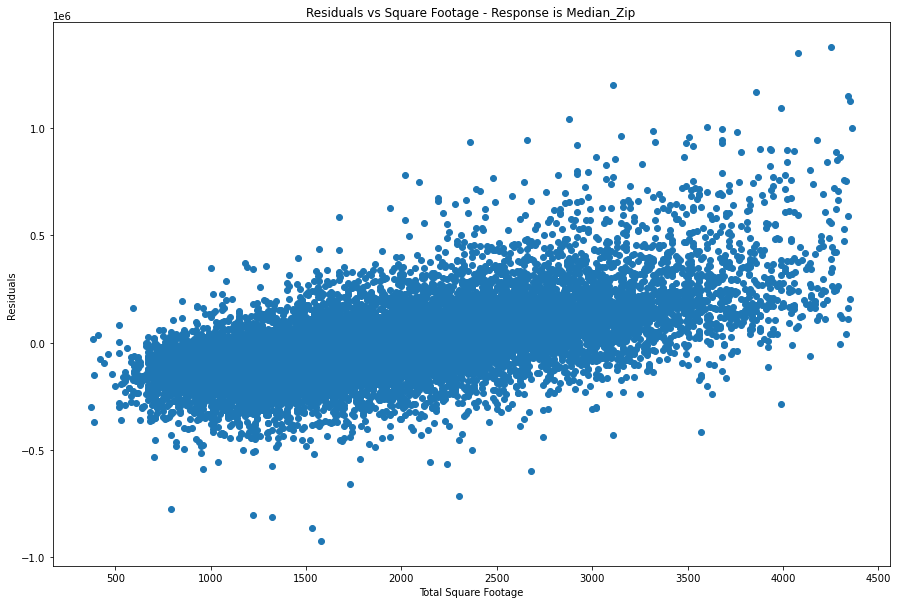

In [104]:
x, y = np.array(df['median_zip']).reshape(-1,1), df['price']
z = np.array(df['sqft_living']).reshape(-1,1)

model = LinearRegression()
model.fit(x, y)

test_predictions = model.predict(x)

residuals = y - test_predictions

fig = plt.figure(figsize=(15,10))

# Add labels for x and y axes
plt.xlabel('Total Square Footage')
plt.ylabel('Residuals')

# Add a title for the plot
plt.title('Residuals vs Square Footage - Response is Median_Zip')


plt.scatter(z, residuals, label="sample");

We can see a clear pattern in our residuals, which tells us that adding square footage will add to our model. Now we know this already from our correlation map, but this visual reinforces that information.

We'll do the same regression on zip code again, this time residuals plotted against grade. Again a relationship can be seen.

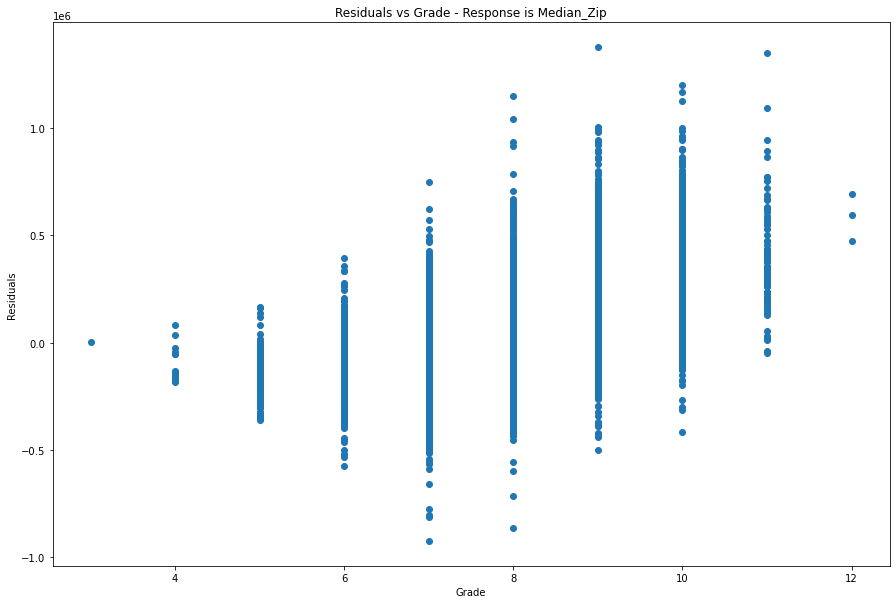

In [105]:
x, y = np.array(df['median_zip']).reshape(-1,1), df['price']
z = np.array(df['grade']).reshape(-1,1)

model.fit(x, y)

test_predictions = model.predict(x)

residuals = y - test_predictions

fig = plt.figure(figsize=(15,10))

# Add labels for x and y axes
plt.xlabel('Grade')
plt.ylabel('Residuals')

# Add a title for the plot
plt.title('Residuals vs Grade - Response is Median_Zip')


plt.scatter(z, residuals, label="sample");

We can see from this graph that Grade has relevance to our model, because the data show a clear pattern. 

Contrast this with yr_built, our lowest correlated feature before we encoded it.

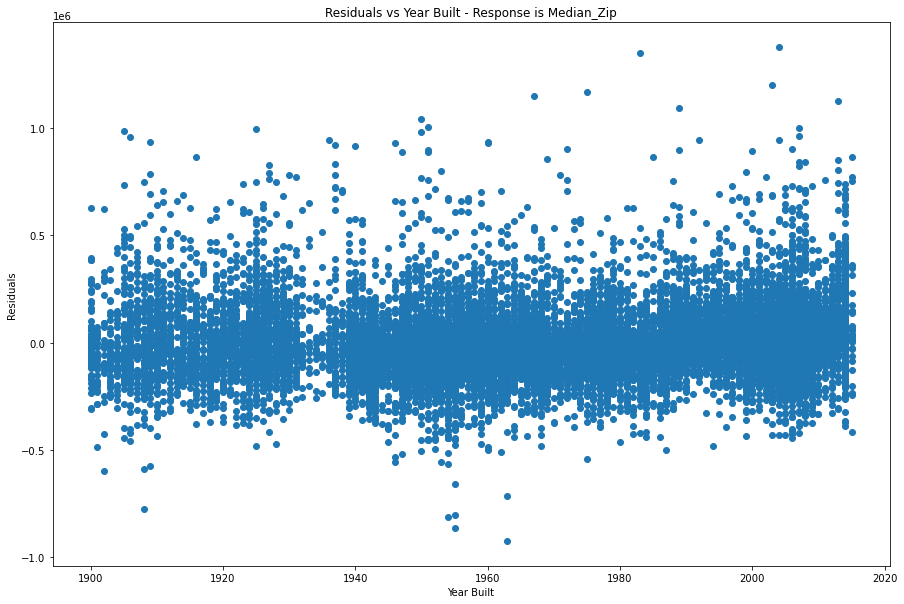

In [106]:
x, y = np.array(df['median_zip']).reshape(-1,1), df['price']
z = np.array(df['yr_built']).reshape(-1,1)

model.fit(x, y)

test_predictions = model.predict(x)

residuals = y - test_predictions

fig = plt.figure(figsize=(15,10))

# Add labels for x and y axes
plt.xlabel('Year Built')
plt.ylabel('Residuals')

# Add a title for the plot
plt.title('Residuals vs Year Built - Response is Median_Zip')

plt.scatter(z, residuals, label="sample");

Our scatter looks like a normal residuals plot, implying that the year built does not add much to our model. There's no strong trend exhibited here. If we can see a pattern when we plot residuals vs a different predictor, it can tell us if a feature might add value to our model.

## One-Hot Encoded Data Set

### Spot Check Models

In [107]:
# Set up baseline models
baseline_models = {
    "LR Base": LinearRegression(),
    "Decision Tree Base": DecisionTreeRegressor(random_state = randomstate),
    "Elastic Net Base": ElasticNet(random_state = randomstate, normalize=True, copy_X=True, tol=1e-3),
    "Extra Trees Base": ExtraTreesRegressor(random_state = randomstate),
    "Gaussian Base": GaussianProcessRegressor(random_state = randomstate, normalize_y=True),
    "Gradient Boosted Base" : GradientBoostingRegressor(random_state = randomstate),
    "KNN Base" : KNeighborsRegressor(),
    "Lars Base" : Lars(random_state = randomstate, copy_X=True, normalize=False),
    "Lasso Base" : Lasso(random_state = randomstate, copy_X=True, tol=1e-3),
    "LinearSVR Base" : LinearSVR(random_state = randomstate),
    "MLPRegressor Base" : MLPRegressor(random_state = randomstate),
    "Bayesian Ridge Base" : BayesianRidge(),
    "Gamma Regressor Base" : GammaRegressor(),
    "Lasso Lars Base" : LassoLars(random_state = randomstate, normalize=False, copy_X=True),
    "Nu SVR Base": NuSVR(),
    "Orthogonal Matching Pursuit Base" : OrthogonalMatchingPursuit(),
    "Passive Aggressive Base" : PassiveAggressiveRegressor(random_state = randomstate),
    "RANSAC Base" : RANSACRegressor(random_state = randomstate),
    "Ridge Base" : Ridge(random_state = randomstate, tol=1e-3, normalize=False),
    "SVR Base" : SVR(),
    "XGB Regressor Base" : xgb.XGBRegressor(random_state = randomstate),
    "Ada Boost Base" : AdaBoostRegressor(random_state=randomstate),
    "SGD Regressor" : SGDRegressor(random_state=randomstate)
    

}

# run spot check on each model in baseline
for model in baseline_models:
    this_model = baseline_models[model]
    label = model
    spot_check = score_model(this_model, X_train_onehot, y_train, label, 'OH Log/Stand', models)



 LR Base OH Log/Stand
CV 5 R2 Train Score: 89.17
CV 5 MAE Train Score: -0.114
CV 5 RMSE Train Score: -0.154


 Decision Tree Base OH Log/Stand
CV 5 R2 Train Score: 71.83
CV 5 MAE Train Score: -0.183
CV 5 RMSE Train Score: -0.248


 Elastic Net Base OH Log/Stand
CV 5 R2 Train Score: -0.01
CV 5 MAE Train Score: -0.376
CV 5 RMSE Train Score: -0.467


 Extra Trees Base OH Log/Stand
CV 5 R2 Train Score: 87.17
CV 5 MAE Train Score: -0.122
CV 5 RMSE Train Score: -0.167


 Gaussian Base OH Log/Stand
CV 5 R2 Train Score: 43.14
CV 5 MAE Train Score: -0.251
CV 5 RMSE Train Score: -0.352


 Gradient Boosted Base OH Log/Stand
CV 5 R2 Train Score: 83.37
CV 5 MAE Train Score: -0.145
CV 5 RMSE Train Score: -0.19


 KNN Base OH Log/Stand
CV 5 R2 Train Score: 75.64
CV 5 MAE Train Score: -0.17
CV 5 RMSE Train Score: -0.23


 Lars Base OH Log/Stand
CV 5 R2 Train Score: -1.1657924106466823e+138
CV 5 MAE Train Score: -1.3567019973584418e+67
CV 5 RMSE Train Score: -2.252473839891471e+67


 Lasso Base OH Lo

In [108]:
# Set up baseline models

baseline_models = {
    "LR Base": LinearRegression(),
    "Decision Tree Base": DecisionTreeRegressor(random_state = randomstate),
    "Elastic Net Base": ElasticNet(random_state = randomstate, normalize=True, copy_X=True, tol=1e-3),
    "Extra Trees Base": ExtraTreesRegressor(random_state = randomstate),
    "Gaussian Base": GaussianProcessRegressor(random_state = randomstate, normalize_y=True),
    "Gradient Boosted Base" : GradientBoostingRegressor(random_state = randomstate),
    "KNN Base" : KNeighborsRegressor(),
    "Lars Base" : Lars(random_state = randomstate, copy_X=True, normalize=True),
    "Lasso Base" : Lasso(random_state = randomstate, copy_X=True, tol=1e-3),
    "LinearSVR Base" : LinearSVR(random_state = randomstate),
    "MLPRegressor Base" : MLPRegressor(random_state = randomstate),
    "Bayesian Ridge Base" : BayesianRidge(),
    "Gamma Regressor Base" : GammaRegressor(),
    "Lasso Lars Base" : LassoLars(random_state = randomstate, normalize=True, copy_X=True),
    "Nu SVR Base": NuSVR(),
    "Orthogonal Matching Pursuit Base" : OrthogonalMatchingPursuit(),
    "Passive Aggressive Base" : PassiveAggressiveRegressor(random_state = randomstate),
    "RANSAC Base" : RANSACRegressor(random_state = randomstate),
    "Ridge Base" : Ridge(random_state = randomstate, tol=1e-3, normalize=True),
    "SVR Base" : SVR(),
    "XGB Regressor Base" : xgb.XGBRegressor(random_state = randomstate),
    "Ada Boost Base" : AdaBoostRegressor(random_state=randomstate),
    "SGD Regressor" : SGDRegressor(random_state=randomstate)
}

# run spot check on each model in baseline
for model in baseline_models:
    this_model = baseline_models[model]
    label = model
    spot_check = score_model(this_model, x_train_onehot_nostand, y_train_exp, label, 'OH No Transform', models)



 LR Base OH No Transform
CV 5 R2 Train Score: 86.61
CV 5 MAE Train Score: -65520.362
CV 5 RMSE Train Score: -95222.461


 Decision Tree Base OH No Transform
CV 5 R2 Train Score: 72.96
CV 5 MAE Train Score: -89968.56
CV 5 RMSE Train Score: -135322.92


 Elastic Net Base OH No Transform
CV 5 R2 Train Score: 0.11
CV 5 MAE Train Score: -191957.13
CV 5 RMSE Train Score: -260106.325


 Extra Trees Base OH No Transform
CV 5 R2 Train Score: 87.87
CV 5 MAE Train Score: -60206.677
CV 5 RMSE Train Score: -90629.195


 Gaussian Base OH No Transform
CV 5 R2 Train Score: 0.1
CV 5 MAE Train Score: -191847.148
CV 5 RMSE Train Score: -260118.214


 Gradient Boosted Base OH No Transform
CV 5 R2 Train Score: 84.75
CV 5 MAE Train Score: -72849.906
CV 5 RMSE Train Score: -101623.376


 KNN Base OH No Transform
CV 5 R2 Train Score: 74.88
CV 5 MAE Train Score: -89599.57
CV 5 RMSE Train Score: -130431.994


 Lars Base OH No Transform
CV 5 R2 Train Score: -3.926548074585346e+183
CV 5 MAE Train Score: -3.6677

### Feature Selectors using Linear Regression

Let's look closer at the feature importances in a Linear Regression.

In [109]:
# Unless we specify a different model, this is our baseline model
model = LinearRegression()

In [110]:
predictors_train = sm.add_constant(X_train_onehot)
modelols = sm.OLS(y_train, predictors_train).fit()
modelols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.895
Model:                            OLS   Adj. R-squared:                  0.893
Method:                 Least Squares   F-statistic:                     703.1
Date:                Tue, 28 Sep 2021   Prob (F-statistic):               0.00
Time:                        10:13:26   Log-Likelihood:                 6980.5
No. Observations:               14931   AIC:                        -1.360e+04
Df Residuals:                   14752   BIC:                        -1.224e+04
Df Model:                         178                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               12.7129      0.016    810.392      0.000      12.682      12.744
sqft_living         -0.2364      0.012    -19.720      0.000      -0.260      -0.213
sqft_living15        0.0390      0.003     11.930      0.000       0.033       0.045
sqft_lot             0.0483      0.002     19.720      0.000       0.043       0.053
sqft_basement       -0.0148      0.002     -8.100      0.000      -0.018      -0.011
view                 0.0254      0.001     18.284      0.000       0.023       0.028
bedrooms            -0.0014      0.002     -0.758      0.449      -0.005       0.002
bathrooms            0.0175      0.002      7.477      0.000       0.013       0.022
grade                0.0818      0.002     36.437      0.000       0.077       0.086
condition            0.0367      0.001     25.070      0.000       0.034       0.040
sqft-zip             0.4661      0.013     35.184      0.000       0.440       0.492
grade1               0.0040      0.001      4.246      0.000       0.002       0.006
sqft_living3        -0.0028      0.001     -4.013      0.000      -0.004      -0.001
sqft_living2         0.0057      0.001      4.263      0.000       0.003       0.008
floors_1.5           0.0003      0.006      0.047      0.963      -0.011       0.011
floors_2.0          -0.0186      0.005     -3.767      0.000      -0.028      -0.009
floors_2.5          -0.0158      0.017     -0.950      0.342      -0.048       0.017
floors_3.0          -0.0817      0.011     -7.631      0.000      -0.103      -0.061
waterfront_1         0.3729      0.037      9.971      0.000       0.300       0.446
renovated_1          0.0631      0.007      8.707      0.000       0.049       0.077
comparative_sf_2     0.0031      0.006      0.517      0.605      -0.009       0.015
comparative_sf_3     0.0024      0.010      0.251      0.802      -0.016       0.021
zipcode_98002       -0.0492      0.016     -3.074      0.002      -0.081      -0.018
zipcode_98003        0.0166      0.014      1.166      0.243      -0.011       0.044
zipcode_98004        0.2060      0.015     13.726      0.000       0.177       0.235
zipcode_98005        0.2368      0.015     15.329      0.000       0.207       0.267
zipcode_98006        0.0270      0.010      2.740      0.006       0.008       0.046
zipcode_98007        0.1797      0.016     11.535      0.000       0.149       0.210
zipcode_98008        0.1779      0.013     14.030      0.000       0.153       0.203
zipcode_98010       -0.0558      0.025     -2.225      0.026      -0.105      -0.007
zipcode_98011        0.1380      0.013     10.316      0.000       0.112       0.164
zipcode_98014        0.0038      0.028      0.138      0.890      -0.051       0.058
zipcode_98019        0.0654      0.016      4.051      0.000       0.034       0.097
zipcode_98022       -0.

There are a good number of features included in this model with a p-value over .05, meaning there is a greater than 5% chance that the results are due to randomness of the sample rather than the feature. A lot of our features have a very low p-value which indicates a very low chance that these results are not affected by the feature. 

Feature selectors are different methods to help us pick which features we want to use in our model. In our example above where we used ALL predictors in our linear regression, several of our features had a p-value over .05, which indicates that there is more than a 5% chance that the changes attributed to that feature were actually by random chance. We want features where our p-value is below a threshold that we specify where we are reasonably confident that the feature is contributing to the model and not by random chance.

We're going to use our one-hot encoded set for this because it performs better than our target encoding set.

**Forward-Backward Selector**

First we'll try a simple forward-backward feature selection model based on p-value, using a statsmodel OLS linear regression model. This selector starts with zero features, internally runs the model for each feature individually, and adds the lowest p-value feature to its list to include. It then runs the model again with the original feature included and tries adding each other feature individually. It will either add the next best feature under the threshold or remove an existing feature if it is no longer within the threshold. This process iterates until all features in the model are under the p-value threshold.

This selector was written by David Dale: https://datascience.stackexchange.com/questions/937/does-scikit-learn-have-forward-selection-stepwise-regression-algorithm

In [111]:
#result = stepwise_selection(X_train_onehot, y_train, verbose=True)

#print('resulting features:', result)

result = ['sqft_living', 'grade', 'sqft-zip', 'view', 'zipcode_98006', 'condition', 'zipcode_98133', 'zipcode_98075', 'zipcode_98032', 'floors_1.5', 'sqft_living2', 'zipcode_98074', 'zipcode_98040', 'zipcode_98118', 'zipcode_98052', 'zipcode_98039', 'zipcode_98126', 'sqft_living15', 'zipcode_98106', 'zipcode_98004', 'zipcode_98112', 'zipcode_98155', 'zipcode_98125', 'zipcode_98033', 'zipcode_98065', 'zipcode_98107', 'zipcode_98034', 'renovated_1', 'zipcode_98092', 'zipcode_98117', 'zipcode_98022', 'zipcode_98188', 'zipcode_98199', 'zipcode_98010', 'zipcode_98042', 'zipcode_98146', 'zipcode_98023', 'grade1', 'zipcode_98038', 'zipcode_98168', 'zipcode_98029', 'zipcode_98148', 'year_block_30', 'sqft_lot', 'year_block_3', 'year_block_29', 'waterfront_1', 'zipcode_98070', 'month_sold_6', 'month_sold_5', 'year_block_5', 'loc_block_46', 'month_sold_4', 'year_block_18', 'zipcode_98058', 'zipcode_98178', 'bathrooms', 'year_block_4', 'zipcode_98122', 'zipcode_98103', 'zipcode_98102', 'zipcode_98136', 'loc_block_47', 'zipcode_98108', 'sqft_basement', 'floors_3.0', 'zipcode_98144', 'zipcode_98109', 'month_sold_7', 'month_sold_3', 'year_block_13', 'zipcode_98198', 'zipcode_98056', 'zipcode_98055', 'loc_block_37', 'loc_block_36', 'loc_block_33', 'loc_block_31', 'zipcode_98119', 'loc_block_49', 'loc_block_50', 'year_block_28', 'zipcode_98115', 'zipcode_98116', 'loc_block_45', 'loc_block_48', 'loc_block_41', 'loc_block_38', 'loc_block_40', 'loc_block_44', 'loc_block_34', 'loc_block_39', 'loc_block_42', 'loc_block_35', 'loc_block_29', 'loc_block_43', 'zipcode_98177', 'zipcode_98072', 'loc_block_28', 'loc_block_30', 'loc_block_27', 'loc_block_32', 'month_sold_8', 'year_block_11', 'year_block_12', 'loc_block_25', 'loc_block_10', 'year_block_24', 'year_block_25', 'zipcode_98014', 'loc_block_26', 'year_block_15', 'year_block_14', 'year_block_16', 'year_block_17', 'year_block_10', 'year_block_9', 'zipcode_98028', 'month_sold_9', 'zipcode_98024']

In [112]:
# Run our linear regression again, using only the features recommended by our feature selector

X_train_refined = X_train_onehot[result]

predictors_int = sm.add_constant(X_train_refined)
modelols = sm.OLS(y_train, predictors_int).fit()
modelols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.893
Model:                            OLS   Adj. R-squared:                  0.892
Method:                 Least Squares   F-statistic:                     1027.
Date:                Tue, 28 Sep 2021   Prob (F-statistic):               0.00
Time:                        10:13:26   Log-Likelihood:                 6851.1
No. Observations:               14931   AIC:                        -1.346e+04
Df Residuals:                   14810   BIC:                        -1.254e+04
Df Model:                         120                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            12.8911      0.005   2650.003      0.000      12.882      12.901
sqft_living      -0.4871      0.009    -54.784      0.000      -0.505      -0.470
grade             0.0819      0.002     39.228      0.000       0.078       0.086
sqft-zip          0.7584      0.010     73.568      0.000       0.738       0.779
view              0.0252      0.001     18.230      0.000       0.022       0.028
zipcode_98006    -0.2789      0.011    -24.976      0.000      -0.301      -0.257
condition         0.0363      0.001     25.899      0.000       0.034       0.039
zipcode_98133     0.2844      0.009     31.800      0.000       0.267       0.302
zipcode_98075    -0.3625      0.013    -27.900      0.000      -0.388      -0.337
zipcode_98032    -0.1628      0.017     -9.784      0.000      -0.195      -0.130
floors_1.5        0.0105      0.005      2.073      0.038       0.001       0.020
sqft_living2      0.0085      0.001      7.158      0.000       0.006       0.011
zipcode_98074    -0.3098      0.011    -27.382      0.000      -0.332      -0.288
zipcode_98040    -0.3055      0.015    -20.288      0.000      -0.335      -0.276
zipcode_98118     0.2196      0.009     23.792      0.000       0.201       0.238
zipcode_98052    -0.1781      0.009    -19.098      0.000      -0.196      -0.160
zipcode_98039     0.3304      0.032     10.288      0.000       0.267       0.393
zipcode_98126     0.2418      0.011     22.759      0.000       0.221       0.263
sqft_living15     0.0413      0.002     19.339      0.000       0.037       0.046
zipcode_98106     0.2795      0.011     25.205      0.000       0.258       0.301
zipcode_98004    -0.2473      0.016    -15.103      0.000      -0.279      -0.215
zipcode_98112    -0.1413      0.015     -9.339      0.000      -0.171      -0.112
zipcode_98155     0.2360      0.009     25.627      0.000       0.218       0.254
zipcode_98125     0.2253      0.010     23.330      0.000       0.206       0.244
zipcode_98033    -0.0965      0.011     -8.749      0.000      -0.118      -0.075
zipcode_98065    -0.1139      0.012     -9.752      0.000      -0.137      -0.091
zipcode_98107     0.2051      0.013     15.890      0.000       0.180       0.230
zipcode_98034     0.1704      0.009     19.911      0.000       0.154       0.187
renovated_1       0.0643      0.007      9.238      0.000       0.051       0.078
zipcode_98092    -0.0908      0.011     -7.939      0.000      -0.113      -0.068
zipcode_98117     0.1387      0.010     14.505      0.000       0.120       0.157
zipcode_98022    -0.1162      0.015     -7.972      0.000      -0.145      -0.088
zipcode_98188    -0.0786      0.015     -5.131      0.000      -0.109      -0.049
zipcode_98199    -0.1170      0.014     -8.553      0.000      -0.144      -0.090
zipcode_98010    -0.1593      0.025     -6.459   

Same score, but no features above our threshold.

In [113]:
print("{} predictors used".format(len(result)))

120 predictors used


In [114]:
models = score_model(model, X_train_onehot, y_train, "LR Forward Backward", 'OH Log/Stand', models)



 LR Forward Backward OH Log/Stand
CV 5 R2 Train Score: 89.17
CV 5 MAE Train Score: -0.114
CV 5 RMSE Train Score: -0.154


**Permutation Importance**

Next we're going to select features using a method called permutation importance. This is a great model-agnostic method that you can use with any model type, and the way it works is very easy to understand. After fitting the model, it calculates a baseline R^2 score. Then for each feature, it scrambles the inputs of that feature, turnings its contribution into noise. The model is evaluated again with the feature scrambled, and the change in overall R^2 is logged as the importance for that feature. After scrambling all features, each feature has been assigned an importance based on the R^2 reduction. You can then select the features that had an effect on R^2 based on your own threshold (I kept anything >= .001) and throw out the remaining features.

You can learn more about this underrated feature selection method here: https://explained.ai/rf-importance/
The article focuses on Random Forest, but discusses permutation importance as an excellent feature selection method for any model type.

In [115]:
'''
model.fit(X_train_onehot, y_train)


r = permutation_importance(model, X_train_onehot, y_train,
                           n_repeats=15,
                            random_state=0,
                          n_jobs=-1)

importances = {}

for i in r.importances_mean.argsort()[::-1]:
    if r.importances_mean[i] >= 0.001:
        importances[X_train_onehot.columns[i]] = r.importances_mean[i]
    else: continue
        
importances

important_features = list(importances.keys())
important_features  '''

'\nmodel.fit(X_train_onehot, y_train)\n\n\nr = permutation_importance(model, X_train_onehot, y_train,\n                           n_repeats=15,\n                            random_state=0,\n                          n_jobs=-1)\n\nimportances = {}\n\nfor i in r.importances_mean.argsort()[::-1]:\n    if r.importances_mean[i] >= 0.001:\n        importances[X_train_onehot.columns[i]] = r.importances_mean[i]\n    else: continue\n        \nimportances\n\nimportant_features = list(importances.keys())\nimportant_features  '

In [116]:
important_features = ['sqft_living','zipcode_98103','zipcode_98115','zipcode_98117','zipcode_98004',
                      'zipcode_98112','zipcode_98033','zipcode_98199','zipcode_98105','grade','zipcode_98052',
                      'zipcode_98122','zipcode_98107','zipcode_98034','zipcode_98125','zipcode_98040','zipcode_98116',
                      'zipcode_98133','zipcode_98006','zipcode_98119','zipcode_98136','sqft-zip','zipcode_98144',
                      'zipcode_98155','zipcode_98126','zipcode_98118','zipcode_98109','zipcode_98027','zipcode_98008',
                      'zipcode_98177','zipcode_98102','zipcode_98029','zipcode_98053','zipcode_98074','zipcode_98005',
                      'zipcode_98056','zipcode_98059','sqft_living2','zipcode_98028','zipcode_98075','zipcode_98039',
                      'zipcode_98072','zipcode_98007','zipcode_98065','sqft_living15','zipcode_98011','loc_block_46',
                      'loc_block_47','loc_block_50','zipcode_98106','loc_block_49','condition','loc_block_45',
                      'loc_block_48','loc_block_41','loc_block_36','sqft_basement','zipcode_98146','zipcode_98166',
                      'loc_block_38','loc_block_44','loc_block_33','loc_block_37','loc_block_40','loc_block_42',
                      'loc_block_39','view','loc_block_31','loc_block_43','loc_block_34','zipcode_98045','zipcode_98108',
                      'loc_block_35','zipcode_98019','zipcode_98058','loc_block_29','zipcode_98038','floors_2.0',
                      'floors_3.0','zipcode_98077','loc_block_30','loc_block_32','loc_block_27','loc_block_28',
                      'zipcode_98178','bathrooms','month_sold_6','month_sold_5','zipcode_98055','sqft_lot','month_sold_4',
                      'loc_block_25','year_block_18','year_block_13','loc_block_26','month_sold_7','loc_block_22',
                      'loc_block_24','month_sold_3','loc_block_10','renovated_1','year_block_11','loc_block_18',
                      'year_block_30','loc_block_23','year_block_14','waterfront_1','year_block_12','loc_block_21',
                      'year_block_16','loc_block_16','zipcode_98168','loc_block_20']

In [117]:
# set the features recommended by our feature selector

X_train_perm = X_train_onehot[important_features]

predictors_int = sm.add_constant(X_train_perm)
modelols = sm.OLS(y_train, predictors_int).fit()
modelols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.889
Model:                            OLS   Adj. R-squared:                  0.888
Method:                 Least Squares   F-statistic:                     1049.
Date:                Tue, 28 Sep 2021   Prob (F-statistic):               0.00
Time:                        10:13:27   Log-Likelihood:                 6591.4
No. Observations:               14931   AIC:                        -1.295e+04
Df Residuals:                   14817   BIC:                        -1.209e+04
Df Model:                         113                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            12.6664      0.011   1149.146      0.000      12.645      12.688
sqft_living      -0.0790      0.017     -4.521      0.000      -0.113      -0.045
zipcode_98103     0.5414      0.018     29.316      0.000       0.505       0.578
zipcode_98115     0.4699      0.019     24.434      0.000       0.432       0.508
zipcode_98117     0.4865      0.018     27.315      0.000       0.452       0.521
zipcode_98004     0.5044      0.035     14.214      0.000       0.435       0.574
zipcode_98112     0.5074      0.031     16.270      0.000       0.446       0.569
zipcode_98033     0.3621      0.023     15.882      0.000       0.317       0.407
zipcode_98199     0.3903      0.026     15.091      0.000       0.340       0.441
zipcode_98105     0.5226      0.025     20.602      0.000       0.473       0.572
grade             0.0782      0.002     37.079      0.000       0.074       0.082
zipcode_98052     0.2270      0.021     10.990      0.000       0.186       0.267
zipcode_98122     0.4828      0.020     24.492      0.000       0.444       0.521
zipcode_98107     0.5194      0.019     26.716      0.000       0.481       0.558
zipcode_98034     0.3378      0.012     27.874      0.000       0.314       0.362
zipcode_98125     0.4032      0.013     31.866      0.000       0.378       0.428
zipcode_98040     0.3576      0.032     11.251      0.000       0.295       0.420
zipcode_98116     0.4025      0.019     20.655      0.000       0.364       0.441
zipcode_98133     0.3823      0.010     38.652      0.000       0.363       0.402
zipcode_98006     0.2245      0.025      9.159      0.000       0.176       0.273
zipcode_98119     0.5346      0.026     20.741      0.000       0.484       0.585
zipcode_98136     0.4225      0.018     23.486      0.000       0.387       0.458
sqft-zip          0.2716      0.021     13.002      0.000       0.231       0.313
zipcode_98144     0.3662      0.017     21.328      0.000       0.333       0.400
zipcode_98155     0.3385      0.010     32.951      0.000       0.318       0.359
zipcode_98126     0.3938      0.013     30.908      0.000       0.369       0.419
zipcode_98118     0.3100      0.010     29.900      0.000       0.290       0.330
zipcode_98109     0.6128      0.027     22.538      0.000       0.559       0.666
zipcode_98027     0.3236      0.019     16.605      0.000       0.285       0.362
zipcode_98008     0.2917      0.019     15.201      0.000       0.254       0.329
zipcode_98177     0.3683      0.018     20.385      0.000       0.333       0.404
zipcode_98102     0.5844      0.027     21.863      0.000       0.532       0.637
zipcode_98029     0.2621      0.019     13.466      0.000       0.224       0.300
zipcode_98053     0.3114      0.020     15.857      0.000       0.273       0.350
zipcode_98074     0.1146      0.022      5.172   

In [118]:
print("{} predictors used".format(len(important_features)))

113 predictors used


In [119]:
models = score_model(model, X_train_perm, y_train, "LR Perm Importance", 'OH Log/Stand', models)



 LR Perm Importance OH Log/Stand
CV 5 R2 Train Score: 88.72
CV 5 MAE Train Score: -0.116
CV 5 RMSE Train Score: -0.157


**Recursive Feature Elimination with Cross Validation - Linear Regression**

RFECV is a reverse forward-backward selector. It starts the model with all features in use then removes the weakest one, and iterates until the best feature set is found. It uses integrated cross-validation to determine the optimal set of features in the model with the best cross-validated score. We score on mean absolute error.

In [120]:
# Using sklearn RFECV to perform integrated CV while picking the number of features
# picks the number of features itself

rfecv = RFECV(estimator=model, step=1, cv=5, scoring='neg_mean_absolute_error')

# fit model to train set
rfecv.fit(X_train_onehot, y_train)

# print optimal number of features
print('Optimal number of features: {}'.format(rfecv.n_features_))

Optimal number of features: 179


In [121]:
dset = pd.DataFrame()
dset['attr'] = X_train_onehot.columns
dset['used'] = rfecv.support_

# make a list of the features used in the rfecv
rfecv_result = list(dset[(dset['used'] == True)]['attr'])

# Show the features that RFECV did not use
dset[dset['used']==False]

,attr,used


RFECV doesn't eliminate any features, so no need to run another model.

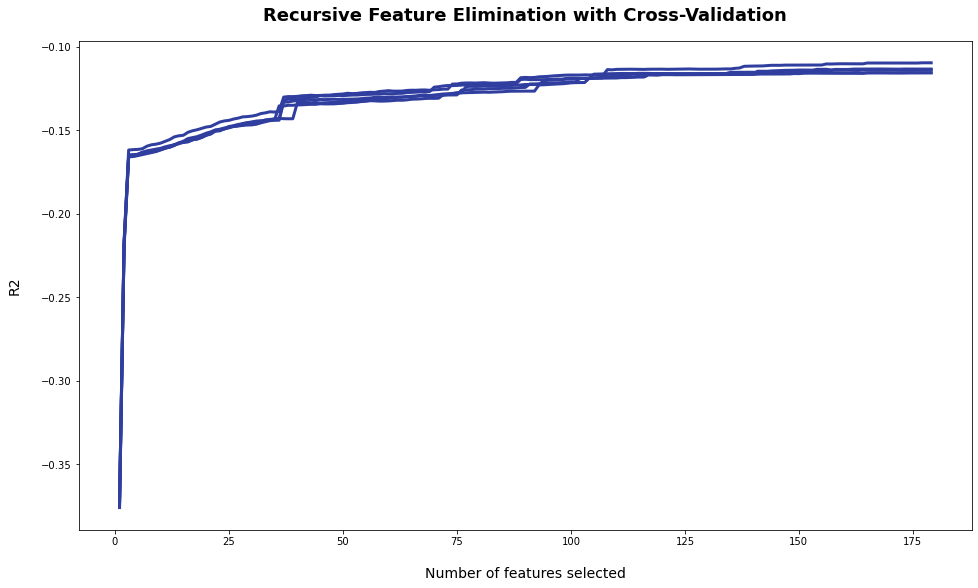

In [122]:
plt.figure(figsize=(16, 9))
plt.title('Recursive Feature Elimination with Cross-Validation', fontsize=18, fontweight='bold', pad=20)
plt.xlabel('Number of features selected', fontsize=14, labelpad=20)
plt.ylabel('R2', fontsize=14, labelpad=20)
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_, color='#303F9F', linewidth=3)

plt.show()

**Principal Component Analysis**

Explained variance with all components is  100.00000000000001
1 component explains  48.68525527879747
1st and 2nd components explains  60.33896891886371
1st to 3rd components explains  65.22085325466432
1st to 4th components explains  69.69421051902897


Text(0, 0.5, 'Explained Variance')

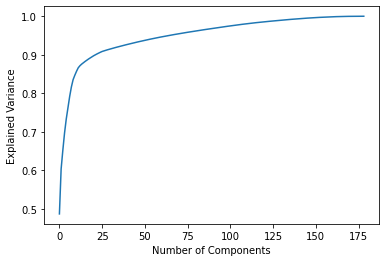

In [123]:
from sklearn.decomposition import PCA

pca_all = PCA(n_components=X_train_onehot.shape[1], random_state=randomstate)
x_pca = pca_all.fit_transform(X_train_onehot)

print("Explained variance with all components is ", sum(pca_all.explained_variance_ratio_ * 100))
print("1 component explains ", np.cumsum(pca_all.explained_variance_ratio_ * 100)[0])
print("1st and 2nd components explains ", np.cumsum(pca_all.explained_variance_ratio_ * 100)[1])
print("1st to 3rd components explains ", np.cumsum(pca_all.explained_variance_ratio_ * 100)[2])
print("1st to 4th components explains ", np.cumsum(pca_all.explained_variance_ratio_ * 100)[3])

plt.plot(np.cumsum(pca_all.explained_variance_ratio_))
plt.xlabel("Number of Components")
plt.ylabel("Explained Variance")


In [124]:
# Reducing the dataset into principal components that explain 95% of the variance

pca_95th = PCA(n_components=.95, random_state=randomstate)
x_pca_95 = pca_95th.fit_transform(X_train_onehot)

print(x_pca_95.shape[1],"components, starting from all features")

66 components, starting from all features


In [125]:
models = score_model(model, x_pca_95, y_train, "LR PCA",'OH Log/Stand', models)



 LR PCA OH Log/Stand
CV 5 R2 Train Score: 83.88
CV 5 MAE Train Score: -0.144
CV 5 RMSE Train Score: -0.187


## Target Encoded Data Set

### Spot Check Models

In [126]:
# Set up baseline models

baseline_models = {
    "LR Base": LinearRegression(),
    "Decision Tree Base": DecisionTreeRegressor(random_state = randomstate),
    "Elastic Net Base": ElasticNet(random_state = randomstate, normalize=True, copy_X=True, tol=1e-3),
    "Extra Trees Base": ExtraTreesRegressor(random_state = randomstate),
    "Gaussian Base": GaussianProcessRegressor(random_state = randomstate, normalize_y=True),
    "Gradient Boosted Base" : GradientBoostingRegressor(random_state = randomstate),
    "KNN Base" : KNeighborsRegressor(),
    "Lars Base" : Lars(random_state = randomstate, copy_X=True, normalize=False),
    "Lasso Base" : Lasso(random_state = randomstate, copy_X=True, tol=1e-3),
    "LinearSVR Base" : LinearSVR(random_state = randomstate),
    "MLPRegressor Base" : MLPRegressor(random_state = randomstate),
    "Bayesian Ridge Base" : BayesianRidge(),
    "Gamma Regressor Base" : GammaRegressor(),
    "Lasso Lars Base" : LassoLars(random_state = randomstate, normalize=False, copy_X=True),
    "Nu SVR Base": NuSVR(),
    "Orthogonal Matching Pursuit Base" : OrthogonalMatchingPursuit(),
    "Passive Aggressive Base" : PassiveAggressiveRegressor(random_state = randomstate),
    "RANSAC Base" : RANSACRegressor(random_state = randomstate),
    "Ridge Base" : Ridge(random_state = randomstate, tol=1e-3, normalize=False),
    "SVR Base" : SVR(),
    "XGB Regressor Base" : xgb.XGBRegressor(random_state = randomstate),
    "Ada Boost Base" : AdaBoostRegressor(random_state=randomstate),
    "SGD Regressor" : SGDRegressor(random_state=randomstate)

}

# run spot check on each model in baseline
for model in baseline_models:
    this_model = baseline_models[model]
    label = model
    spot_check = score_model(this_model, X_train_encoded, y_train, label, 'Target Log/Stand', models)



 LR Base Target Log/Stand
CV 5 R2 Train Score: 83.82
CV 5 MAE Train Score: -0.145
CV 5 RMSE Train Score: -0.188


 Decision Tree Base Target Log/Stand
CV 5 R2 Train Score: 74.43
CV 5 MAE Train Score: -0.175
CV 5 RMSE Train Score: -0.236


 Elastic Net Base Target Log/Stand
CV 5 R2 Train Score: -0.01
CV 5 MAE Train Score: -0.376
CV 5 RMSE Train Score: -0.467


 Extra Trees Base Target Log/Stand
CV 5 R2 Train Score: 87.8
CV 5 MAE Train Score: -0.12
CV 5 RMSE Train Score: -0.163


 Gaussian Base Target Log/Stand
CV 5 R2 Train Score: 51.08
CV 5 MAE Train Score: -0.229
CV 5 RMSE Train Score: -0.327


 Gradient Boosted Base Target Log/Stand
CV 5 R2 Train Score: 87.01
CV 5 MAE Train Score: -0.127
CV 5 RMSE Train Score: -0.168


 KNN Base Target Log/Stand
CV 5 R2 Train Score: 79.26
CV 5 MAE Train Score: -0.161
CV 5 RMSE Train Score: -0.213


 Lars Base Target Log/Stand
CV 5 R2 Train Score: 76.18
CV 5 MAE Train Score: -0.174
CV 5 RMSE Train Score: -0.226


 Lasso Base Target Log/Stand
CV 5 R2

In [127]:
# Set up baseline models

baseline_models = {
    "LR Base": LinearRegression(),
    "Decision Tree Base": DecisionTreeRegressor(random_state = randomstate),
    "Elastic Net Base": ElasticNet(random_state = randomstate, normalize=True, copy_X=True, tol=1e-3),
    "Extra Trees Base": ExtraTreesRegressor(random_state = randomstate),
    "Gaussian Base": GaussianProcessRegressor(random_state = randomstate, normalize_y=True),
    "Gradient Boosted Base" : GradientBoostingRegressor(random_state = randomstate),
    "KNN Base" : KNeighborsRegressor(),
    "Lars Base" : Lars(random_state = randomstate, copy_X=True, normalize=True),
    "Lasso Base" : Lasso(random_state = randomstate, copy_X=True, tol=1e-3),
    "LinearSVR Base" : LinearSVR(random_state = randomstate),
    "MLPRegressor Base" : MLPRegressor(random_state = randomstate),
    "Bayesian Ridge Base" : BayesianRidge(),
    "Gamma Regressor Base" : GammaRegressor(),
    "Lasso Lars Base" : LassoLars(random_state = randomstate, normalize=True, copy_X=True),
    "Nu SVR Base": NuSVR(),
    "Orthogonal Matching Pursuit Base" : OrthogonalMatchingPursuit(),
    "Passive Aggressive Base" : PassiveAggressiveRegressor(random_state = randomstate),
    "RANSAC Base" : RANSACRegressor(random_state = randomstate),
    "Ridge Base" : Ridge(random_state = randomstate, tol=1e-3, normalize=True),
    "SVR Base" : SVR(),
    "XGB Regressor Base" : xgb.XGBRegressor(random_state = randomstate),
    "Ada Boost Base" : AdaBoostRegressor(random_state=randomstate),
    "SGD Regressor" : SGDRegressor(random_state=randomstate)
}

# run spot check on each model in baseline
for model in baseline_models:
    this_model = baseline_models[model]
    label = model
    spot_check = score_model(this_model, x_train_encoded_nostand, y_train_exp, label, 'Target No Transform',models)



 LR Base Target No Transform
CV 5 R2 Train Score: 80.46
CV 5 MAE Train Score: -78127.761
CV 5 RMSE Train Score: -115054.215


 Decision Tree Base Target No Transform
CV 5 R2 Train Score: 74.45
CV 5 MAE Train Score: -86109.695
CV 5 RMSE Train Score: -131517.33


 Elastic Net Base Target No Transform
CV 5 R2 Train Score: 0.11
CV 5 MAE Train Score: -191958.786
CV 5 RMSE Train Score: -260109.258


 Extra Trees Base Target No Transform
CV 5 R2 Train Score: 87.54
CV 5 MAE Train Score: -59664.565
CV 5 RMSE Train Score: -91891.582


 Gaussian Base Target No Transform
CV 5 R2 Train Score: 0.04
CV 5 MAE Train Score: -191987.284
CV 5 RMSE Train Score: -260201.559


 Gradient Boosted Base Target No Transform
CV 5 R2 Train Score: 86.38
CV 5 MAE Train Score: -64850.283
CV 5 RMSE Train Score: -96028.792


 KNN Base Target No Transform
CV 5 R2 Train Score: 77.13
CV 5 MAE Train Score: -82424.629
CV 5 RMSE Train Score: -124464.748


 Lars Base Target No Transform
CV 5 R2 Train Score: 80.43
CV 5 MAE Tr

### Feature Selectors using Linear Regression

In [128]:
# Unless we specify a different model, this is our baseline model
model = LinearRegression()

Run a base model with no cross-validation or specific feature selection with ALL possible features. We're using our target categorical encoded set which performed worse in our first test.

In [129]:
predictors_train = sm.add_constant(X_train_encoded)
modelols = sm.OLS(y_train, predictors_train).fit()
modelols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.839
Model:                            OLS   Adj. R-squared:                  0.839
Method:                 Least Squares   F-statistic:                     2989.
Date:                Tue, 28 Sep 2021   Prob (F-statistic):               0.00
Time:                        10:18:59   Log-Likelihood:                 3825.7
No. Observations:               14931   AIC:                            -7597.
Df Residuals:                   14904   BIC:                            -7392.
Df Model:                          26                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               13.0352      0.008   1646.031      0.000      13.020      13.051
sqft_living          0.0588      0.004     16.001      0.000       0.052       0.066
sqft_living15        0.0216      0.004      5.520      0.000       0.014       0.029
sqft_lot            -0.0024      0.002     -1.005      0.315      -0.007       0.002
sqft_basement        0.0053      0.002      2.550      0.011       0.001       0.009
view                 0.0330      0.002     20.283      0.000       0.030       0.036
bedrooms            -0.0051      0.002     -2.333      0.020      -0.009      -0.001
bathrooms           -0.0015      0.003     -0.575      0.565      -0.007       0.004
grade                0.0803      0.003     31.808      0.000       0.075       0.085
condition            0.0344      0.002     20.815      0.000       0.031       0.038
zip_smooth           0.1707      0.003     65.126      0.000       0.166       0.176
year_smooth          0.0321      0.002     16.206      0.000       0.028       0.036
month_smooth         0.0150      0.002      9.699      0.000       0.012       0.018
lat_long             0.0775      0.003     29.437      0.000       0.072       0.083
sqft-zip             0.1183      0.003     44.530      0.000       0.113       0.123
month1              -0.0011      0.001     -0.873      0.383      -0.004       0.001
grade1            7.177e-05      0.001      0.065      0.948      -0.002       0.002
year1                0.0006      0.001      0.584      0.559      -0.001       0.003
sqft_living3        -0.0042      0.001     -5.072      0.000      -0.006      -0.003
sqft_living2         0.0094      0.002      5.814      0.000       0.006       0.013
floors_1.5           0.0625      0.006     10.038      0.000       0.050       0.075
floors_2.0          -0.0215      0.006     -3.898      0.000      -0.032      -0.011
floors_2.5           0.0251      0.020      1.250      0.211      -0.014       0.064
floors_3.0          -0.0197      0.012     -1.614      0.106      -0.044       0.004
waterfront_1         0.2434      0.043      5.698      0.000       0.160       0.327
renovated_1          0.0953      0.008     11.397      0.000       0.079       0.112
comparative_sf_2    -0.0281      0.007     -3.866      0.000      -0.042      -0.014
comparative_sf_3     0.0003      0.012      0.023      0.982      -0.023       0.023
==============================================================================
Omnibus:                      336.977   Durbin-Watson:                   2.004
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              665.081
Skew:                          -0.141   Prob(JB):                    3.80e-145
Kurtosis:                       3.995   Cond. No.                     2.15e+15
=====================================================

**Forward-Backward Selector**

In [130]:
result_target = stepwise_selection(X_train_encoded, y_train, verbose=True)

print('resulting features:', result_target)

Add  sqft_living                    with p-value 0.0
Add  lat_long                       with p-value 0.0
Add  zip_smooth                     with p-value 0.0
Add  grade                          with p-value 7.54414e-195
Add  view                           with p-value 2.84757e-130
Add  condition                      with p-value 2.4821e-77
Add  year_smooth                    with p-value 5.04996e-87
Add  sqft_living2                   with p-value 1.54903e-34
Add  renovated_1                    with p-value 1.19988e-33
Add  floors_1.5                     with p-value 1.2134e-30
Add  month_smooth                   with p-value 3.78044e-22
Add  sqft_living15                  with p-value 1.70998e-13
Add  sqft-zip                       with p-value 0.0
Add  comparative_sf_2               with p-value 1.83043e-17
Add  waterfront_1                   with p-value 1.75995e-08
Add  sqft_basement                  with p-value 9.72346e-09
Add  sqft_living3                   with p-value 1.68942

In [131]:
X_train_refined_encoded = X_train_encoded[result_target]

models = score_model(model, X_train_refined_encoded, y_train, "LR Forward Backward", 'Target Log/Stand', models)



 LR Forward Backward Target Log/Stand
CV 5 R2 Train Score: 83.83
CV 5 MAE Train Score: -0.145
CV 5 RMSE Train Score: -0.188


**Permutation Importance**

Next we're going to select features using a method called permutation importance. This is a great model-agnostic method that you can use with any model type, and the way it works is very easy to understand. After fitting the model, it calculates a baseline R^2 score. Then for each feature, it scrambles the inputs of that feature, turnings its contribution into noise. The model is evaluated again with the feature scrambled, and the change in overall R^2 is logged as the importance for that feature. After scrambling all features, each feature has been assigned an importance based on the R^2 reduction. You can then select the features that had an effect on R^2 based on your own threshold (I kept anything >= .001) and throw out the remaining features.

You can learn more about this underrated feature selection method here: https://explained.ai/rf-importance/
The article focuses on Random Forest, but discusses permutation importance as an excellent feature selection method for any model type.

In [132]:
model.fit(X_train_encoded, y_train)


r = permutation_importance(model, X_train_encoded, y_train,
                           n_repeats=15,
                            random_state=0,
                          n_jobs=-1)

importances = {}

for i in r.importances_mean.argsort()[::-1]:
    if r.importances_mean[i] >= 0.001:
        importances[X_train_encoded.columns[i]] = r.importances_mean[i]
    else: continue
        
importances

important_features_encoded = list(importances.keys())
important_features_encoded

['sqft-zip',
 'sqft_living',
 'zip_smooth',
 'grade',
 'lat_long',
 'condition',
 'view',
 'year_smooth',
 'sqft_living15',
 'floors_1.5',
 'renovated_1',
 'month_smooth',
 'sqft_living2',
 'comparative_sf_2',
 'sqft_living3']

In [133]:
# set the features recommended by our feature selector

X_train_perm = X_train_encoded[important_features_encoded]

predictors_int = sm.add_constant(X_train_perm)
modelols = sm.OLS(y_train, predictors_int).fit()
modelols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.838
Model:                            OLS   Adj. R-squared:                  0.838
Method:                 Least Squares   F-statistic:                     5516.
Date:                Tue, 28 Sep 2021   Prob (F-statistic):               0.00
Time:                        10:19:01   Log-Likelihood:                 3780.6
No. Observations:               14931   AIC:                            -7531.
Df Residuals:                   14916   BIC:                            -7417.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               13.0289      0.004   3471.216      0.000      13.022      13.036
sqft-zip             0.1169      0.002     73.280      0.000       0.114       0.120
sqft_living          0.0558      0.002     26.715      0.000       0.052       0.060
zip_smooth           0.1733      0.002     70.894      0.000       0.169       0.178
grade                0.0769      0.002     32.078      0.000       0.072       0.082
lat_long             0.0780      0.003     30.153      0.000       0.073       0.083
condition            0.0361      0.002     22.187      0.000       0.033       0.039
view                 0.0361      0.002     22.768      0.000       0.033       0.039
year_smooth          0.0301      0.002     18.059      0.000       0.027       0.033
sqft_living15        0.0197      0.002      8.122      0.000       0.015       0.024
floors_1.5           0.0678      0.006     11.881      0.000       0.057       0.079
renovated_1          0.0978      0.008     11.716      0.000       0.081       0.114
month_smooth         0.0148      0.002      9.584      0.000       0.012       0.018
sqft_living2         0.0089      0.001      6.334      0.000       0.006       0.012
comparative_sf_2    -0.0309      0.004     -8.291      0.000      -0.038      -0.024
sqft_living3        -0.0043      0.001     -5.306      0.000      -0.006      -0.003
==============================================================================
Omnibus:                      330.413   Durbin-Watson:                   2.001
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              672.269
Skew:                          -0.121   Prob(JB):                    1.04e-146
Kurtosis:                       4.011   Cond. No.                     2.04e+15
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 5.13e-26. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [134]:
print("{} predictors used".format(len(important_features)))

113 predictors used


In [135]:
models = score_model(model, X_train_perm, y_train, "LR Perm Importance",'Target Log/Stand', models)



 LR Perm Importance Target Log/Stand
CV 5 R2 Train Score: 83.77
CV 5 MAE Train Score: -0.145
CV 5 RMSE Train Score: -0.188


**Recursive Feature Elimination with Cross Validation - Linear Regression**

RFECV is a reverse forward-backward selector. It starts the model with all features in use then removes the weakest one, and iterates until the best feature set is found. It uses integrated cross-validation to determine the optimal set of features in the model with the best cross-validated score. We score on mean absolute error.

In [136]:
# Using sklearn RFECV to perform integrated CV while picking the number of features
# picks the number of features itself

rfecv = RFECV(estimator=model, step=1, cv=5, scoring='neg_mean_absolute_error')

# fit model to train set
rfecv.fit(X_train_encoded, y_train)

# print optimal number of features
print('Optimal number of features: {}'.format(rfecv.n_features_))

Optimal number of features: 22


In [137]:
dset = pd.DataFrame()
dset['attr'] = X_train_encoded.columns
dset['used'] = rfecv.support_

# make a list of the features used in the rfecv
rfecv_result = list(dset[(dset['used'] == True)]['attr'])

# Show the features that RFECV did not use
dset[dset['used']==False]

,attr,used
6,bathrooms,False
14,month1,False
15,grade1,False
16,year1,False
26,comparative_sf_3,False


RFECV used all features, so no need to run another model.

**Principal Component Analysis**

Explained variance with all components is  100.00000000000003
1 component explains  42.8280066499954
1st and 2nd components explains  53.70230890055816
1st to 3rd components explains  61.7956609884891
1st to 4th components explains  67.7805134307602


Text(0, 0.5, 'Explained Variance')

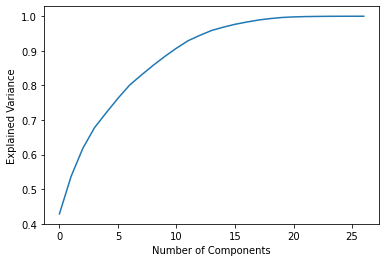

In [138]:
from sklearn.decomposition import PCA

pca_all = PCA(n_components=X_train_encoded.shape[1], random_state=randomstate)
x_pca = pca_all.fit_transform(X_train_encoded)

print("Explained variance with all components is ", sum(pca_all.explained_variance_ratio_ * 100))
print("1 component explains ", np.cumsum(pca_all.explained_variance_ratio_ * 100)[0])
print("1st and 2nd components explains ", np.cumsum(pca_all.explained_variance_ratio_ * 100)[1])
print("1st to 3rd components explains ", np.cumsum(pca_all.explained_variance_ratio_ * 100)[2])
print("1st to 4th components explains ", np.cumsum(pca_all.explained_variance_ratio_ * 100)[3])

plt.plot(np.cumsum(pca_all.explained_variance_ratio_))
plt.xlabel("Number of Components")
plt.ylabel("Explained Variance")


In [139]:
# Reducing the dataset into principal components that explain 95% of the variance

pca_95th = PCA(n_components=.95, random_state=randomstate)
x_pca_95 = pca_95th.fit_transform(X_train_encoded)

print(x_pca_95.shape[1],"components, starting from all features")

14 components, starting from all features


In [140]:
models = score_model(model, x_pca_95, y_train, "LR PCA",'Target Log/Stand', models)



 LR PCA Target Log/Stand
CV 5 R2 Train Score: 82.4
CV 5 MAE Train Score: -0.152
CV 5 RMSE Train Score: -0.196


## Spot Check Evaluation

In [163]:
# make data frame from our models dictionary
target = pd.DataFrame(models).reset_index(drop=True)

In [166]:
# sort data frame by mae and reset index
target.sort_values('mae', ascending=False).head(10)

,model,method,r2,mae,rmse
14,Nu SVR Base,OH Log/Stand,88.83,-0.111,-0.156
0,LR Base,OH Log/Stand,89.17,-0.114,-0.154
9,LinearSVR Base,OH Log/Stand,88.85,-0.114,-0.156
19,SVR Base,OH Log/Stand,88.63,-0.114,-0.157
18,Ridge Base,OH Log/Stand,89.17,-0.114,-0.154
11,Bayesian Ridge Base,OH Log/Stand,89.16,-0.114,-0.154
46,LR Forward Backward,OH Log/Stand,89.17,-0.114,-0.154
69,XGB Regressor Base,Target Log/Stand,88.86,-0.115,-0.156
47,LR Perm Importance,OH Log/Stand,88.72,-0.116,-0.157
20,XGB Regressor Base,OH Log/Stand,88.29,-0.118,-0.160


In [162]:
target.sort_values(['model', 'r2'], ascending=False).head(38)

,model,method,r2,mae,rmse
69,XGB Regressor Base,Target Log/Stand,8.886000e+01,-1.150000e-01,-1.560000e-01
92,XGB Regressor Base,Target No Transform,8.884000e+01,-5.737406e+04,-8.694543e+04
43,XGB Regressor Base,OH No Transform,8.853000e+01,-5.857646e+04,-8.812120e+04
20,XGB Regressor Base,OH Log/Stand,8.829000e+01,-1.180000e-01,-1.600000e-01
19,SVR Base,OH Log/Stand,8.863000e+01,-1.140000e-01,-1.570000e-01
68,SVR Base,Target Log/Stand,8.519000e+01,-1.350000e-01,-1.800000e-01
42,SVR Base,OH No Transform,-4.720000e+00,-1.855172e+05,-2.663122e+05
91,SVR Base,Target No Transform,-4.970000e+00,-1.857606e+05,-2.666267e+05
71,SGD Regressor,Target Log/Stand,7.824000e+01,-1.690000e-01,-2.180000e-01
22,SGD Regressor,OH Log/Stand,7.700000e+01,-1.650000e-01,-2.240000e-01


In [143]:
target.sort_values(['model', 'r2'], ascending=False).tail(35)

,model,method,r2,mae,rmse
26,LR PCA,OH Log/Stand,83.88,-0.144,-0.187
36,LR PCA,Target Log/Stand,82.40,-0.152,-0.196
2,LR Forward Backward,OH Log/Stand,89.17,-0.114,-0.154
29,LR Forward Backward,Target Log/Stand,83.83,-0.145,-0.188
0,LR Base,OH Log/Stand,89.17,-0.114,-0.154
17,LR Base,OH No Transform,86.61,-65520.362,-95222.461
30,LR Base,Target Log/Stand,83.82,-0.145,-0.188
41,LR Base,Target No Transform,80.46,-78127.761,-115054.215
46,KNN Base,Target Log/Stand,79.26,-0.161,-0.213
52,KNN Base,Target No Transform,77.13,-82424.629,-124464.748


### Tuning Plan

Target Log/Standardized
* XGB Regressor (Boosting)
* Gradient Boosted (Boosting)
* Extra Trees (Boosted Tree, uses Decision Tree)
* RANSAC (Linear)
* KNN (KNN)
* Gaussian (Gaussian)
* SGD Regressor 

Use PERMUTATION IMPORTANCE for ONE-HOT plans

OH, Log/Standardized
* SVR (SVM)
* Nu SVR (SVM)
* Ridge (Linear)
* Orthogonal Matching Pursuit (Linear)
* Bayesian Ridge (Linear)
* LR For-Back (Linear w/feature selection)
* MLP Regressor (Neural Net)

OH, No Transform
* Lasso Lars (Linear)
* Lasso (Linear)

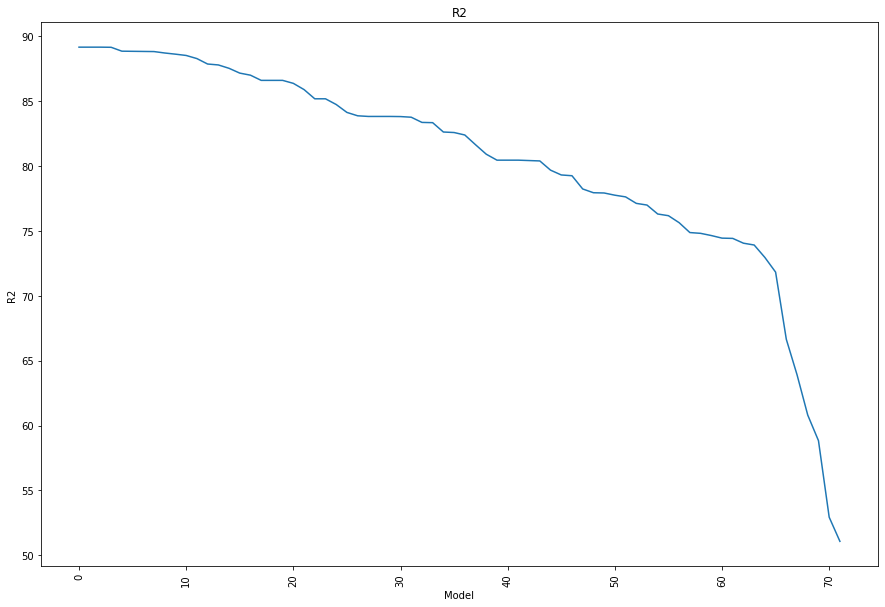

In [144]:
# plot model mae

plt.figure(figsize=(15,10))
plt.plot(target['r2'])
plt.title("R2")
plt.xticks(rotation=90)
plt.xlabel('Model')
plt.ylabel("R2");

## Final Model

In [145]:
result = ['sqft_living', 'grade', 'sqft-zip', 'view', 'zipcode_98006', 'condition', 'zipcode_98133', 'zipcode_98075', 'zipcode_98032', 'floors_1.5', 'sqft_living2', 'zipcode_98074', 'zipcode_98040', 'zipcode_98118', 'zipcode_98052', 'zipcode_98039', 'zipcode_98126', 'sqft_living15', 'zipcode_98106', 'zipcode_98004', 'zipcode_98112', 'zipcode_98155', 'zipcode_98125', 'zipcode_98033', 'zipcode_98065', 'zipcode_98107', 'zipcode_98034', 'renovated_1', 'zipcode_98092', 'zipcode_98117', 'zipcode_98022', 'zipcode_98188', 'zipcode_98199', 'zipcode_98010', 'zipcode_98042', 'zipcode_98146', 'zipcode_98023', 'grade1', 'zipcode_98038', 'zipcode_98168', 'zipcode_98029', 'zipcode_98148', 'year_block_30', 'sqft_lot', 'year_block_3', 'year_block_29', 'waterfront_1', 'zipcode_98070', 'month_sold_6', 'month_sold_5', 'year_block_5', 'loc_block_46', 'month_sold_4', 'year_block_18', 'zipcode_98058', 'zipcode_98178', 'bathrooms', 'year_block_4', 'zipcode_98122', 'zipcode_98103', 'zipcode_98102', 'zipcode_98136', 'loc_block_47', 'zipcode_98108', 'sqft_basement', 'floors_3.0', 'zipcode_98144', 'zipcode_98109', 'month_sold_7', 'month_sold_3', 'year_block_13', 'zipcode_98198', 'zipcode_98056', 'zipcode_98055', 'loc_block_37', 'loc_block_36', 'loc_block_33', 'loc_block_31', 'zipcode_98119', 'loc_block_49', 'loc_block_50', 'year_block_28', 'zipcode_98115', 'zipcode_98116', 'loc_block_45', 'loc_block_48', 'loc_block_41', 'loc_block_38', 'loc_block_40', 'loc_block_44', 'loc_block_34', 'loc_block_39', 'loc_block_42', 'loc_block_35', 'loc_block_29', 'loc_block_43', 'zipcode_98177', 'zipcode_98072', 'loc_block_28', 'loc_block_30', 'loc_block_27', 'loc_block_32', 'month_sold_8', 'year_block_11', 'year_block_12', 'loc_block_25', 'loc_block_10', 'year_block_24', 'year_block_25', 'zipcode_98014', 'loc_block_26', 'year_block_15', 'year_block_14', 'year_block_16', 'year_block_17', 'year_block_10', 'year_block_9', 'zipcode_98028', 'month_sold_9', 'zipcode_98024']

In [146]:
X_train_encoded = np.array(X_train_encoded)
X_test_encoded = np.array(X_test_encoded)
X_train_refined = np.array(X_train_onehot[result])
X_test_refined = np.array(X_test_onehot[result])
X_train_onehot = np.array(X_train_onehot)
X_test_onehot = np.array(X_test_onehot)
x_train_onehot_nostand = np.array(x_train_onehot_nostand)
x_test_onehot_nostand = np.array(x_test_onehot_nostand)

**All model tuning is located in the APPENDIX**

In [147]:
xgbc = xgb.XGBRegressor(
                n_estimators=5000,
                seed=randomstate,
                missing=0,
                eval_metric='mae',
                verbosity=1,
                max_depth = 7,
                eta = .1,
                min_child_weight = 10,
                gamma = .2,
                subsample = .6,
                reg_alpha = 1e-5,
                reg_lambda = 1)

gradient_boost = GradientBoostingRegressor(
                n_estimators=1000,
                random_state=randomstate,
                learning_rate = .05,
                max_depth = 5,
                max_features = 'sqrt')

extra_trees = ExtraTreesRegressor(
                n_estimators=500,
                random_state=randomstate,
                verbose=0,
                max_depth = 20,
                criterion = 'mse',
                max_features = 'auto')

ransac = RANSACRegressor(random_state = randomstate)
neighbor = KNeighborsRegressor(n_neighbors = 13)
gauss = GaussianProcessRegressor(random_state = randomstate, normalize_y=True)
sgd = SGDRegressor(random_state = randomstate, learning_rate = 'adaptive', penalty='elasticnet', l1_ratio = .85)

In [148]:
svr = SVR(gamma = 'scale', kernel = 'linear', C=10, epsilon=.05)
nu_svr = NuSVR(kernel = 'rbf', gamma = 'scale')
orth = OrthogonalMatchingPursuit()
linreg = LinearRegression()

In [149]:
ridge = Ridge(random_state = randomstate, tol=1e-3, normalize=False, solver='auto')

bay_ridge = BayesianRidge(alpha_init=50, normalize=False)

mlp = MLPRegressor(random_state = randomstate, solver='lbfgs', activation='logistic')

In [150]:
lasso_lars = LassoLars(random_state = randomstate, normalize=True, copy_X=True)

lasso = Lasso(random_state = randomstate, copy_X=True, tol=1e-3, alpha=10)

### OOF Predictions

##### Target Encoding, Log/Standardized

* XGB Regressor (Boosting)
* Gradient Boosted (Boosting)
* Extra Trees (Boosted Tree, uses Decision Tree)
* RANSAC (Linear)
* KNN (KNN)
* Gaussian (Gaussian)
* SGD Regressor (Linear)

* X_train_encoded, X_test_encoded - train/test split predictors for encoded sets, standardized and transformed
* y_train, y_test - target values for all sets which are log transformed
* test_actual - exponentiated y_test prices

In [173]:
kfold = KFold(n_splits=10, shuffle=True, random_state=randomstate)

In [174]:
# collect out of sample predictions

# Divide the data into 5 splits
# For each split, train on the large group and predict on the left-out fold
# Add those predictions to larger lists of data, thereby keeping all of the data in the exact same order

data_x_target_stand, data_y, xgbc_yhat, gradient_boost_yhat  = [], [], [], []
gauss_yhat, sgd_yhat, ransac_yhat, neighbor_yhat, extra_trees_yhat = [], [], [], [], []

for train_ix, test_ix in kfold.split(X_train_encoded, y_train):
    
    print("\nStarting a new fold\n")
    
    print("Creating splits")
    # get data
    train_X, test_X = X_train_encoded[train_ix], X_train_encoded[test_ix]
    train_y, test_y = y_train[train_ix], y_train[test_ix]
    
    print("Adding x and y to lists\n")
    # add the used data to lists
    data_x_target_stand.extend(test_X)
    data_y.extend(test_y)
    
    # fit and make predictions with Catboost
    print("Running XGBC on this fold")
    xgbc.fit(train_X, train_y)
    yhat1 = xgbc.predict(test_X)   
    xgbc_yhat.extend(yhat1) # add predictions to list
    
    # fit and make predictions with Random Forest
    print("Running Gradient Boosting on this fold")
    gradient_boost.fit(train_X, train_y)
    yhat2 = gradient_boost.predict(test_X)   
    gradient_boost_yhat.extend(yhat2) # add predictions to list
    
    # fit and make predictions with Logistic Regression
    print("Running Extra Trees on this fold")
    extra_trees.fit(train_X, train_y)
    yhat3 = extra_trees.predict(test_X)   
    extra_trees_yhat.extend(yhat3) # add predictions to list    
    
    # fit and make predictions with Logistic Regression
    print("Running RANSAC on this fold")
    ransac.fit(train_X, train_y)
    yhat4 = ransac.predict(test_X).ravel()
    ransac_yhat.extend(yhat4) # add predictions to list
       
    # fit and make predictions with XGBC
    print("Running KNN on this fold")
    neighbor.fit(train_X, train_y)
    yhat5 = neighbor.predict(test_X).ravel()  
    neighbor_yhat.extend(yhat5) # add predictions to list 
    
    # fit and make predictions with XGBC
    print("Running Gaussian on this fold")
    gauss.fit(train_X, train_y)
    yhat6 = gauss.predict(test_X).ravel()
    gauss_yhat.extend(yhat6) # add predictions to list 
    
    # fit and make predictions with XGBC
    print("Running SGDRegressor on this fold")
    sgd.fit(train_X, train_y)
    yhat7 = sgd.predict(test_X)   
    sgd_yhat.extend(yhat7) # add predictions to list 


Starting a new fold

Creating splits
Adding x and y to lists

Running XGBC on this fold
Running Gradient Boosting on this fold
Running Extra Trees on this fold
Running RANSAC on this fold
Running KNN on this fold
Running Gaussian on this fold
Running SGDRegressor on this fold

Starting a new fold

Creating splits
Adding x and y to lists

Running XGBC on this fold
Running Gradient Boosting on this fold
Running Extra Trees on this fold
Running RANSAC on this fold
Running KNN on this fold
Running Gaussian on this fold
Running SGDRegressor on this fold

Starting a new fold

Creating splits
Adding x and y to lists

Running XGBC on this fold
Running Gradient Boosting on this fold
Running Extra Trees on this fold
Running RANSAC on this fold
Running KNN on this fold
Running Gaussian on this fold
Running SGDRegressor on this fold

Starting a new fold

Creating splits
Adding x and y to lists

Running XGBC on this fold
Running Gradient Boosting on this fold
Running Extra Trees on this fold
Runni

##### OneHot Encoding, Log/Standardized, Feature Selection

Utilizing Feature Selection List for LR

* SVR (SVM)
* Nu SVR (SVM)
* Orthogonal Matching Pursuit 8(Linear)
* LR For-Back (Linear w/feature selection)

* X_train_refined, X_test_refined - train/test split predictors for one_hot with feature selection, standardized and transformed
* y_train, y_test - target values for all sets which are log transformed
* test_actual - exponentiated y_test prices

In [175]:
# collect out of sample predictions

# Divide the data into 5 splits
# For each split, train on the large group and predict on the left-out fold
# Add those predictions to larger lists of data, thereby keeping all of the data in the exact same order

data_x_OH_stand_FS, svr_yhat, nu_svr_yhat, orth_yhat, linreg_yhat,  = [], [], [], [], []

for train_ix, test_ix in kfold.split(X_train_refined, y_train):
    
    print("\nStarting a new fold\n")
    
    print("Creating splits")
    # get data
    train_X, test_X = X_train_refined[train_ix], X_train_refined[test_ix]
    train_y, test_y = y_train[train_ix], y_train[test_ix]
    
    print("Adding x and y to lists")
    # add the used data to lists
    data_x_OH_stand_FS.extend(test_X)
    
    # fit and make predictions with Catboost
    print("Running SVR on this fold")
    svr.fit(train_X, train_y)
    yhat1 = svr.predict(test_X)   
    svr_yhat.extend(yhat1) # add predictions to list
    
    # fit and make predictions with Random Forest
    print("Running NU SVR on this fold")
    nu_svr.fit(train_X, train_y)
    yhat2 = nu_svr.predict(test_X)   
    nu_svr_yhat.extend(yhat2) # add predictions to list
    
    # fit and make predictions with Logistic Regression
    print("Running Orthogonal Regression on this fold")
    orth.fit(train_X, train_y)
    yhat3 = orth.predict(test_X)   
    orth_yhat.extend(yhat3) # add predictions to list    
    
    # fit and make predictions with Logistic Regression
    print("Running Linear Regression on this fold")
    linreg.fit(train_X, train_y)
    yhat4 = linreg.predict(test_X).ravel() 
    linreg_yhat.extend(yhat4) # add predictions to list



Starting a new fold

Creating splits
Adding x and y to lists
Running SVR on this fold
Running NU SVR on this fold
Running Orthogonal Regression on this fold
Running Linear Regression on this fold

Starting a new fold

Creating splits
Adding x and y to lists
Running SVR on this fold
Running NU SVR on this fold
Running Orthogonal Regression on this fold
Running Linear Regression on this fold

Starting a new fold

Creating splits
Adding x and y to lists
Running SVR on this fold
Running NU SVR on this fold
Running Orthogonal Regression on this fold
Running Linear Regression on this fold

Starting a new fold

Creating splits
Adding x and y to lists
Running SVR on this fold
Running NU SVR on this fold
Running Orthogonal Regression on this fold
Running Linear Regression on this fold

Starting a new fold

Creating splits
Adding x and y to lists
Running SVR on this fold
Running NU SVR on this fold
Running Orthogonal Regression on this fold
Running Linear Regression on this fold

Starting a new

##### OneHot Encoding, Log/Standardized

* Ridge (Linear)
* Bayesian Ridge (Linear)
* MLP Regressor (Neural Net)

* X_train_onehot, X_test_onehot - train/test split predictors for one-hot sets, standardized and transformed
* y_train, y_test - target values for all sets which are log transformed
* test_actual - exponentiated y_test prices

In [176]:
# collect out of sample predictions

# Divide the data into 5 splits
# For each split, train on the large group and predict on the left-out fold
# Add those predictions to larger lists of data, thereby keeping all of the data in the exact same order

data_x_OH_stand, ridge_yhat, bay_ridge_yhat, mlp_yhat  = [], [], [], []

for train_ix, test_ix in kfold.split(X_train_onehot, y_train):
    
    print("\nStarting a new fold\n")
    
    print("Creating splits")
    # get data
    train_X, test_X = X_train_onehot[train_ix], X_train_onehot[test_ix]
    train_y, test_y = y_train[train_ix], y_train[test_ix]
    
    print("Adding x and y to lists")
    # add the used data to lists
    data_x_OH_stand.extend(test_X)
    
    # fit and make predictions with Catboost
    print("Running Ridge on this fold")
    ridge.fit(train_X, train_y)
    yhat1 = ridge.predict(test_X).ravel()  
    ridge_yhat.extend(yhat1) # add predictions to list
    
    # fit and make predictions with Random Forest
    print("Running Bayesian Ridge on this fold")
    bay_ridge.fit(train_X, train_y)
    yhat2 = bay_ridge.predict(test_X)   
    bay_ridge_yhat.extend(yhat2) # add predictions to list
    
    # fit and make predictions with Logistic Regression
    print("Running Perceptron on this fold")
    mlp.fit(train_X, train_y)
    yhat3 = mlp.predict(test_X)   
    mlp_yhat.extend(yhat3) # add predictions to list    


Starting a new fold

Creating splits
Adding x and y to lists
Running Ridge on this fold
Running Bayesian Ridge on this fold
Running Perceptron on this fold

Starting a new fold

Creating splits
Adding x and y to lists
Running Ridge on this fold
Running Bayesian Ridge on this fold
Running Perceptron on this fold

Starting a new fold

Creating splits
Adding x and y to lists
Running Ridge on this fold
Running Bayesian Ridge on this fold
Running Perceptron on this fold

Starting a new fold

Creating splits
Adding x and y to lists
Running Ridge on this fold
Running Bayesian Ridge on this fold
Running Perceptron on this fold

Starting a new fold

Creating splits
Adding x and y to lists
Running Ridge on this fold
Running Bayesian Ridge on this fold
Running Perceptron on this fold

Starting a new fold

Creating splits
Adding x and y to lists
Running Ridge on this fold
Running Bayesian Ridge on this fold
Running Perceptron on this fold

Starting a new fold

Creating splits
Adding x and y to li

##### OneHot Encoding, No Transformations

* Lasso Lars (Linear)
* Lasso (Linear)

* x_train_onehot_nostand, x_test_onehot_nostand - train/test split predictors for one-hot sets, NOT standardized and transformed
* y_train_exp, y_test_exp - target values for all sets NOT log transformed

In [177]:
# collect out of sample predictions

# Divide the data into 5 splits
# For each split, train on the large group and predict on the left-out fold
# Add those predictions to larger lists of data, thereby keeping all of the data in the exact same order

data_x_OH_nostand, datdata_y_exp, lasso_lars_yhat, lasso_yhat  = [], [], [], []

for train_ix, test_ix in kfold.split(x_train_onehot_nostand, y_train_exp):
    
    print("\nStarting a new fold\n")
    
    print("Creating splits")
    # get data
    train_X, test_X = x_train_onehot_nostand[train_ix], x_train_onehot_nostand[test_ix]
    train_y, test_y = y_train_exp[train_ix], y_train_exp[test_ix]

    
    print("Adding x and y to lists")
    # add the used data to lists
    data_x_OH_nostand.extend(test_X)
    datdata_y_exp.extend(test_y)
    
    # fit and make predictions with Catboost
    print("Running Lasso Lars on this fold")
    lasso_lars.fit(train_X, train_y)
    yhat1 = lasso_lars.predict(test_X)   
    lasso_lars_yhat.extend(yhat1) # add predictions to list
    
    # fit and make predictions with Random Forest
    print("Running Lasso on this fold")
    lasso.fit(train_X, train_y)
    yhat2 = lasso.predict(test_X)   
    lasso_yhat.extend(yhat2) # add predictions to list

lasso_lars_yhat = list(np.log(lasso_lars_yhat))
lasso_yhat = list(np.log(lasso_yhat))


Starting a new fold

Creating splits
Adding x and y to lists
Running Lasso Lars on this fold
Running Lasso on this fold

Starting a new fold

Creating splits
Adding x and y to lists
Running Lasso Lars on this fold
Running Lasso on this fold

Starting a new fold

Creating splits
Adding x and y to lists
Running Lasso Lars on this fold
Running Lasso on this fold

Starting a new fold

Creating splits
Adding x and y to lists
Running Lasso Lars on this fold
Running Lasso on this fold

Starting a new fold

Creating splits
Adding x and y to lists
Running Lasso Lars on this fold
Running Lasso on this fold

Starting a new fold

Creating splits
Adding x and y to lists
Running Lasso Lars on this fold
Running Lasso on this fold

Starting a new fold

Creating splits
Adding x and y to lists
Running Lasso Lars on this fold
Running Lasso on this fold

Starting a new fold

Creating splits
Adding x and y to lists
Running Lasso Lars on this fold
Running Lasso on this fold

Starting a new fold

Creating s

In [178]:
lass_df = pd.DataFrame(lasso_yhat)
lass_df.fillna(lass_df.mean(), inplace=True)
lasso_yhat = np.array(lass_df)

#### Save Yhat predictions

In [179]:
pd.DataFrame(data_x_target_stand).to_pickle('saved_yhat/data_x_target_stand.pkl')
pd.DataFrame(data_y).to_pickle('saved_yhat/data_y.pkl')
pd.DataFrame(xgbc_yhat).to_pickle('saved_yhat/xgbc_yhat.pkl')
pd.DataFrame(gradient_boost_yhat).to_pickle('saved_yhat/gradient_boost_yhat.pkl')
pd.DataFrame(gauss_yhat).to_pickle('saved_yhat/gauss_yhat.pkl')
pd.DataFrame(sgd_yhat).to_pickle('saved_yhat/sgd_yhat.pkl')
pd.DataFrame(ransac_yhat).to_pickle('saved_yhat/ransac_yhat.pkl')
pd.DataFrame(neighbor_yhat).to_pickle('saved_yhat/neighbor_yhat.pkl')
pd.DataFrame(extra_trees_yhat).to_pickle('saved_yhat/extra_trees_yhat.pkl')
pd.DataFrame(svr_yhat).to_pickle('saved_yhat/svr_yhat.pkl')
pd.DataFrame(nu_svr_yhat).to_pickle('saved_yhat/nu_svr_yhat.pkl')
pd.DataFrame(orth_yhat).to_pickle('saved_yhat/orth_yhat.pkl')
pd.DataFrame(linreg_yhat).to_pickle('saved_yhat/linreg_yhat.pkl')
pd.DataFrame(ridge_yhat).to_pickle('saved_yhat/ridge_yhat.pkl')
pd.DataFrame(bay_ridge_yhat).to_pickle('saved_yhat/bay_ridge_yhat.pkl')
pd.DataFrame(mlp_yhat).to_pickle('saved_yhat/mlp_yhat.pkl')
pd.DataFrame(lasso_lars_yhat).to_pickle('saved_yhat/lasso_lars_yhat.pkl')
pd.DataFrame(lasso_yhat).to_pickle('saved_yhat/lasso_yhat.pkl')

### Load Model Stack

In [ ]:
'''data_x_target_stand= np.array(pd.read_pickle('saved_yhat/data_x_target_stand.pkl'))
data_y= np.array(pd.read_pickle('saved_yhat/data_y.pkl'))
xgbc_yhat= np.array(pd.read_pickle('saved_yhat/xgbc_yhat.pkl'))
gradient_boost_yhat= np.array(pd.read_pickle('saved_yhat/gradient_boost_yhat.pkl'))
gauss_yhat= np.array(pd.read_pickle('saved_yhat/gauss_yhat.pkl'))
sgd_yhat= np.array(pd.read_pickle('saved_yhat/sgd_yhat.pkl'))
ransac_yhat= np.array(pd.read_pickle('saved_yhat/ransac_yhat.pkl'))
neighbor_yhat= np.array(pd.read_pickle('saved_yhat/neighbor_yhat.pkl'))
extra_trees_yhat= np.array(pd.read_pickle('saved_yhat/extra_trees_yhat.pkl'))
svr_yhat= np.array(pd.read_pickle('saved_yhat/svr_yhat.pkl'))
nu_svr_yhat= np.array(pd.read_pickle('saved_yhat/nu_svr_yhat.pkl'))
orth_yhat= np.array(pd.read_pickle('saved_yhat/orth_yhat.pkl'))
linreg_yhat= np.array(pd.read_pickle('saved_yhat/linreg_yhat.pkl'))
ridge_yhat= np.array(pd.read_pickle('saved_yhat/ridge_yhat.pkl'))
bay_ridge_yhat= np.array(pd.read_pickle('saved_yhat/bay_ridge_yhat.pkl'))
mlp_yhat= np.array(pd.read_pickle('saved_yhat/mlp_yhat.pkl'))
lasso_lars_yhat= np.array(pd.read_pickle('saved_yhat/lasso_lars_yhat.pkl'))
lasso_yhat= np.array(pd.read_pickle('saved_yhat/lasso_yhat.pkl'))'''

In [ ]:
break

### Model Selector

In [203]:
meta_model = xgb.XGBRegressor(
                n_estimators=1000,
                seed=randomstate,
                missing=0,
                eval_metric='mae',
                verbosity=1,
                max_depth = 7,
                eta = .1,
                min_child_weight = 10,
                gamma = .2,
                subsample = .6,
                reg_alpha = 1e-5,
                reg_lambda = 1)

In [204]:
models_dict = {

            'SGD Regressor' : sgd_yhat,
            'RANSAC': ransac_yhat,
            'XGB' : xgbc_yhat,
            'Gauss' : gauss_yhat,
            'KNN' : neighbor_yhat,
            'Extra Trees' : extra_trees_yhat,
            'Gradient Boosted' : gradient_boost_yhat,
            'SVR' : svr_yhat,
            'Nu SVR': nu_svr_yhat,
            'Orthogonal': orth_yhat,
            'Linear Regression': linreg_yhat,
            'Ridge': ridge_yhat,
            'Bayesian Ridge': bay_ridge_yhat,
            'MLP Perceptron': mlp_yhat,
            'Lasso Lars': lasso_lars_yhat,
            'Lasso': lasso_yhat,        
}

In [206]:
def model_selector(X, y, meta_model, models, verbose=True):
    
    """ 
    Perform a forward model selection based on R^2 improvement
    Arguments:
        X - baseline X_train with all features
        y - baseline y_train with all targets
        meta_model - meta_model to be trained
        models - dictionary of model name and model's out-of-fold predictions
        verbose - whether to print the sequence of inclusions(True recommended)
    Returns: list of selected models 
    """
    
    included_models = []
    
    
    while True:
        changed=False
        
        # forward step
        
        if verbose: print("NEW ROUND - Setting up score charts")
        excluded_models = list(set(models.keys())-set(included_models)) # make a list of the current excluded_models
        if verbose: print("Included models: {}".format(included_models))
        if verbose: print("Exluded models: {}".format(excluded_models))
        new_r2 = pd.Series(index=excluded_models) # make a series where the index is the current excluded_models
        
        current_meta_x = np.array(X)
        
        if len(included_models) > 0:
            for included in included_models:
                included = np.array(models[included]).reshape((len(models[included]), 1))
                current_meta_x = np.hstack((current_meta_x, included))

        # score the current model
        scores = cross_validate(meta_model, current_meta_x, y, cv=5, n_jobs=-1, scoring=('r2'))
        starting_r2 = round(scores['test_score'].mean()*100,3)
        if verbose: print("Starting R2: {}\n".format(starting_r2))
        
       
        for excluded in excluded_models:  # for each item in the excluded_models list:
            
            new_yhat = np.array(models[excluded]).reshape(-1, 1) # get the current item's predictions
            meta_x = np.hstack((current_meta_x, new_yhat)) # add the predictions to the meta set
            
            # score the current item
            scores = cross_validate(meta_model, meta_x, y, cv=5, n_jobs=-1, scoring=('r2'))
            r2 = round(scores['test_score'].mean()*100,3)
            if verbose: print("{} score: {}".format(excluded, r2))
            
            new_r2[excluded] = r2 # append the r2 to the series field
        
        best_r2 = new_r2.max() # evaluate best r2 of the excluded_models in this round
        if verbose: print("Best R2: {}\n".format(best_r2))
        
        if best_r2 > starting_r2:  # if the best r2 is better than the initial r2
            best_feature = new_r2.idxmax()  # define this as the new best feature
            included_models.append(str(best_feature)) # append this model name to the included list
            changed=True # flag that we changed it
            if verbose: print('Add  {} with R2 {}\n'.format(best_feature, best_r2))
        else: changed = False
        
        if not changed:
            break
            
    print("Model optimized.")
    return included_models

resulting_models = model_selector(data_x_target_stand, data_y, meta_model, models_dict, verbose=True)

print('resulting models:', resulting_models)

NEW ROUND - Setting up score charts
Included models: []
Exluded models: ['KNN', 'XGB', 'Linear Regression', 'Lasso', 'Bayesian Ridge', 'Lasso Lars', 'Ridge', 'Extra Trees', 'MLP Perceptron', 'SGD Regressor', 'Nu SVR', 'Gauss', 'Gradient Boosted', 'Orthogonal', 'SVR', 'RANSAC']
Starting R2: 89.446

KNN score: 89.233
XGB score: 88.538
Linear Regression score: 89.698
Lasso score: 89.623
Bayesian Ridge score: 89.618
Lasso Lars score: 89.21
Ridge score: 89.663
Extra Trees score: 88.714
MLP Perceptron score: 89.637
SGD Regressor score: 89.385
Nu SVR score: 89.175
Gauss score: 89.324
Gradient Boosted score: 88.52
Orthogonal score: 89.245
SVR score: 89.675
RANSAC score: 89.132
Best R2: 89.698

Add  Linear Regression with R2 89.698

NEW ROUND - Setting up score charts
Included models: ['Linear Regression']
Exluded models: ['KNN', 'XGB', 'Lasso', 'Bayesian Ridge', 'Lasso Lars', 'Ridge', 'Extra Trees', 'MLP Perceptron', 'SGD Regressor', 'Nu SVR', 'Gauss', 'Gradient Boosted', 'Orthogonal', 'SVR', 

Model optimized.
resulting models: ['Linear Regression', 'Lasso']

### Training Meta Model

In [183]:
# Fit the final base models on the base Train datasets

print("Fitting Encoded Models")
xgbc.fit(X_train_encoded, y_train)
gradient_boost.fit(X_train_encoded, y_train)
extra_trees.fit(X_train_encoded, y_train)
ransac.fit(X_train_encoded, y_train)
neighbor.fit(X_train_encoded, y_train)
gauss.fit(X_train_encoded, y_train)
sgd.fit(X_train_encoded, y_train)

Fitting Encoded Models


GaussianProcessRegressor(normalize_y=True, random_state=30785)

In [208]:
print("Fitting One Hot Models")
#svr.fit(X_train_onehot, y_train)
#nu_svr.fit(X_train_onehot, y_train)
#orth.fit(X_train_onehot, y_train)
linreg.fit(X_train_onehot, y_train)
#ridge.fit(X_train_onehot, y_train)
#bay_ridge.fit(X_train_onehot, y_train)
#mlp.fit(X_train_onehot, y_train)

Fitting One Hot Models


LinearRegression()

In [207]:
print("Fitting Un-transformed Models")
#lasso_lars.fit(x_train_onehot_nostand, y_train)
lasso.fit(x_train_onehot_nostand, y_train)

Fitting Un-transformed Models


Lasso(alpha=10, random_state=30785, tol=0.001)

In [210]:
# construct Training meta dataset
meta_X_train = create_meta_dataset(data_x_target_stand, 
                                   linreg_yhat,
                                   lasso_yhat
                                  )

In [211]:
meta_X_train.shape

(14931, 29)

In [212]:
# fit the meta model to the Train meta dataset
# There is no data leakage in the meta dataset since we did all of our predictions out-of-sample
meta_model.fit(meta_X_train, data_y)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, eta=0.1, eval_metric='mae',
             gamma=0.2, gpu_id=-1, importance_type='gain',
             interaction_constraints='', learning_rate=0.100000001,
             max_delta_step=0, max_depth=7, min_child_weight=10, missing=0,
             monotone_constraints='()', n_estimators=1000, n_jobs=16,
             num_parallel_tree=1, random_state=30785, reg_alpha=1e-05,
             reg_lambda=1, scale_pos_weight=1, seed=30785, subsample=0.6,
             tree_method='exact', validate_parameters=1, verbosity=1)

In [ ]:
            'SGD Regressor' : sgd_yhat,
            'RANSAC': ransac_yhat,
            'XGB' : xgbc_yhat,
            'Gauss' : gauss_yhat,
            'KNN' : neighbor_yhat,
            'Extra Trees' : extra_trees_yhat,
            'Gradient Boosted' : gradient_boost_yhat,
            'SVR' : svr_yhat,
            'Nu SVR': nu_svr_yhat,
            'Orthogonal': orth_yhat,
            'Linear Regression': linreg_yhat,
            'Ridge': ridge_yhat,
            'Bayesian Ridge': bay_ridge_yhat,
            'MLP Perceptron': mlp_yhat,
            'Lasso Lars': lasso_lars_yhat,
            'Lasso': lasso_yhat,

### Preparing the Test set

In [215]:
# Send all of the fitted models and the test data set to get a test meta set
meta_X_test = stack_prediction(X_test_encoded, X_test_refined, X_test_onehot,x_test_onehot_nostand,
                              linreg, lasso)

(2635, 1)
(2635, 1)
(2635, 29)


In [216]:
predictions = meta_model.predict(meta_X_test)
pred_exp = np.exp(predictions)
actual = np.exp(y_test)

print(int(mean_absolute_error(pred_exp, actual)))
print(int(np.sqrt(mean_squared_error(pred_exp, actual))))
print((r2_score(pred_exp, actual))*100)

79434
111668
75.54986230364577


# APPENDIX - PARAMETER TUNING

## Target Encoding, Log/Standardized

* XGB Regressor 88.51 (Boosting)
* Gradient Boosted 86.67 (Boosting)
* Extra Trees 87.22 (Boosted Tree, uses Decision Tree)
* RANSAC 79.46 (Linear)
* KNN 78.93 (KNN)
* Gaussian 50.11 (Gaussian)

* X_train_encoded, X_test_encoded - train/test split predictors for encoded sets, standardized and transformed
* y_train, y_test - target values for all sets which are log transformed
* test_actual - exponentiated y_test prices

### XGBoost

Gradient Boosting performs best with optimal parameter tuning. We're going to use sklearn's GridSearchCV to find the optimal hyperparameters to use with our gradient booster! Here are the parameters we are trying out:

* n_estimators: Number of boosts to perform. Gradient boosting is pretty robust to over-fitting so more is usually better
* max_depth: This determines how many tree nodes the estimator looks at before making a prediction. We don't know what is best here, so we are trying things from 2-4 to see what works the best
* min_child_weight: Min sum of instance weight needed in a child
* gamma: Minimum loss reduction to make another partition on a leaf node. Higher results in more conservative algorithm.
* subsample: Ratio of training sets. .5 means that it will sample half the training data before making trees. Occurs with each boosting iteration.
* colsample_by_tree: ratio of columns when making a tree
* alpha: L1 regularization. Higher will make model more conservative.
* learning_rate: Tuning this setting alters how much the model corrects after it runs a boost. .1 is a common rate and we will test a lower and higher rate as well.

In [ ]:
# visualize changes to model score as it is tried on different max depths
options = np.arange(3,33,3)
ValidationCurve(xgb.XGBRegressor(), X_train_encoded, y_train, 'max_depth', 'Maximum Depth', options)

In [ ]:
# visualize changes to model score as it is tried on different max depths
options = np.arange(.005,.5,.05)
ValidationCurve(xgb.XGBRegressor(), X_train_encoded, y_train, 'eta', 'Learning Rate', options)

In [ ]:
param_grid = {"max_depth": [5, 10],
              "min_child_weight" : [2, 7],
              'eta': [.05, .1],
              }

xgbc = xgb.XGBRegressor(
                n_estimators=500,
                seed=randomstate,
                missing=0,
                eval_metric='mae',
                verbosity=1)

best_params = grid_optimizer(xgbc, param_grid, X_train_encoded, y_train)

Best parameters set found on train set: 

{'eta': 0.1, 'max_depth': 5, 'min_child_weight': 7}

In [ ]:
param_grid = {"max_depth": [3, 7],
              "min_child_weight" : [5, 7],
              'eta': [.1, .3],
              }

xgbc = xgb.XGBRegressor(
                n_estimators=500,
                seed=randomstate,
                missing=0,
                eval_metric='mae',
                verbosity=1)

best_params = grid_optimizer(xgbc, param_grid, X_train_encoded, y_train)

Best parameters set found on train set: 

{'eta': 0.1, 'max_depth': 7, 'min_child_weight': 7}

In [ ]:
param_grid = {"min_child_weight" : [7, 10],
              'gamma': [.2, .9],

              }

xgbc = xgb.XGBRegressor(
                n_estimators=500,
                seed=randomstate,
                missing=0,
                eval_metric='mae',
                verbosity=1,
                max_depth = 7,
                eta = .1)

best_params = grid_optimizer(xgbc, param_grid, X_train_encoded, y_train)

Best parameters set found on train set: 

{'gamma': 0.2, 'min_child_weight': 10}

In [ ]:
param_grid = {'gamma': [.2, .5],
              'subsample':[.6, 1],

              }

xgbc = xgb.XGBRegressor(
                n_estimators=500,
                seed=randomstate,
                missing=0,
                eval_metric='mae',
                verbosity=1,
                max_depth = 7,
                eta = .1,
                min_child_weight = 10)

best_params = grid_optimizer(xgbc, param_grid, X_train_encoded, y_train)

Best parameters set found on train set: 

{'gamma': 0.2, 'subsample': 0.6}

In [ ]:
param_grid = {'subsample':[.2, .6],
              'colsample_bytree':[.6, 1],

              }

xgbc = xgb.XGBRegressor(
                n_estimators=500,
                seed=randomstate,
                missing=0,
                eval_metric='mae',
                verbosity=1,
                max_depth = 7,
                eta = .1,
                min_child_weight = 10,
                gamma = .2)

best_params = grid_optimizer(xgbc, param_grid, X_train_encoded, y_train)

Best parameters set found on train set: 

{'colsample_bytree': 1, 'subsample': 0.6}

In [ ]:
param_grid = {'reg_alpha':[1e-5, 100],
              'reg_lambda':[1e-5, 100],

              }

xgbc = xgb.XGBRegressor(
                n_estimators=500,
                seed=randomstate,
                missing=0,
                eval_metric='mae',
                verbosity=1,
                max_depth = 7,
                eta = .1,
                min_child_weight = 10,
                gamma = .2,
                subsample = .6)

best_params = grid_optimizer(xgbc, param_grid, X_train_encoded, y_train)

Best parameters set found on train set: 

{'reg_alpha': 1e-05, 'reg_lambda': 1e-05}

In [ ]:
param_grid = {'reg_alpha':[1e-5, 1],
              'reg_lambda':[1e-5, 1],

              }

xgbc = xgb.XGBRegressor(
                n_estimators=500,
                seed=randomstate,
                missing=0,
                eval_metric='mae',
                verbosity=1,
                max_depth = 7,
                eta = .1,
                min_child_weight = 10,
                gamma = .2,
                subsample = .6)

best_params = grid_optimizer(xgbc, param_grid, X_train_encoded, y_train)

Best parameters set found on train set: 

{'reg_alpha': 1e-05, 'reg_lambda': 1}

In [ ]:
param_grid = {'n_estiamtors' : [500, 1000, 5000],
              }

xgbc = xgb.XGBRegressor(
                #n_estimators=500,
                seed=randomstate,
                missing=0,
                eval_metric='mae',
                verbosity=1,
                max_depth = 7,
                eta = .1,
                min_child_weight = 10,
                gamma = .2,
                subsample = .6,
                reg_alpha = 1e-5,
                reg_lambda = 1)

best_params = grid_optimizer(xgbc, param_grid, X_train_encoded, y_train)

In [ ]:
xgbc = xgb.XGBRegressor(
                n_estimators=5000,
                seed=randomstate,
                missing=0,
                eval_metric='mae',
                verbosity=1,
                max_depth = 7,
                eta = .1,
                min_child_weight = 10,
                gamma = .2,
                subsample = .6,
                reg_alpha = 1e-5,
                reg_lambda = 1)

### Gradient Boosted Trees

In [ ]:
# visualize changes to model score as it is tried on different max depths
options = np.arange(3,33,3)
ValidationCurve(GradientBoostingRegressor(), X_train_encoded, y_train, 'max_depth', 'Maximum Depth', options)

In [ ]:
# visualize changes to model score as it is tried on different max depths
options = np.arange(.005,.5,.05)
ValidationCurve(GradientBoostingRegressor(), X_train_encoded, y_train, 'learning_rate', 'Learning Rate', options)

In [ ]:
param_grid = {"max_depth": [12, 15, 18],
              'learning_rate': [.1, .25, .4],
              }

gradient_boost = GradientBoostingRegressor(
                n_estimators=500,
                random_state=randomstate,
                )

best_params = grid_optimizer(gradient_boost, param_grid, X_train_encoded, y_train)

Best parameters set found on train set: 

{'learning_rate': 0.1, 'max_depth': 12}

In [ ]:
param_grid = {"max_depth": [8, 12],
              'learning_rate': [.05, .1],
              }

gradient_boost = GradientBoostingRegressor(
                n_estimators=500,
                random_state=randomstate,
                )

best_params = grid_optimizer(gradient_boost, param_grid, X_train_encoded, y_train)

Best parameters set found on train set: 

{'learning_rate': 0.05, 'max_depth': 8}

In [ ]:
param_grid = {"max_depth": [3, 5, 8],
              }

gradient_boost = GradientBoostingRegressor(
                n_estimators=500,
                random_state=randomstate,
                learning_rate = .05,
                
                )

best_params = grid_optimizer(gradient_boost, param_grid, X_train_encoded, y_train)

Best parameters set found on train set: 

{'max_depth': 5}

In [ ]:
param_grid = {"min_impurity_decrease" : [0, .3, .5],
              'max_features': ['auto', 'sqrt', 'log2'],
              }

gradient_boost = GradientBoostingRegressor(
                n_estimators=500,
                random_state=randomstate,
                learning_rate = .05,
                max_depth = 5,
                
                
                )

best_params = grid_optimizer(gradient_boost, param_grid, X_train_encoded, y_train)

Best parameters set found on train set: 

{'max_features': 'sqrt', 'min_impurity_decrease': 0}

In [ ]:
param_grid = {'subsample' : [.3, .7, 1],
              'loss': ['lad', 'ls']
              }

gradient_boost = GradientBoostingRegressor(
                n_estimators=500,
                random_state=randomstate,
                learning_rate = .05,
                max_depth = 5,
                max_features = 'sqrt',
                
                
                
                )

best_params = grid_optimizer(gradient_boost, param_grid, X_train_encoded, y_train)

Best parameters set found on train set: 

{'loss': 'ls', 'subsample': 1}

In [ ]:
param_grid = {'n_estimators' : [500,1000,5000]
              }

gradient_boost = GradientBoostingRegressor(
                n_estimators=500,
                random_state=randomstate,
                learning_rate = .05,
                max_depth = 5,
                max_features = 'sqrt',
                )

best_params = grid_optimizer(gradient_boost, param_grid, X_train_encoded, y_train)

Best parameters set found on train set: 

{'n_estimators': 1000}

In [ ]:
gradient_boost = GradientBoostingRegressor(
                n_estimators=1000,
                random_state=randomstate,
                learning_rate = .05,
                max_depth = 5,
                max_features = 'sqrt',
                )

### Extra Trees

In [ ]:
# visualize changes to model score as it is tried on different max depths
options = np.arange(3,33,3)
ValidationCurve(ExtraTreesRegressor(), X_train_encoded, y_train, 'max_depth', 'Maximum Depth', options)

In [ ]:
param_grid = {"max_depth": [10, 20],
              "criterion" : ['mse', 'mae'],
              'max_features': ['auto', 'sqrt', 'log2'],
              }

extra_trees = ExtraTreesRegressor(
                n_estimators=500,
                random_state=randomstate,
                verbose=0)

best_params = grid_optimizer(extra_trees, param_grid, X_train_encoded, y_train)

Best parameters set found on train set: 

{'criterion': 'mse', 'max_depth': 20, 'max_features': 'auto'}

In [ ]:
param_grid = {'min_impurity_decrease': [0, .5, 1],
              'bootstrap': [True, False]
              }

extra_trees = ExtraTreesRegressor(
                n_estimators=500,
                random_state=randomstate,
                verbose=0,
                max_depth = 20,
                criterion = 'mse',
                max_features = 'auto',
                )

best_params = grid_optimizer(extra_trees, param_grid, X_train_encoded, y_train)

Best parameters set found on train set: 

{'bootstrap': False, 'min_impurity_decrease': 0}

In [ ]:
extra_trees = ExtraTreesRegressor(
                n_estimators=500,
                random_state=randomstate,
                verbose=0,
                max_depth = 20,
                criterion = 'mse',
                max_features = 'auto',
                
                )

### RANSAC

### K-Nearest Neighbors Model

K-Nearest Neighbors is more commonly used for classification. Its basic premise is to determine "what is this like" in making a prediction, by looking at other things that are close in value/type. We can pick how many neighbors it assesses to make a classification. As we will see, it doesn't work very well for this type of application (or, I've not tuned the hyperparameters properly and/or don't know how to use it well).

In [ ]:
mae_val = [] #to store mae values for different k

# checks mean absolute error scores on k from 1 to 25
for K in range(1, 20):
    K = K+1 
    # set up the KNN regressor
    model = KNeighborsRegressor(n_neighbors = K)
    # get accuracy cross val score for cv 5
    scores = cross_validate(model, X_train_encoded, y_train, cv=5,
        scoring=('neg_mean_absolute_error'),
        return_train_score=True)
    mae = round(scores['test_score'].mean(), 4) 
    mae_val.append(mae) #store mae values
    print('MAE value for k= ' , K , 'is:', mae)
    
# gets optimal k-value based on score minimum
index_max = np.argmax(mae_val) + 1
print(index_max)

### Gaussian

In [ ]:
param_grid = {'normalize_y': [True, False],
              'alpha': [1e-10, 1]
              }

gauss = GaussianProcessRegressor(random_state = randomstate)

best_params = grid_optimizer(gauss, param_grid, X_train_encoded, y_train)

Best parameters set found on train set: 

{'alpha': 1e-10, 'normalize_y': True}

In [ ]:
gauss = GaussianProcessRegressor(random_state = randomstate, normalize_y=True)

### SGD Regressor

In [ ]:
param_grid = {'learning_rate' : ['constant', 'optimal', 'invscaling', 'adaptive']
              }

sgd = SGDRegressor(random_state = randomstate)

best_params = grid_optimizer(sgd, param_grid, X_train_encoded, y_train)

Best parameters set found on train set: 

{'learning_rate': 'adaptive'}

In [ ]:
param_grid = {'penalty' : ['l1', 'l2', 'elasticnet'],
              'alpha' : [.0001, 10]
              }

sgd = SGDRegressor(random_state = randomstate, learning_rate = 'adaptive')

best_params = grid_optimizer(sgd, param_grid, X_train_encoded, y_train)

Best parameters set found on train set: 

{'alpha': 0.0001, 'penalty': 'elasticnet'}

In [ ]:
param_grid = {'l1_ratio' : [0, .15, .5, .75, 1]
              }

sgd = SGDRegressor(random_state = randomstate, learning_rate = 'adaptive', penalty='elasticnet')

best_params = grid_optimizer(sgd, param_grid, X_train_encoded, y_train)

Best parameters set found on train set: 

{'l1_ratio': 0.75}

In [ ]:
param_grid = {'l1_ratio' : [.6, .75, .85]
              }

sgd = SGDRegressor(random_state = randomstate, learning_rate = 'adaptive', penalty='elasticnet')

best_params = grid_optimizer(sgd, param_grid, X_train_encoded, y_train)

Best parameters set found on train set: 

{'l1_ratio': 0.85}

In [ ]:
sgd = SGDRegressor(random_state = randomstate, learning_rate = 'adaptive', penalty='elasticnet', l1_ratio = .85)

## OneHot Encoding, Log/Standardized, Feature Selection

Utilizing Feature Selection List for LR

* SVR (SVM)
* Nu SVR (SVM)
* Orthogonal Matching Pursuit (Linear)
* LR For-Back (Linear w/feature selection)

In [ ]:
result = ['sqft_living', 'grade', 'sqft-zip', 'view', 'zipcode_98006', 'condition', 'zipcode_98133', 'zipcode_98075', 'zipcode_98032', 'floors_1.5', 'sqft_living2', 'zipcode_98074', 'zipcode_98040', 'zipcode_98118', 'zipcode_98052', 'zipcode_98039', 'zipcode_98126', 'sqft_living15', 'zipcode_98106', 'zipcode_98004', 'zipcode_98112', 'zipcode_98155', 'zipcode_98125', 'zipcode_98033', 'zipcode_98065', 'zipcode_98107', 'zipcode_98034', 'renovated_1', 'zipcode_98092', 'zipcode_98117', 'zipcode_98022', 'zipcode_98188', 'zipcode_98199', 'zipcode_98010', 'zipcode_98042', 'zipcode_98146', 'zipcode_98023', 'grade1', 'zipcode_98038', 'zipcode_98168', 'zipcode_98029', 'zipcode_98148', 'year_block_30', 'sqft_lot', 'year_block_3', 'year_block_29', 'waterfront_1', 'zipcode_98070', 'month_sold_6', 'month_sold_5', 'year_block_5', 'loc_block_46', 'month_sold_4', 'year_block_18', 'zipcode_98058', 'zipcode_98178', 'bathrooms', 'year_block_4', 'zipcode_98122', 'zipcode_98103', 'zipcode_98102', 'zipcode_98136', 'loc_block_47', 'zipcode_98108', 'sqft_basement', 'floors_3.0', 'zipcode_98144', 'zipcode_98109', 'month_sold_7', 'month_sold_3', 'year_block_13', 'zipcode_98198', 'zipcode_98056', 'zipcode_98055', 'loc_block_37', 'loc_block_36', 'loc_block_33', 'loc_block_31', 'zipcode_98119', 'loc_block_49', 'loc_block_50', 'year_block_28', 'zipcode_98115', 'zipcode_98116', 'loc_block_45', 'loc_block_48', 'loc_block_41', 'loc_block_38', 'loc_block_40', 'loc_block_44', 'loc_block_34', 'loc_block_39', 'loc_block_42', 'loc_block_35', 'loc_block_29', 'loc_block_43', 'zipcode_98177', 'zipcode_98072', 'loc_block_28', 'loc_block_30', 'loc_block_27', 'loc_block_32', 'month_sold_8', 'year_block_11', 'year_block_12', 'loc_block_25', 'loc_block_10', 'year_block_24', 'year_block_25', 'zipcode_98014', 'loc_block_26', 'year_block_15', 'year_block_14', 'year_block_16', 'year_block_17', 'year_block_10', 'year_block_9', 'zipcode_98028', 'month_sold_9', 'zipcode_98024']
X_train_refined = X_train_onehot[result]
X_test_refined = X_test_onehot[result]

* X_train_refined, X_test_refined - train/test split predictors for one_hot with feature selection, standardized and transformed
* y_train, y_test - target values for all sets which are log transformed
* test_actual - exponentiated y_test prices

### Support Vector Regression

Support vector regression is a form of regression that allows us to define the acceptable error in our model and then finds the line that best fits the data, according to our specifications. This is really useful with something like housing price predictions, where we are ok with our prediction being within a certain dollar amount. SVR will attempt to get all of the predictions within that dollar amount when possible. This will result in a fit line that is different than a linear regression would have produced, but should result in a lower absolute error, which is a reasonable scoring metric for housing price predictions.

We're going to use sklearn's GridSearchCV to find the optimal hyperparameters to use with our SVM! Here are the parameters we are trying out:

* kernel: linear is parametric, and rbf is non-parametric. One of these should perform better. Our data is not totally normal, so it might be rbf.
* epsilon: This value is how much error we're ok with accepting without assigning a penalty to the model
* C: The error that we will accept from a point outside our epsilon

Our C and epsilon need to be in scale with our output variable, which is our log-transformed price.


In order to find our best parameters, we use GridSearchCV. GridSearch takes quite a while, so these sections are commented out as we iterate through different search sets, tuning one parameter at a time. My results are copied in markdown after each section.

We COULD tune all of these at once with one huge grid search. I try to avoid this because it takes several hours, and we can get a similar result with careful iterative tuning.

The testing iterations are found in the appendix.

In [ ]:
# Parameter Tuning

param_grid = {'kernel' : ['linear', 'rbf', 'poly'],
              'gamma' : ['scale', 'auto']            
              }

svr = SVR()

best_params = grid_optimizer(svr, param_grid, X_train_refined, y_train)

Best mae: -0.114
Best parameters set found on train set: 

{'gamma': 'scale', 'kernel': 'linear'}

In [ ]:
# Parameter Tuning

param_grid = {'C' : [1, 10],
              'epsilon' : [.05, .5]  
              }

svr = SVR(gamma = 'scale', kernel = 'linear')

best_params = grid_optimizer(svr, param_grid, X_train_refined, y_train)

Best mae: -0.114
Best parameters set found on train set: 

{'C': 1, 'epsilon': 0.05}

In [ ]:
# Parameter Tuning

param_grid = {'C' : [5, 10, 15],
              'epsilon' : [.05, .1]  
              }

svr = SVR(gamma = 'scale', kernel = 'linear')

best_params = grid_optimizer(svr, param_grid, X_train_refined, y_train)

Best mae: -0.114
Best parameters set found on train set: 

{'C': 10, 'epsilon': 0.05}

### Nu SVR

In [ ]:
param_grid = {'kernel' : ['linear', 'rbf', 'poly', 'sigmoid'],
              'gamma' : ['scale', 'auto']            
              }

nu_svr = NuSVR()

best_params = grid_optimizer(nu_svr, param_grid, X_train_refined, y_train)

Best parameters set found on train set: 

{'gamma': 'scale', 'kernel': 'rbf'}

In [ ]:
param_grid = {'nu' : [.25, .5, .75],
              'C' : [1, 10]            
              }

nu_svr = NuSVR(kernel = 'rbf', gamma = 'scale')

best_params = grid_optimizer(nu_svr, param_grid, X_train_refined, y_train)

Best mae: -0.113
Best parameters set found on train set: 

{'C': 1, 'nu': 0.5}

## OneHot Encoding, Log/Standardized

* Ridge (Linear)
* Bayesian Ridge (Linear)
* MLP Regressor (Neural Net)

* X_train_onehot, X_test_onehot - train/test split predictors for one-hot sets, standardized and transformed
* y_train, y_test - target values for all sets which are log transformed
* test_actual - exponentiated y_test prices

### Ridge

In [ ]:
# Parameter Tuning

param_grid = {'solver' : ['auto', 'saga', 'cholesky', 'lsqr'],
              }

ridge = Ridge(random_state = randomstate, tol=1e-3, normalize=False)

best_params = grid_optimizer(ridge, param_grid, X_train_onehot, y_train)

Best parameters set found on train set: 

{'solver': 'auto'}

In [ ]:
param_grid = {'alpha' : [1, 5, 50],
              'normalize' : [True, False]            
              }

ridge = Ridge(random_state = randomstate, tol=1e-3, normalize=False, solver='auto')

best_params = grid_optimizer(ridge, param_grid, X_train_onehot, y_train)

Best parameters set found on train set: 

{'alpha': 1, 'normalize': False}

In [ ]:
ridge = Ridge(random_state = randomstate, tol=1e-3, normalize=False, solver='auto')

### Bayesian Ridge

In [ ]:
param_grid = {'alpha_init' : [1, 5, 50],
              'normalize' : [True, False]            
              }

bay_ridge = BayesianRidge()

best_params = grid_optimizer(bay_ridge, param_grid, X_train_onehot, y_train)

Best parameters set found on train set: 

{'alpha_init': 50, 'normalize': False}

In [ ]:
bay_ridge = BayesianRidge(alpha_init=50, normalize=False)

### MLP Regressor

In [ ]:
param_grid = {'solver' : ['lbfgs', 'sgd', 'adam']            
              }

mlp = MLPRegressor(random_state = randomstate)

best_params = grid_optimizer(mlp, param_grid, X_train_onehot, y_train)

Best parameters set found on train set: 

{'solver': 'lbfgs'}

In [ ]:
param_grid = {'hidden_layer_sizes' : [100, 500],
              'activation' : ['identity', 'logistic'],
              'alpha':[.0001, 1]
              }

mlp = MLPRegressor(random_state = randomstate, solver='lbfgs')

best_params = grid_optimizer(mlp, param_grid, X_train_onehot, y_train)

Best parameters set found on train set: 

{'activation': 'logistic', 'alpha': 0.0001, 'hidden_layer_sizes': 100}

In [ ]:
mlp = MLPRegressor(random_state = randomstate, solver='lbfgs', activation='logistics')

## OneHot Encoding, No Transformations

* Lasso Lars (Linear)
* Lasso (Linear)

* x_train_onehot_nostand, x_test_onehot_nostand - train/test split predictors for one-hot sets, NOT standardized and transformed
* y_train_exp, y_test_exp - target values for all sets NOT log transformed

### Lasso Lars

In [ ]:
param_grid = {'alpha' : [1e-12, 1, 10]            
              }

lasso_lars = LassoLars(random_state = randomstate, normalize=True, copy_X=True)

best_params = grid_optimizer(lasso_lars, param_grid, x_train_onehot_nostand, y_train_exp)

Best parameters set found on train set: 

{'alpha': 1}

### Lasso

In [ ]:
param_grid = {'alpha' : [1e-12, 1, 10]            
              }

lasso = Lasso(random_state = randomstate, copy_X=True, tol=1e-3)

best_params = grid_optimizer(lasso, param_grid, x_train_onehot_nostand, y_train_exp)

Best parameters set found on train set: 

{'alpha': 10}

In [ ]:
param_grid = {'alpha' : [10, 100],
              'normalize' : [True, False]
              }

lasso = Lasso(random_state = randomstate, copy_X=True, tol=1e-3)

best_params = grid_optimizer(lasso, param_grid, x_train_onehot_nostand, y_train_exp)

Best parameters set found on train set: 

{'alpha': 10}

In [ ]:
lasso = Lasso(random_state = randomstate, copy_X=True, tol=1e-3, alpha=10)

## Meta Model

In [ ]:
param_grid = {'max_depth' : [2, 5, 11],
              'eta' : [.1, .05]
              }

meta = xgb.XGBRegressor(
                n_estimators=5000,
                seed=randomstate,
                eval_metric='mae',
                verbosity=1)

best_params = grid_optimizer(meta, param_grid, meta_X_train, data_y)



Best mae: -0.112
Best parameters set found on train set: 

{'eta': 0.05, 'max_depth': 11}

In [ ]:
param_grid = {'max_depth' : [9, 12, 15],
              'eta' : [.01, .05]
              }

meta = xgb.XGBRegressor(
                n_estimators=5000,
                seed=randomstate,
                eval_metric='mae',
                verbosity=1)

best_params = grid_optimizer(meta, param_grid, meta_X_train, data_y)



Best mae: -0.111
Best parameters set found on train set: 

{'eta': 0.01, 'max_depth': 15}

In [ ]:
param_grid = {'max_depth' : [15, 20],
              'min_child_weight' : [5, 10, 20]
              
              }

meta = xgb.XGBRegressor(
                n_estimators=5000,
                seed=randomstate,
                eval_metric='mae',
                verbosity=1,
                eta = .01,
                )

best_params = grid_optimizer(meta, param_grid, meta_X_train, data_y)



Best mae: -0.110
Best parameters set found on train set: 

{'max_depth': 20, 'min_child_weight': 5}

In [ ]:
param_grid = {'gamma' : [.2, .5, .8],
              'subsample' : [.3, .7]
              
              }

meta = xgb.XGBRegressor(
                n_estimators=5000,
                seed=randomstate,
                eval_metric='mae',
                verbosity=1,
                eta = .01,
                max_depth = 20,
                min_child_weight = 5,
                
                )

best_params = grid_optimizer(meta, param_grid, meta_X_train, data_y)

Best mae: -0.107
Best parameters set found on train set: 

{'gamma': 0.5, 'subsample': 0.7}

In [ ]:
param_grid = {'subsample' : [.5, .7, .9],
              'colsample_bytree' : [.4, .7]
              }

meta = xgb.XGBRegressor(
                n_estimators=5000,
                seed=randomstate,
                eval_metric='mae',
                verbosity=1,
                eta = .01,
                max_depth = 20,
                min_child_weight = 5,
                gamma = .5,
                )

best_params = grid_optimizer(meta, param_grid, meta_X_train, data_y)

Best mae: -0.107
Best parameters set found on train set: 

{'colsample_bytree': 0.4, 'subsample': 0.5}

In [ ]:
param_grid = {'reg_alpha' : [1e-5, 10],
                'reg_lambda' : [1e-5, 10]
              }

meta = xgb.XGBRegressor(
                n_estimators=5000,
                seed=randomstate,
                eval_metric='mae',
                verbosity=1,
                eta = .01,
                max_depth = 20,
                min_child_weight = 5,
                gamma = .5,
                subsample = .5,
                colsample_bytree = .4
                )

best_params = grid_optimizer(meta, param_grid, meta_X_train, data_y)

Best mae: -0.107
Best parameters set found on train set: 

{'reg_alpha': 1e-05, 'reg_lambda': 1e-05}

In [ ]:
meta = xgb.XGBRegressor(
                n_estimators=5000,
                seed=randomstate,
                eval_metric='mae',
                verbosity=1,
                eta = .01,
                max_depth = 20,
                min_child_weight = 5,
                gamma = .5,
                subsample = .5,
                colsample_bytree = .4,
                reg_alpha = 1e-5,
                reg_lambda = 1e-5
                )

# Additional Visualizations

## Feature Visualizations

In [ ]:
# get the columns we are going to make visualizations from
viz_df = df[['price', 'sqft_living', 'median_zip', 'zip_rank', 'grade']]
viz_df['pr_sf'] = round(viz_df['price']/viz_df['sqft_living'], 2)
viz_df

In [ ]:
# make simpler variables for our visualiation variables
viz_target = viz_df['price']/100000
viz_sqft = viz_df['sqft_living']
viz_grade = viz_df['grade']
viz_zip = viz_df['zip_rank'] 
viz_zip2 = viz_df['median_zip']
viz_pr_sf = viz_df['pr_sf']

In [ ]:
fig, ax=plt.subplots(figsize=(20,15)) # prepare our figure

sns.set(font_scale = 1.5) # set our font scale bigger for this vis

# scatter our data
scatter2 = sns.scatterplot(x="sqft_living", y=viz_target, data=viz_df, hue='grade', palette='magma_r')

# label axes and title
ax.set_xlabel('Total Square Footage', fontsize=16)
ax.set_ylabel('Price in $100,000', fontsize=16)
ax.set_title("Price to Total Square Footage\nby Grade of Materials", fontsize=20)

# label and position our legend
plt.legend(title='Grade', loc='upper left', title_fontsize=20);

# save visualization to png
#plt.savefig('images/pr_grade.png')

In [ ]:
fig, ax = plt.subplots(figsize=(20, 15))

#ax.scatter(viz_sqft, viz_pr_sf, c=viz_zip, cmap='magma_r')
scatter2 = sns.scatterplot(x="sqft_living", y="pr_sf", data=viz_df, hue='grade', palette='magma_r')

# label axes and title
ax.set_xlabel('Total Square Footage', fontsize=16)
ax.set_ylabel('Price per Square Foot', fontsize=16)
ax.set_title("Price per Square Foot to Total Square Footage\nby Grade of Materials", fontsize=20)

# label and position our legend
plt.legend(title='Grade', loc='upper right', title_fontsize=20);

# save visualization to png
#plt.savefig('images/pr_sf_grade.png');

In [ ]:
# prepare figure
fig, ax = plt.subplots(figsize=(20, 15))

#scatter our data
scatter3 = sns.scatterplot(x="sqft_living", y="price", data=viz_df, hue='zip_rank', palette='magma_r')
#ax.scatter(viz_sqft, viz_target, c=viz_zip, cmap='magma_r')

# label our axes and title
ax.set_xlabel('Total Square Footage', fontsize=16)
ax.set_ylabel('Price in $100,000', fontsize=16)
ax.set_title("Price per Total Square Footage\nby Zip Code Median Value Rank", fontsize=20);

# save visualization to png
#plt.savefig('images/sqft.png');

In [ ]:
# prepare figure
fig, ax = plt.subplots(figsize=(20, 15))

#scatter our data
scatter3 = sns.scatterplot(x="sqft_living", y="pr_sf", data=viz_df, hue='zip_rank', palette='magma_r')
#ax.scatter(viz_sqft, viz_target, c=viz_zip, cmap='magma_r')

# label our axes and title
ax.set_xlabel('Total Square Footage', fontsize=16)
ax.set_ylabel('Price per Square Foot', fontsize=16)
ax.set_title("Price per per Square Foot to Total Square Footage\nby Zip Code Median Value Rank", fontsize=20);

# save visualization to png
#plt.savefig('images/pr_sf_zip.png');

In [ ]:
viz_y = viz_df['price']
viz_x = viz_df.drop('price', axis=1)

fig = plt.figure(figsize=(20,15))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(viz_sqft, viz_grade, viz_target, c=viz_zip, cmap='magma_r')
#ax.scatter(viz_sqft, viz_grade, viz_target, c='red', label="Predictions")
#ax.scatter(viz_sqft, viz_grade, end_z/100000, c='green', label="Actuals")

ax.set_xlabel('Square Feet of Living Space', fontsize=12)
ax.set_ylabel('Grade of Materials', fontsize=12)
ax.set_zlabel('Price', fontsize=12)

ax.set_title("Price per Square Footage and Grade of Materials, by Zip Median Rank", fontsize=20)

# first num is tilt angle, second num is turn angle
# default is about 30,305
# 0, 270 creates side view of pr/sqft
# 0, 360 creates side view of pr/grade
ax.view_init(30, 305)


# save visualization to png
#plt.savefig('images/3d_feats.png');

# Analysis

> Our final model utilizes a combination of continuous variables and one-hot-encoded categoricals to produce a support vector machine regression with R^2 of 89.3%, a mean absolute error of 52k, and a root mean squared error of 78k. I tried several different zip code transformations including polynomial features, mean target encoding, lower-granularity binning, and median rank as a continuous, and ALL of these efforts resulted in a lower R^2 and higher mean absolute error, leading to a final decision to one-hot encode all 70 zip codes individually. Similar efforts on other categoricals such as age and month sold also did not improve the model over one-hot encoding. This resulted in the greatest accuracy despite a model that is more "messy" with a large number of features.

### What are the primary factors influencing housing prices in the King County metro area?
> As square footage increases so does quality of materials. Most importantly you can see the upward price trend with both increased square footage and materials grade. I was intrigued that our lower bound of data points is very linear, but as our square footage increases, the upper bound gradually breaks away with higher variance. 

>I ranked the 70 zip codes in King County by median home value, and used those ranks to color our data points.  Our low median zip codes have a low price per square footage, and price per square foot increases with zip code median, which makes sense, but also shows the importance of zip code to pricing. I found it interesting that while most zip codes exhibit a clear trend of price per square foot decreasing with increased total square footage, which is entirely normal, certain very high value zip codes seem to retain their high price per square foot regardless of total square footage. Certain zip codes seem immune to the usual price per square foot decay. 

> As they say, location is everything, and it is the primary influencing factor for a home price in the King County metro area. Our darkest areas, and therefore highest value sales, are clustered in and around Seattle to the west of Lake Washington and into the eastern lake cities of Bellevue and Redmond which are the technical employer hubs of the region. As we move away from Seattle and the tech hubs into the suburbs, our prices clearly go down.

> These three features alone explain 85% of the price variance.

### Can we effectively use a regression model based system for realtors to determine a proper list price?
> Our model, while explaining over 89.3% of the price variance with our features, was nonetheless far from accurate in absolute terms. A mean average error of 52k in either direction is a huge variance to a home price - one that is so large that it renders the prediction much less meaningful and useful. Other models need to be explored, better data needs to be sourced, or easy-to-use features that an average realtor is capable of evaluating/acquiring should be added to the model to improve its predictive quality. The model is providing at best a baseline starting point.


# TEMP MODELING